# RNAseq analysis of _D. novameixcana_ females after con- and heterospecific mating

## Introduction

The data files used in this analysis were generated within a Snakemake workflow. RNAseq reads were generated from _D. novamexicana_ female samples (heads, ovaries, reproductive tracts, and gonadecotmized abdomen + thorax) that were either from mated females or virgin females. In addition, male _D. novamexicana_ RNAseq reads from a previous study were included in the analysis. 

First, reads were mapped to the virilis genome (dvir1.06) with HISAT and abundance estimates were derived. Second, the transcriptome structure produced by the genome mapping was utilized in making a canonical genome-based transcriptome that was also queried for abundance with eXpress. Finally, mapped and unmapped reads were used to generate a genome-guided transcriptome assembly and a _de novo_ transcriptome assembly, respectively, using Trinity. Transcripts from both Trinity runs were merged and abundance estimates for the samples were obtained using eXpress. 

The Trinity transcriptome was used to generate a Trinotate annotation. A similar annotation for the genome-based transcriptome was available from a previous study (Ahmed-Braimah _et al._ 2017). The workflow for these analyses is illustrated below.

<img src="Misc/workflow.png" alt="Drawing" style="width: 1500px;"/>

#### Packages and functions:

The analysis below relies on several R packages and custom functions that are used for plotting and extracting gene-level annotation info. First load the packages:

In [1]:
req_packages = c("Biobase", "cluster", "clusterProfiler","cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "ggplot2", "ggpubr", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", "icesTAF", "lattice", 
                 "heatmap3", "imager", "pheatmap", "plotly", "qualityTools", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "RUVSeq", "splitstackshape", "statmod", "stringr", "tidyverse",
                 "wesanderson", "VennDiagram", "viridis")

invisible(suppressWarnings(suppressMessages(
    lapply(req_packages, require, character.only = TRUE)
)))

# The Cowplot package changes the default themes of ggplot2. Set the bw theme with larger font sizes like so:
theme_set(theme_bw(base_size = 16))


... and the custom functions are in a file:

In [2]:
source("Misc/Functions.R")

Suppres excessive VennDiagram's log files:

In [3]:
invisible(futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger"))

There are auxiliary files that need to be created from the raw input files. These processes are executed through a shell script, that we can run like so:

In [4]:
# system('./Misc/initial_file_modifications.sh')

#### Annotation files:

A Trinotate report and accompanying Gene Ontology assignments were produced for the genome-based transcriptome and the Trinity transcriptome. Load those here:

In [5]:
trinotate_annotated = read.csv("Trinotate/Annotated/Trinotate_report_dvir1.06_subset.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

trinotate_pasa = read.csv("Trinotate/PASA/Trinotate_report_with_description_column.xls", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

From these reports we also extracted the Gene Ontology (GO) assignments for each gene whenever possible:

In [6]:
GOinfo_annotated = read.table("Trinotate/Annotated/Trinotate_report_dvir1.06_gene_ontology.txt", header=F, row.names=1,stringsAsFactors=F)

GOinfo_pasa = read.table("Trinotate/PASA/Trinotate_report.xls.gene_ontology", header=F, row.names=1,stringsAsFactors=F)

For the genome data the gene IDs were FlyBase gene names (FBgn..), and we have a file that matches their gene names and coordinates:

In [7]:
dv1.06_features = read.table("Annotations/Genome-based/FBgn_ID_name_coordinates.txt", header = T)

From FlyBase we have information on orthology to _D. melanogaster_:

In [8]:
melOrths = read.table(file = "Annotations/Genome-based/mel_orths.txt", header = T)
melOrthsAll = aggregate(mel_GeneSymbol~FBgn_ID, data = melOrths, toString)
## make a version with unique mel entries:
melOrthsAll_dupsMarked = melOrthsAll
melOrthsAll_dupsMarked$mel_GeneSymbol = make.names(melOrthsAll_dupsMarked$mel_GeneSymbol, unique=TRUE)

We created a features table for the StringTie assembled transcripts:

In [9]:
gene.features = read.csv("StringTie/features.txt", sep = "\t")

We'll need the gene-to-transcript mapping for the annotated transcripts:

In [10]:
FBgn_to_FBtr = read.csv("gffread_annotated_transcriptome/gffread_annotated_transcripts.gene_trans_map", header = F, sep = "\t")
colnames(FBgn_to_FBtr) = c("FBgn_ID", "FBtr_ID")

For the edgeR DGE object, we can add annotation features for easy querying. We'll just need to do this for the Pasa data here:

In [11]:
tTrinotate.sub = unique(subset(trinotate_pasa, select = c("gene_id", "dvir1.06.BLASTX", "sprot_Top_BLASTX_hit_description")))

gene_to_transcript_to_ref = unique(subset(gene.features, select=c("gene_id", "transcript_id", "ref_gene_id")))

all.features = merge(dv1.06_features, gene_to_transcript_to_ref, by.x = "FBgn_ID", by.y = "ref_gene_id", all = T)

tTrinotate.sub.all = merge(all.features, tTrinotate.sub, by.x = "transcript_id", by.y = "dvir1.06.BLASTX", all = T)

tTrinotate.sub.all = unique(subset(tTrinotate.sub.all, select=c("gene_id.y", "gene_id.x", "gene_name", "FBgn_ID", "chromosome", "min", "max", "sprot_Top_BLASTX_hit_description")))

tTrinotate.sub.all = subset(tTrinotate.sub.all, !is.na(gene_id.y))

tTrinotate.sub.some = unique(subset(tTrinotate.sub.all, select = c("gene_id.y", "gene_id.x", "gene_name", "sprot_Top_BLASTX_hit_description")))

Finally, from our previous study (Ahmed-Braimah _et al._ 2017), we'll load the male-biased genes:

In [12]:
male_tissue.biased_gene_factors = read.csv("Annotations/Genome-based/male-tissue.biased-gene-factors.txt", header = T, sep = "\t")
SFPs = filter(male_tissue.biased_gene_factors, status == "SFP")$FBgn_ID
AG_biased = filter(male_tissue.biased_gene_factors, status == "AG-biased")$FBgn_ID
EB_biased = filter(male_tissue.biased_gene_factors, status == "EB-biased")$FBgn_ID
TS_biased = filter(male_tissue.biased_gene_factors, status == "TS-biased")$FBgn_ID

#### Expression files

There are two raw count matrices derived from each of the mapping/abundance steps described above. We'll load each of these:

In [13]:
counts_bt2.fbgn = read.table("Genome/annotated_eXpress/annotated.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)
counts_bt2.pasa = read.table("Trinity/pasa/eXpress/pasa.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)

For each the counts generated by eXpress there're normalized expression matrices in TPM units (we'll have to normalize the counts derived from HISAT2). Load those:

In [14]:
tpm_bt2.fbgn = read.table("Genome/annotated_eXpress/annotated.gene.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)
tpm_bt2.pasa = read.table("Trinity/pasa/eXpress/pasa.gene.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)

We'll need the Trinity gene lengths:

In [15]:
pasa_trans_lengths = read.table("Trinity/pasa/bt2_reference/pasa_transcript_lengths.txt", header = T)

pasa_trans_map = read.table("Trinity/pasa/bt2_reference/compreh_init_build.geneToTrans_mapping", header = F)

pasa_gene_lengths = as.data.table(subset(merge(pasa_trans_lengths, pasa_trans_map, by.x = "transcript_id", by.y = "V2"), select = c("length", "V1")))
colnames(pasa_gene_lengths) = c("length", "gene_id")
pasa_gene_lengths = as.data.frame(pasa_gene_lengths[pasa_gene_lengths[, .I[which.max(length)], by=gene_id]$V1])
rownames(pasa_gene_lengths) <- pasa_gene_lengths$gene_id
pasa_gene_lengths = subset(pasa_gene_lengths, select = "length")

Also load the annotated gene lengths, which we've saved from a previous study:

In [16]:
a.gene_lengths = read.table("Annotations/Genome-based/FBgn_lengths.txt", header=T, row.names=1)

#### Miscellaneous files:

For the differential expression analysis we will need the sample-to-replicate mapping and any additional sample information:

In [17]:
sampleData = read.table("Misc/samples.txt", header=F, check.names=F, fill=T)
sampleData = sampleData[sampleData[,2] != '',]

From the above we can produce a detailed sample information object:

In [18]:
sampleInfo = sampleData
colnames(sampleInfo) = c("SampleName", "Replicate")

sampleInfo$Sex = ifelse(grepl("Female",sampleInfo$SampleName), "female", "male")

sampleInfo$Tissue = ifelse(grepl("RT",sampleInfo$Replicate), "repTract", ifelse(grepl("_H_",sampleInfo$Replicate), "head", ifelse(grepl("_OV_",sampleInfo$Replicate), "ovaries", ifelse(grepl("_CR_",sampleInfo$Replicate), "carcass", ifelse(grepl("AG",sampleInfo$Replicate), "acGlnds", ifelse(grepl("EB",sampleInfo$Replicate), "ejBulb", "testes"))))))

sampleInfo$Status = ifelse(grepl("Female_C", sampleInfo$Replicate) | grepl("Male", sampleInfo$Replicate), "conspecific", ifelse(grepl("Female_V", sampleInfo$Replicate), "virgin", "heterospecific"))

sampleInfo$Time = ifelse(grepl("Female_V", sampleInfo$SampleName), "virgin", ifelse(grepl("3", sampleInfo$SampleName), "3hpm", ifelse(grepl("6",sampleInfo$SampleName), "6hpm", ifelse(grepl("12",sampleInfo$SampleName), "12hpm", "24hpm"))))

Because we're using both the genome- and trinity-based expression data, it would be convenient to compare the results between both analyses. For that we made a BLAST file between transcripts of both strategies (header line added manually). We also made perform a recirpocal BLAST search between the two transcript sets. We'l load those here:

In [19]:
pasa_v_annotated_blast = read.table("Misc/BLASTn.pasa_vs_annotated.outfmt6", header = T, sep = "\t")
pasa_v_genome_blast = read.table("Misc/BLASTn.pasa_vs_genome.outfmt6.txt", header = T, sep = "\t")
pasa_v_genome_blast_sub = read.table("Misc/BLASTn.pasa_vs_genome.outfmt6_one_to_one.txt", header = F, sep = "\t")
pasa_v_genome_rbh = read.table("Misc/dvir1.06_v_pasa.RBH.tsv", header = T, sep = "\t")

We also have useful population genetic data from a previous study that we can use later on:

In [20]:
paml.data = read.csv(file = "Annotations/Genome-based/PAML.branchSite.ALL.results.txt", header = T, sep = "\t")
KaKs.data = read.csv(file = "Annotations/Genome-based/KaKs.ALL.results.txt", header = T, sep = "\t", check.names = F)

We also generated a new set, which includes _D. montana_ as an outgroup (we ran the RT data and AG data separately):

In [21]:
RT_paml.data = read.csv("Results/PopGen/ANLVM.paml.brSt.RT_results_mod.txt", header = T, sep = "\t")
RT_paml.data = tidyr::spread(RT_paml.data, Sample, lnL)

RT_paml.omega.data = read.csv("Results/PopGen/ANLVM.paml.omega.RT_results_mod.txt", header = T, sep = "\t")
colnames(RT_paml.omega.data) = c("FBtr_ID", "omega")

RT_paml.data = merge(RT_paml.data, RT_paml.omega.data, by.x = "FBtr_ID", by.y = "FBtr_ID", all = T)
rm(RT_paml.omega.data)

RT_KaKs.data = read.csv(file = "Results/PopGen/ANLVM.pairwise.KaKs.RT_results.txt", header = T, sep = "\t", check.names = F)

In [22]:
AG_paml.data = read.csv("Results/PopGen/ANLVM.paml.brSt.AG_results_mod.txt", header = T, sep = "\t")
AG_paml.data = tidyr::spread(AG_paml.data, Sample, lnL)

AG_paml.omega.data = read.csv("Results/PopGen/ANLVM.paml.omega.AG_results_mod.txt", header = T, sep = "\t")
colnames(AG_paml.omega.data) = c("FBtr_ID", "omega")

AG_paml.data = merge(AG_paml.data, AG_paml.omega.data, by.x = "FBtr_ID", by.y = "FBtr_ID", all = T)
rm(AG_paml.omega.data)

AG_KaKs.data = read.csv(file = "Results/PopGen/ANLVM.pairwise.KaKs.AG_results.txt", header = T, sep = "\t", check.names = F)

We'll calculate the LRT for this new PAML dataset:

In [23]:
#### Calaculate LRT, pValues and FDR for RT_paml data
RT_paml.data$Damr_LRT = 2*(RT_paml.data$Damr_ML95_H1 - RT_paml.data$Damr_ML95_H0)
RT_paml.data$Damr_pValue = pchisq(q = RT_paml.data$Damr_LRT, df = 1, lower.tail = F)
RT_paml.data$Damr_FDR = p.adjust(p = RT_paml.data$Damr_pValue, method = "fdr")

RT_paml.data$Dlum_LRT = 2*(RT_paml.data$Dlum_LM8_H1 - RT_paml.data$Dlum_LM8_H0)
RT_paml.data$Dlum_pValue = pchisq(q = RT_paml.data$Dlum_LRT, df = 1, lower.tail = F)
RT_paml.data$Dlum_FDR = p.adjust(p = RT_paml.data$Dlum_pValue, method = "fdr")

RT_paml.data$Dnov_LRT = 2*(RT_paml.data$Dnov_4_H1 - RT_paml.data$Dnov_4_H0)
RT_paml.data$Dnov_pValue = pchisq(q = RT_paml.data$Dnov_LRT, df = 1, lower.tail = F)
RT_paml.data$Dnov_FDR = p.adjust(p = RT_paml.data$Dnov_pValue, method = "fdr")

RT_paml.data$Dvir_LRT = 2*(RT_paml.data$Dvir_S9_H1 - RT_paml.data$Dvir_S9_H0)
RT_paml.data$Dvir_pValue = pchisq(q = RT_paml.data$Dvir_LRT, df = 1, lower.tail = F)
RT_paml.data$Dvir_FDR = p.adjust(p = RT_paml.data$Dvir_pValue, method = "fdr")

RT_paml.data$Dmon_LRT = 2*(RT_paml.data$Dmon_Oul_H1 - RT_paml.data$Dmon_Oul_H0)
RT_paml.data$Dmon_pValue = pchisq(q = RT_paml.data$Dmon_LRT, df = 1, lower.tail = F)
RT_paml.data$Dmon_FDR = p.adjust(p = RT_paml.data$Dmon_pValue, method = "fdr")

In [24]:
#### Calaculate LRT, pValues and FDR for AG_paml data
AG_paml.data$Damr_LRT = 2*(AG_paml.data$Damr_ML95_H1 - AG_paml.data$Damr_ML95_H0)
AG_paml.data$Damr_pValue = pchisq(q = AG_paml.data$Damr_LRT, df = 1, lower.tail = F)
AG_paml.data$Damr_FDR = p.adjust(p = AG_paml.data$Damr_pValue, method = "fdr")

AG_paml.data$Dlum_LRT = 2*(AG_paml.data$Dlum_LM8_H1 - AG_paml.data$Dlum_LM8_H0)
AG_paml.data$Dlum_pValue = pchisq(q = AG_paml.data$Dlum_LRT, df = 1, lower.tail = F)
AG_paml.data$Dlum_FDR = p.adjust(p = AG_paml.data$Dlum_pValue, method = "fdr")

AG_paml.data$Dnov_LRT = 2*(AG_paml.data$Dnov_4_H1 - AG_paml.data$Dnov_4_H0)
AG_paml.data$Dnov_pValue = pchisq(q = AG_paml.data$Dnov_LRT, df = 1, lower.tail = F)
AG_paml.data$Dnov_FDR = p.adjust(p = AG_paml.data$Dnov_pValue, method = "fdr")

AG_paml.data$Dvir_LRT = 2*(AG_paml.data$Dvir_S9_H1 - AG_paml.data$Dvir_S9_H0)
AG_paml.data$Dvir_pValue = pchisq(q = AG_paml.data$Dvir_LRT, df = 1, lower.tail = F)
AG_paml.data$Dvir_FDR = p.adjust(p = AG_paml.data$Dvir_pValue, method = "fdr")

AG_paml.data$Dmon_LRT = 2*(AG_paml.data$Dmon_Oul_H1 - AG_paml.data$Dmon_Oul_H0)
AG_paml.data$Dmon_pValue = pchisq(q = AG_paml.data$Dmon_LRT, df = 1, lower.tail = F)
AG_paml.data$Dmon_FDR = p.adjust(p = AG_paml.data$Dmon_pValue, method = "fdr")

Let's combine those two for convenience:

In [25]:
AG_paml.data$status = "AG_biased"
RT_paml.data$status = "RT_biased"
paml2.data = rbind(AG_paml.data, RT_paml.data)

Also combine the pairwise KaKs data:

In [26]:
AG_KaKs.data$status = "AG_biased"
RT_KaKs.data$status = "RT_biased"
KaKs2.data = rbind(AG_KaKs.data, RT_KaKs.data)

Create lists of transcripts that have an LRT FDR value < 0.01:

In [27]:
Damr.lrt.sig = filter(paml2.data, Damr_FDR < 0.01)$FBtr_ID
Dnov.lrt.sig = filter(paml2.data, Dnov_FDR < 0.01)$FBtr_ID
Dlum.lrt.sig = filter(paml2.data, Dlum_FDR < 0.01)$FBtr_ID
Dvir.lrt.sig = filter(paml2.data, Dvir_FDR < 0.01)$FBtr_ID
Dmon.lrt.sig = filter(paml2.data, Dmon_FDR < 0.01)$FBtr_ID

For some gene name entries we might want a unique 1-to-1 matching of gene ID's. We can do that like so:

In [28]:
fbgn_to_geneName = unique(subset(dv1.06_features, select = c("FBgn_ID", "gene_name")))
geneID_to_fbgn = unique(subset(gene.features, select = c("gene_id", "ref_gene_id")))
IDz = merge(fbgn_to_geneName, geneID_to_fbgn, by.x = "FBgn_ID", by.y = "ref_gene_id", all = T)

For the PASA transcripts, we can use the blast result to match pasa gene ids with their corresponding hisat2 gene id:

In [29]:
transcript.features = unique(subset(gene.features, select = c("transcript_id", "gene_id", "ref_gene_id")))

intFile1 = merge(pasa_v_genome_blast_sub, transcript.features, by.x = "V2", by.y = "transcript_id", all.x = T)

intFile2 = suppressWarnings(merge(intFile1, pasa_trans_map, by.x = "V1", by.y = "V2", all.x = T))
colnames(intFile2) = c("pasa_transcript_id", "hisat2_transcript_id", "hisat2_gene_id", "ref_gene_id", "pasa_gene_id")

intFile3 = unique(subset(intFile2, select = c("pasa_gene_id", "hisat2_gene_id")))

pasa_to_hisat2_mapping = aggregate(hisat2_gene_id~pasa_gene_id, data = intFile3, toString)

rm(intFile1, intFile2, intFile3)

We'll make a couple of TPM tables for gene level and heatmap plotting:

In [30]:
## For annotated bt2 data
TPMmatrix <- tpm_bt2.fbgn
TPMmatrix.m <- as.data.frame(melt(as.matrix(TPMmatrix)))
TPMmatrix.m = merge(TPMmatrix.m, sampleData, by.x = "X2", "V2")
colnames(TPMmatrix.m) <- c("replicate_id", "gene_id", "TPM", "sample")
TPMmatrix.m$replicate = ifelse(grepl("_1", TPMmatrix.m$replicate_id), "1", ifelse(grepl("_2", TPMmatrix.m$replicate_id), "2", "3"))
TPMmatrix.m = merge(TPMmatrix.m, fbgn_to_geneName, by.x = "gene_id", by.y = "FBgn_ID")
TPMmatrix.m = merge(TPMmatrix.m, sampleInfo, by.x = "replicate_id", by.y = "Replicate")
tpmTable_bt2.fbgn = subset(TPMmatrix.m, select = c("gene_id", "gene_name","sample", "replicate_id", "replicate", "Sex", "Tissue", "Status", "Time", "TPM"))
colnames(tpmTable_bt2.fbgn) = c("FBgn_ID", "gene_name","sample", "replicate_id", "replicate", "Sex", "Tissue", "Status", "Time", "TPM")
rm(TPMmatrix.m, TPMmatrix)

tpmSE_bt2.fbgn = summarySE(tpmTable_bt2.fbgn, measurevar = "TPM", groupvars = c("FBgn_ID", "gene_name","sample", "Sex", "Tissue", "Status", "Time"))

# write.table(tpmSE_bt2.fbgn, "Trinity/fbgn/eXpress/tpmSE_bt2.fbgn.txt", quote = F, sep = "\t", row.names = F)
# tpmSE_bt2.fbgn = read.table("Trinity/fbgn/eXpress/tpmSE_bt2.fbgn.txt", header = T, sep = "\t")

tmpMat<-cast(tpmSE_bt2.fbgn, FBgn_ID~sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_bt2.fbgn <- tmpMat[,-1]
rownames(tpmMatrix_bt2.fbgn) <- tmpMat[,1]
rm(tmpMat)

In [31]:
## For pasa data
TPMmatrix <- tpm_bt2.pasa
TPMmatrix.m <- as.data.frame(melt(as.matrix(TPMmatrix)))
TPMmatrix.m = merge(TPMmatrix.m, sampleData, by.x = "X2", "V2")
colnames(TPMmatrix.m) <- c("replicate_id", "gene_id", "TPM", "sample")
TPMmatrix.m$replicate = ifelse(grepl("_1", TPMmatrix.m$replicate_id), "1", ifelse(grepl("_2", TPMmatrix.m$replicate_id), "2", "3"))
TPMmatrix.m = merge(TPMmatrix.m, pasa_to_hisat2_mapping, by.x = "gene_id", by.y = "pasa_gene_id", all.x = T)
TPMmatrix.m = merge(TPMmatrix.m, sampleInfo, by.x = "replicate_id", by.y = "Replicate")
tpmTable_bt2.pasa = subset(TPMmatrix.m, select = c("gene_id", "hisat2_gene_id","sample", "replicate_id", "replicate", "Sex", "Tissue", "Status", "Time", "TPM"))
rm(TPMmatrix.m, TPMmatrix)

# tpmSE_bt2.pasa = summarySE(tpmTable_bt2.pasa, measurevar = "TPM", groupvars = c("gene_id", "hisat2_gene_id","sample", "Sex", "Tissue", "Status", "Time"))

# write.table(tpmSE_bt2.pasa, "Trinity/pasa/eXpress/tpmSE_bt2.pasa.txt", quote = F, sep = "\t", row.names = F)
tpmSE_bt2.pasa = read.table("Trinity/pasa/eXpress/tpmSE_bt2.pasa.txt", header = T, sep = "\t")


tmpMat<-cast(tpmSE_bt2.pasa, gene_id~sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_bt2.pasa <- tmpMat[,-1]
rownames(tpmMatrix_bt2.pasa) <- tmpMat[,1]
rm(tmpMat)

We'll also need to set the factor level so that the order of samples on a plot makes sense:

In [32]:
## annotated eXpress
## For TPMse table
tpmSE_bt2.fbgn$Tissue = factor(tpmSE_bt2.fbgn$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "acGlnds", "ejBulb"))
tpmSE_bt2.fbgn$Sex = factor(tpmSE_bt2.fbgn$Sex, levels = c("female", "male"))
tpmSE_bt2.fbgn$Status = factor(tpmSE_bt2.fbgn$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmSE_bt2.fbgn$Time = factor(tpmSE_bt2.fbgn$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## and for raw TPM table
tpmTable_bt2.fbgn$Tissue = factor(tpmTable_bt2.fbgn$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "acGlnds", "ejBulb"))
tpmTable_bt2.fbgn$Sex = factor(tpmTable_bt2.fbgn$Sex, levels = c("female", "male"))
tpmTable_bt2.fbgn$Status = factor(tpmTable_bt2.fbgn$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmTable_bt2.fbgn$Time = factor(tpmTable_bt2.fbgn$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

In [33]:
## PASA
## For TPMse table
tpmSE_bt2.pasa$Tissue = factor(tpmSE_bt2.pasa$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "acGlnds", "ejBulb"))
tpmSE_bt2.pasa$Sex = factor(tpmSE_bt2.pasa$Sex, levels = c("female", "male"))
tpmSE_bt2.pasa$Status = factor(tpmSE_bt2.pasa$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmSE_bt2.pasa$Time = factor(tpmSE_bt2.pasa$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## and for raw TPM table
tpmTable_bt2.pasa$Tissue = factor(tpmTable_bt2.pasa$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "acGlnds", "ejBulb"))
tpmTable_bt2.pasa$Sex = factor(tpmTable_bt2.pasa$Sex, levels = c("female", "male"))
tpmTable_bt2.pasa$Status = factor(tpmTable_bt2.pasa$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmTable_bt2.pasa$Time = factor(tpmTable_bt2.pasa$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## Quality Assessment and Filtering:

We need to look at seevral QC metrics for our count data. First we'll look at the variation in library sizes across the thee analyses:

In [34]:
a.bt2LibSizes <- as.data.frame(colSums(counts_bt2.fbgn))
pasa.LibSizes <- as.data.frame(colSums(counts_bt2.pasa))
libSizes = cbind(a.bt2LibSizes, pasa.LibSizes)
libSizes <- cbind(sample = row.names(libSizes), libSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("sample", "Bowtie2 (annotated)", "Bowtie2 (PASA)")
libSizes = melt(libSizes, id.vars = "sample")
colnames(libSizes) = c("sample", "mapping_method", "mapped_reads")

Now make barplots of the mapped reads across samples and mapping methods:

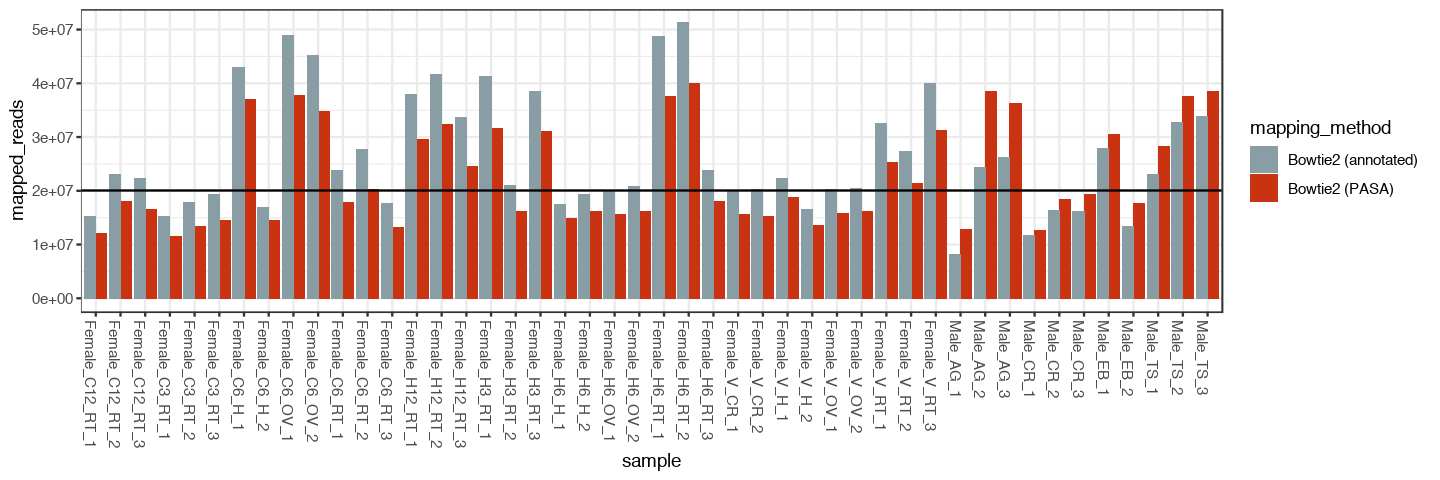

In [35]:
options(repr.plot.width = 12, repr.plot.height = 4)
ggplot(libSizes, aes(sample, mapped_reads, fill = mapping_method)) + 
    geom_bar(stat="identity", position = "dodge") + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    geom_hline(yintercept = 20000000) +
    scale_fill_manual(values = wes_palette("Royal1"))

ggsave("Results/Figures/Library_sizes.pdf", width = 12, height = 4)

A couple of things to note here. Not surprisingly, the Trinity mapping has the highest number of mapped reads across samples, while the HISAT2 genome mapping has the lowest (this is reflected in the percentage of mapping as well; see the MultiQC output from the Snakemake pipeline). Another thing to note is that, for the paired-end male data, there is no difference in the number of mapped reads between the HISAT2 and Trinity bowtie2 alignments, suggesting the genome divergence issues are mitigated by paired-end data. 

Now we can look at the appropriate cutoffs for filtering using Brian Haas' method. To do this we count the genes acrtoss a range of minimum TPM values. The eXpress output we used generates a file that can be used to generate this matrix (see Trinity online guidelines). We'll load those two files for the genom- and Trinity-based analyses:

In [36]:
a.bt2_cbmt = read.table("Genome/annotated_eXpress/annotated.gene.TPM.not_cross_norm.counts_by_min_TPM", header = T)
pasa.bt2_cbmt = read.table("Trinity/pasa/eXpress/pasa.gene.TPM.not_cross_norm.counts_by_min_TPM", header = T)

First extract the "expressed genes" (in this case, between 10 and 100 TPM):

In [37]:
a.bt2_cbmt.sub = a.bt2_cbmt[a.bt2_cbmt[,1] > -100 & a.bt2_cbmt[,1] < -10,]
pasa.bt2_cbmt.sub = pasa.bt2_cbmt[pasa.bt2_cbmt[,1] > -100 & pasa.bt2_cbmt[,1] < -10,]

Now we a perform a linear regression on this filtered subset of the data and display the value of the Y-intercept:

In [38]:
a.bt2_cbmt.sub_fit = lm(a.bt2_cbmt.sub[,2] ~ a.bt2_cbmt.sub[,1])
print(a.bt2_cbmt.sub_fit)

pasa.bt2_cbmt.sub_fit = lm(pasa.bt2_cbmt.sub[,2] ~ pasa.bt2_cbmt.sub[,1])
print(pasa.bt2_cbmt.sub_fit)


Call:
lm(formula = a.bt2_cbmt.sub[, 2] ~ a.bt2_cbmt.sub[, 1])

Coefficients:
        (Intercept)  a.bt2_cbmt.sub[, 1]  
           11534.67                76.03  


Call:
lm(formula = pasa.bt2_cbmt.sub[, 2] ~ pasa.bt2_cbmt.sub[, 1])

Coefficients:
           (Intercept)  pasa.bt2_cbmt.sub[, 1]  
               18918.9                   149.8  



Combine both matrices before plotting:

Warning message:
"Removed 2674 rows containing missing values (geom_point)."

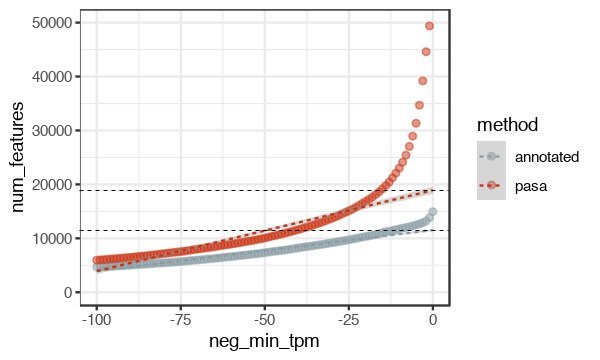

In [39]:
a.bt2_cbmt.sub$method = "annotated"
pasa.bt2_cbmt.sub$method = "pasa"
cbmtSub = rbind(a.bt2_cbmt.sub,pasa.bt2_cbmt.sub)

a.bt2_cbmt$method = "annotated"
pasa.bt2_cbmt$method = "pasa"
cbmtMatrix = rbind(a.bt2_cbmt,pasa.bt2_cbmt)

options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(cbmtMatrix, aes(neg_min_tpm, num_features, colour = method)) + 
    geom_point(alpha = 0.5) +  
    scale_x_continuous(limits=c(-100,0)) + 
    scale_y_continuous(limits=c(0,50000)) + 
    geom_smooth(data=cbmtSub, method = "lm",fullrange=TRUE, size = 0.5, linetype = "dashed") + 
    geom_hline(yintercept = 18918.9, linetype = "dashed", size = 0.2) + 
    geom_hline(yintercept = 11534.67, linetype = "dashed", size = 0.2) + 
#     ggtitle("Expressed genes", subtitle = "Decide cutoff of expressed genes") +
    scale_colour_manual(values = wes_palette("Royal1")) + 
    theme_bw()


In the Trinity analysis, out of 105593 "genes", roughly 35000 should remain after filtering lowly expressed genes. Simmilarly, 13000 out of ~20000 genes should remain in the genome analysis. Filtering should be performed on subsetted matrices for each analysis later because the threshold for the whole matrix tends to be too high, but we'll see what it is here. First, obtain the counts per million "CPM" matrix:

In [40]:
cpm_bt2.fbgn <- cpm(counts_bt2.fbgn)
cpm_bt2.pasa <- cpm(counts_bt2.pasa)

For now, let's set the minimum CPM to 10, and generate a logical matrix for CPM > 10:

In [41]:
thresh_bt2.fbgn <- cpm_bt2.fbgn > 10
thresh_bt2.pasa <- cpm_bt2.pasa > 10

We would like to keep genes that have at least 2 "TRUE"s in each row of thresh:

In [42]:
keep_bt2.fbgn <- rowSums(thresh_bt2.fbgn) >= 2
keep_bt2.pasa<- rowSums(thresh_bt2.pasa) >= 2

Now we subset the rows of the counts matrix to keep genes that satisfy our filter, then check how many genes are left:

In [43]:
countsKeep_bt2.fbgn <- counts_bt2.fbgn[keep_bt2.fbgn,]
dim(countsKeep_bt2.fbgn)

countsKeep_bt2.pasa <- counts_bt2.pasa[keep_bt2.pasa,]
dim(countsKeep_bt2.pasa)

[1] 11301    46

[1] 19942    46

So a filter of 10 CPM brings the count matrix to the expected number of genes using Brian Haas' method. We would like to know what the CPM values correspond to in terms of raw counts. To do this, we'll plot CPM vs. counts for each sample. (look at the last 30)

In [44]:
# options(repr.plot.width = 9, repr.plot.height = 8)
# par(mfrow=c(5,6))
# for(i in seq(from=17, to=46, by=1)){
#   plot(cpm_bt2.fbgn[,i],counts_bt2.fbgn[,i], xlim=c(0,10), ylim=c(0,200), xlab = "CPM", ylab = "count")
#   title(colnames(cpm_bt2.fbgn)[i])
# }

There's a range of correpondence between CPM values and raw counts. In general 10CPM seems to correspond to ~200 in raw counts.

## Differential Expression

### Tissue-biased genes

In the first portion of the differential expression analysis we'll look at genes that show tissue-biased expression in females. We'll perform this analysis on the genome-based transcriptome.

First we'll subset the matrix to include virgin female tissue samples.

In [45]:
counts_bt2.fbgn.femVirgin = subset(counts_bt2.fbgn, select=grepl("Female_V", colnames(counts_bt2.fbgn)))

# alternative including male tissues
counts_bt2.fbgn.tissues = subset(counts_bt2.fbgn, select=grepl("Female_V|Male", colnames(counts_bt2.fbgn)))

Now we can filter out low expression genes with a minimum 5 cpm cutoff (NOTE: Setting the threshold column number to 3 dramatically changes the number of tissue biased genes in this section).

In [46]:
cpm_bt2.fbgn.tissues <- cpm(counts_bt2.fbgn.tissues)
thresh_v.bt2.fbgn <- cpm_bt2.fbgn.tissues > 5
## look at number of columns with above requirements
table(rowSums(thresh_v.bt2.fbgn))

countsKeep_v.bt2.fbgn <- rowSums(thresh_v.bt2.fbgn) >= 2
countsFiltered_bt2.fbgn.tissues <- counts_bt2.fbgn.tissues[countsKeep_v.bt2.fbgn,]
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.tissues)


## Clean-up
rm(cpm_bt2.fbgn.tissues, countsKeep_v.bt2.fbgn, thresh_v.bt2.fbgn)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
2637  364  678 2033  401  654  479  402  357  313  385  348  404  317  394  442 
  16   17   18   19   20 
 335  467  499  326 2709 

[1] 11943    20

Let's make a specificity table from the TPM values that only includes genes that pass this filter:

In [47]:
specificity_table <- subset(tpmMatrix_bt2.fbgn, select=grepl("Female_V|Male", colnames(tpmMatrix_bt2.fbgn)))
specificity_table <- subset(specificity_table, rownames(specificity_table) %in% rownames(countsFiltered_bt2.fbgn.tissues))
specificity_table <- suppressWarnings(as.data.frame(calcSpecificity(specificity_table)))

## Also make a female- and male-specific specificity table:
female_specificity_table <- subset(tpmMatrix_bt2.fbgn, select=grepl("Female_V", colnames(tpmMatrix_bt2.fbgn)))
female_specificity_table <- subset(female_specificity_table, rownames(female_specificity_table) %in% rownames(countsFiltered_bt2.fbgn.tissues))
female_specificity_table <- suppressWarnings(as.data.frame(calcSpecificity(female_specificity_table)))

male_specificity_table <- subset(tpmMatrix_bt2.fbgn, select=grepl("Male", colnames(tpmMatrix_bt2.fbgn)))
male_specificity_table <- subset(male_specificity_table, rownames(male_specificity_table) %in% rownames(countsFiltered_bt2.fbgn.tissues))
male_specificity_table <- suppressWarnings(as.data.frame(calcSpecificity(male_specificity_table)))

Let's make a combined set of the individual sex specificity table:

In [48]:
combined_specificity_table <- cbind(female_specificity_table, male_specificity_table)
combined_specificity_table$FBgn_ID <- rownames(combined_specificity_table)
combined_specificity_table.m <- melt(combined_specificity_table, id.vars = "FBgn_ID")
colnames(combined_specificity_table.m) = c("FBgn_ID", "sample", "tao")

combined_specificity_table.m$sex = ifelse(grepl("Female", combined_specificity_table.m$sample), "female", "male")

combined_specificity_table.m$tissue = ifelse(grepl("RT",combined_specificity_table.m$sample), "repTract", ifelse(grepl("_H",combined_specificity_table.m$sample), "head", ifelse(grepl("_OV",combined_specificity_table.m$sample), "ovaries", ifelse(grepl("_CR",combined_specificity_table.m$sample), "carcass", ifelse(grepl("AG",combined_specificity_table.m$sample), "acGlnds", ifelse(grepl("EB",combined_specificity_table.m$sample), "ejBulb", "testes"))))))

We'll also subset the samplesData object to only include the virgin tissue and male samples:

In [49]:
sampleInfo.v = subset(sampleInfo, Status == "virgin")

# alternative including male tissues
sampleInfo.tissue = subset(sampleInfo, Status == "virgin" | Sex == "male")

Add a column to include the reproductive tract, head and ovary samples, so we can compare against everything else

In [50]:
sampleInfo.tissue$repTractFactor = ifelse(sampleInfo.tissue$Tissue == "repTract", "fRT", "not.fRT")
sampleInfo.tissue$ovariesFactor = ifelse(sampleInfo.tissue$Tissue == "ovaries", "ovaries", "not.ovaries")
sampleInfo.tissue$fHeadFactor = ifelse(sampleInfo.tissue$Tissue == "head", "fHead", "not.fHead")
sampleInfo.tissue$agFactor = ifelse(sampleInfo.tissue$Tissue == "acGlnds", "acGlns", "not.acGlns")
sampleInfo.tissue$ebFactor = ifelse(sampleInfo.tissue$Tissue == "ejBulb", "ejBulb", "not.ejBulb")
sampleInfo.tissue$tsFactor = ifelse(sampleInfo.tissue$Tissue == "testes", "testes", "not.testes")

We can now define groups for differential expression:

In [51]:
# all samples:
groups.v = factor(sampleInfo.tissue$Tissue)
design.v = model.matrix( ~ 0 + groups.v)
colnames(design.v) <- levels(groups.v)
rownames(design.v) <- sampleInfo.tissue$Replicate

# female rep. tract:
groups.fRT = factor(sampleInfo.tissue$repTractFactor)
design.fRT = model.matrix( ~ 0 + groups.fRT)
colnames(design.fRT) <- levels(groups.fRT)
rownames(design.fRT) <- sampleInfo.tissue$Replicate

# female head:
groups.fHead = factor(sampleInfo.tissue$fHeadFactor)
design.fHead = model.matrix( ~ 0 + groups.fHead)
colnames(design.fHead) <- levels(groups.fHead)
rownames(design.fHead) <- sampleInfo.tissue$Replicate

# ovaries:
groups.ovaries = factor(sampleInfo.tissue$ovariesFactor)
design.ovaries = model.matrix( ~ 0 + groups.ovaries)
colnames(design.ovaries) <- levels(groups.ovaries)
rownames(design.ovaries) <- sampleInfo.tissue$Replicate

# accessory glands:
groups.AG = factor(sampleInfo.tissue$agFactor)
design.AG = model.matrix( ~ 0 + groups.AG)
colnames(design.AG) <- levels(groups.AG)
rownames(design.AG) <- sampleInfo.tissue$Replicate

# ejaculatory bulb
groups.EB = factor(sampleInfo.tissue$ebFactor)
design.EB = model.matrix( ~ 0 + groups.EB)
colnames(design.EB) <- levels(groups.EB)
rownames(design.EB) <- sampleInfo.tissue$Replicate

# testes
groups.TS = factor(sampleInfo.tissue$tsFactor)
design.TS = model.matrix( ~ 0 + groups.TS)
colnames(design.TS) <- levels(groups.TS)
rownames(design.TS) <- sampleInfo.tissue$Replicate

Now we'll create the DGE object and fit the general linear model:

In [52]:
dgeList.v <- DGEList(counts = countsFiltered_bt2.fbgn.tissues, group = groups.v)
dgeList.v <- calcNormFactors(dgeList.v)
dgeList.v <- estimateDisp(dgeList.v, design.v, robust = T)
dgeList.v_fit <- glmQLFit(dgeList.v, design.v, robust = T)

dgeList.fRT <- DGEList(counts = countsFiltered_bt2.fbgn.tissues, group = groups.fRT)
dgeList.fRT <- calcNormFactors(dgeList.fRT)
dgeList.fRT <- estimateDisp(dgeList.fRT, design.fRT, robust = T)
dgeList.fRT_fit <- glmQLFit(dgeList.fRT, design.fRT, robust = T)

dgeList.fHead <- DGEList(counts = countsFiltered_bt2.fbgn.tissues, group = groups.fHead)
dgeList.fHead <- calcNormFactors(dgeList.fHead)
dgeList.fHead <- estimateDisp(dgeList.fHead, design.fHead, robust = T)
dgeList.fHead_fit <- glmQLFit(dgeList.fHead, design.fHead, robust = T)

dgeList.ovaries <- DGEList(counts = countsFiltered_bt2.fbgn.tissues, group = groups.ovaries)
dgeList.ovaries <- calcNormFactors(dgeList.ovaries)
dgeList.ovaries <- estimateDisp(dgeList.ovaries, design.ovaries, robust = T)
dgeList.ovaries_fit <- glmQLFit(dgeList.ovaries, design.ovaries, robust = T)

dgeList.AG <- DGEList(counts = countsFiltered_bt2.fbgn.tissues, group = groups.AG)
dgeList.AG <- calcNormFactors(dgeList.AG)
dgeList.AG <- estimateDisp(dgeList.AG, design.AG, robust = T)
dgeList.AG_fit <- glmQLFit(dgeList.AG, design.AG, robust = T)

dgeList.EB <- DGEList(counts = countsFiltered_bt2.fbgn.tissues, group = groups.EB)
dgeList.EB <- calcNormFactors(dgeList.EB)
dgeList.EB <- estimateDisp(dgeList.EB, design.EB, robust = T)
dgeList.EB_fit <- glmQLFit(dgeList.EB, design.EB, robust = T)

dgeList.TS <- DGEList(counts = countsFiltered_bt2.fbgn.tissues, group = groups.TS)
dgeList.TS <- calcNormFactors(dgeList.TS)
dgeList.TS <- estimateDisp(dgeList.TS, design.TS, robust = T)
dgeList.TS_fit <- glmQLFit(dgeList.TS, design.TS, robust = T)

We can add annotation information to the fit object, and put it in the genes slot:

In [53]:
Annots = merge(merge(melOrthsAll, trinotate_annotated, all=TRUE), dv1.06_features, all=TRUE)
annot.sum = unique(subset(Annots, select=c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description")))
annot.sum = aggregate(SwissProt_BlastX_Description ~ FBgn_ID + gene_name, data = annot.sum, toString)

now create the annotation object:

In [54]:
# Extract annotation for genes in the fit object
ann.v = subset(annot.sum, FBgn_ID %in% rownames(dgeList.v_fit))
# convert factors to characters
ann.v = data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.v = ann.v[match(rownames(dgeList.v_fit), ann.v$FBgn_ID),]
# convert factors to characters, again
ann.v <- data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.v) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.v$GeneID==rownames(dgeList.v_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.v_fit$genes = ann.v


 TRUE 
11943 

Do that for the fRT, ovaries and head dgeList as well:

In [55]:
ann.fRT = subset(annot.sum, FBgn_ID %in% rownames(dgeList.fRT_fit))
ann.fRT = data.frame(lapply(ann.fRT, as.character), stringsAsFactors=FALSE)
ann.fRT = ann.fRT[match(rownames(dgeList.fRT_fit), ann.fRT$FBgn_ID),]
ann.fRT <- data.frame(lapply(ann.fRT, as.character), stringsAsFactors=FALSE)
colnames(ann.fRT) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
dgeList.fRT_fit$genes = ann.fRT

ann.fHead = subset(annot.sum, FBgn_ID %in% rownames(dgeList.fHead_fit))
ann.fHead = data.frame(lapply(ann.fHead, as.character), stringsAsFactors=FALSE)
ann.fHead = ann.fHead[match(rownames(dgeList.fHead_fit), ann.fHead$FBgn_ID),]
ann.fHead <- data.frame(lapply(ann.fHead, as.character), stringsAsFactors=FALSE)
colnames(ann.fHead) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
dgeList.fHead_fit$genes = ann.fHead

ann.ovaries = subset(annot.sum, FBgn_ID %in% rownames(dgeList.ovaries_fit))
ann.ovaries = data.frame(lapply(ann.ovaries, as.character), stringsAsFactors=FALSE)
ann.ovaries = ann.ovaries[match(rownames(dgeList.ovaries_fit), ann.ovaries$FBgn_ID),]
ann.ovaries <- data.frame(lapply(ann.ovaries, as.character), stringsAsFactors=FALSE)
colnames(ann.ovaries) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
dgeList.ovaries_fit$genes = ann.ovaries

ann.AG = subset(annot.sum, FBgn_ID %in% rownames(dgeList.AG_fit))
ann.AG = data.frame(lapply(ann.AG, as.character), stringsAsFactors=FALSE)
ann.AG = ann.AG[match(rownames(dgeList.AG_fit), ann.AG$FBgn_ID),]
ann.AG <- data.frame(lapply(ann.AG, as.character), stringsAsFactors=FALSE)
colnames(ann.AG) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
dgeList.AG_fit$genes = ann.AG

ann.EB = subset(annot.sum, FBgn_ID %in% rownames(dgeList.EB_fit))
ann.EB = data.frame(lapply(ann.EB, as.character), stringsAsFactors=FALSE)
ann.EB = ann.EB[match(rownames(dgeList.EB_fit), ann.EB$FBgn_ID),]
ann.EB <- data.frame(lapply(ann.EB, as.character), stringsAsFactors=FALSE)
colnames(ann.EB) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
dgeList.EB_fit$genes = ann.EB

ann.TS = subset(annot.sum, FBgn_ID %in% rownames(dgeList.TS_fit))
ann.TS = data.frame(lapply(ann.TS, as.character), stringsAsFactors=FALSE)
ann.TS = ann.TS[match(rownames(dgeList.TS_fit), ann.TS$FBgn_ID),]
ann.TS <- data.frame(lapply(ann.TS, as.character), stringsAsFactors=FALSE)
colnames(ann.TS) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
dgeList.TS_fit$genes = ann.TS

Looks good. Now let's look at sample groupings using a multidimensional scaling plot (try 'method = "bcv"' for a different type of grouping):

In [56]:
glMDSPlot(dgeList.v, groups = dgeList.v$samples$group, labels = sampleInfo.tissue$Replicate)

Replicates are grouping correctly. Another way to look at grouping is a heatmap of sample correlations:

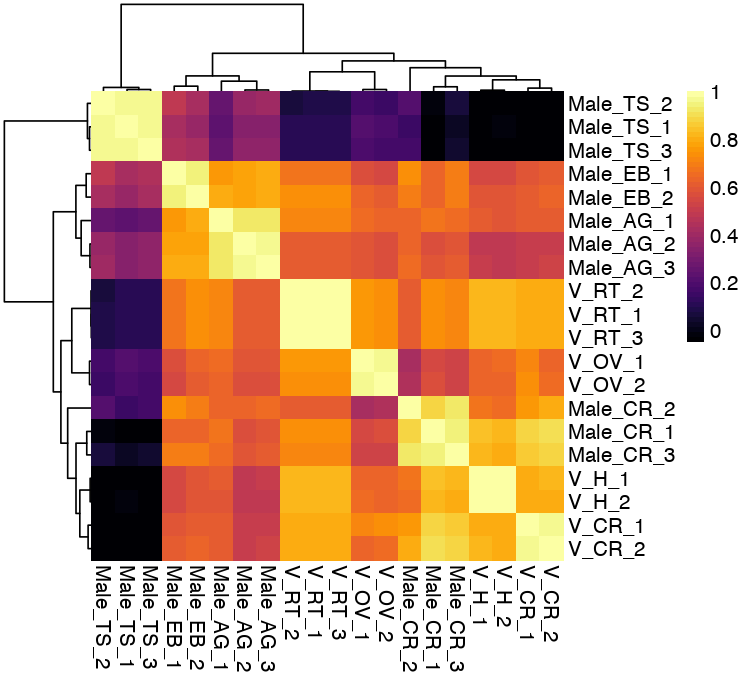

In [57]:
## Plot sample correlation
data = log2(countsFiltered_bt2.fbgn.tissues+1)
colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

options(repr.plot.width = 6.2, repr.plot.height = 5.7)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
  border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   filename          = "Results/Figures/F_and_M_sample_correlations.pdf",
#   width             = 6.2, 
#   height            = 5.7,
  fontsize          = 12    
)

Now we can identify genes that show tissue-biased expression. First, we define the relevant contrasts. We'll need to define a set of three contrasts for each tissue:

In [58]:
cont.v.repTract <- makeContrasts(V_RT.vs.V_CR=repTract-carcass,
                                 V_RT.vs.V_HD=repTract-head,
                                 V_RT.vs.V_OV=repTract-ovaries,
                                 levels=design.v)
cont.v.ovaries <- makeContrasts(V_OV.vs.V_CR=ovaries-carcass,
                                V_OV.vs.V_HD=ovaries-head,
                                V_OV.vs.V_RT=ovaries-repTract,
                                levels=design.v)
cont.v.head <- makeContrasts(V_H.vs.V_CR=head-carcass,
                             V_H.vs.V_OV=head-ovaries,
                             V_H.vs.V_RT=head-repTract,
                             levels=design.v)
cont.v.AG <- makeContrasts(AG.vs.CR=acGlnds-carcass,
                             AG.vs.TS=acGlnds-testes,
                             AG.vs.EB=acGlnds-ejBulb,
                             levels=design.v)
cont.v.EB <- makeContrasts(EB.vs.CR=ejBulb-carcass,
                             EB.vs.TS=ejBulb-testes,
                             EB.vs.AG=ejBulb-acGlnds,
                             levels=design.v)
cont.v.TS <- makeContrasts(TS.vs.CR=testes-carcass,
                             TS.vs.AG=testes-acGlnds,
                             TS.vs.EB=testes-ejBulb,
                             levels=design.v)

An alternative way is to use the dgeList object for the central tissue versus all other tissues, including male tissues:

In [59]:
repTract_contrast <- makeContrasts(fRT.vs.not_fRT=fRT-not.fRT,
                                 levels=design.fRT)

head_contrast <- makeContrasts(fHead.vs.not_fHead=fHead-not.fHead,
                                 levels=design.fHead)

ovaries_contrast <- makeContrasts(ovaries.vs.not_ovaries=ovaries-not.ovaries,
                                 levels=design.ovaries)

AG_contrast <- makeContrasts(AG.vs.not_AG=acGlns-not.acGlns,
                                 levels=design.AG)

EB_contrast <- makeContrasts(EB.vs.not_EB=ejBulb-not.ejBulb,
                                 levels=design.EB)

TS_contrast <- makeContrasts(TS.vs.not_TS=testes-not.testes,
                                 levels=design.TS)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the table with the relevant DE stats.

##### Female reprotductive tract:

In [60]:
lrt.v.repTract <- glmQLFTest(dgeList.v_fit, contrast = cont.v.repTract)
lrt.v.repTract.tTags <- topTags(lrt.v.repTract, n = NULL)
lrt.v.repTract.tTags.table <- lrt.v.repTract.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
repTract.list<-subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 1 & logFC.V_RT.vs.V_HD > 1 & logFC.V_RT.vs.V_OV > 1 & FDR<0.01)$GeneID
repTract.list.4fold<-subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 2 & logFC.V_RT.vs.V_HD > 2 & logFC.V_RT.vs.V_OV > 2 & FDR<0.01)$GeneID
repTract.list.10fold<-subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 3.32 & logFC.V_RT.vs.V_HD > 3.32 & logFC.V_RT.vs.V_OV > 3.32 & FDR<0.01)$GeneID

paste(length(repTract.list), " genes show RT-biased expression at a >2-fold cutoff, ", length(repTract.list.4fold), " at a >4-fold cutoff, and ", length(repTract.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "691 genes show RT-biased expression at a >2-fold cutoff, 297 at a >4-fold cutoff, and 112 at a >10-fold cutoff."

The alternative is to use the dgeList object that compares the fRT sample to all other samples:

In [61]:
lrt.fRT <- glmQLFTest(dgeList.fRT_fit, contrast = repTract_contrast)
lrt.fRT.tTags <- topTags(lrt.fRT, n = NULL)
lrt.fRT.tTags.table <- lrt.fRT.tTags$table

fRT.list<-subset(lrt.fRT.tTags.table, logFC > 1 & FDR<0.01)$GeneID
fRT.list.4fold<-subset(lrt.fRT.tTags.table, logFC > 2 & FDR<0.01)$GeneID
fRT.list.10fold<-subset(lrt.fRT.tTags.table, logFC > 3.32 & FDR<0.01)$GeneID

paste(length(fRT.list), " genes show RT-biased expression at a >2-fold cutoff, ", length(fRT.list.4fold), " at a >4-fold cutoff, and ", length(fRT.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "148 genes show RT-biased expression at a >2-fold cutoff, 142 at a >4-fold cutoff, and 92 at a >10-fold cutoff."

Let's look at the overlap of genes between the two methods, for example, in the ≥4-fold cutoff category:

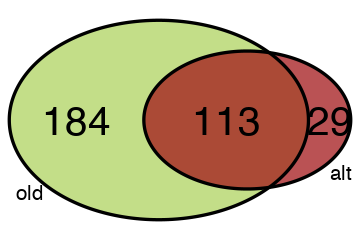

In [62]:
fRT_candidates <- list(alt = fRT.list.4fold, 
                        old = repTract.list.4fold)

fRT_Vdiag<-venn.diagram(fRT_candidates, NULL, fill=c("#a3181b", "#afd360"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

fRT_combs <- unlist(lapply(1:length(fRT_candidates), function(j) combn(names(fRT_candidates), j, simplify = FALSE)), recursive = FALSE)
names(fRT_combs) <- sapply(fRT_combs, function(i) paste0(i, collapse = ","))
fRT_elements <- lapply(fRT_combs, function(i) Setdiff(fRT_candidates[i], fRT_candidates[setdiff(names(fRT_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
# summary(fRT_elements)
grid.arrange(gTree(children=fRT_Vdiag))
# rm(fRT_candidates, fRT_Vdiag, fRT_combs)


##### Ovaries:

In [63]:
lrt.ovaries <- glmQLFTest(dgeList.ovaries_fit, contrast = ovaries_contrast)
lrt.ovaries.tTags <- topTags(lrt.ovaries, n = NULL)
lrt.ovaries.tTags.table <- lrt.ovaries.tTags$table

ovaries.list<-subset(lrt.ovaries.tTags.table, logFC > 1 & FDR<0.01)$GeneID
ovaries.list.4fold<-subset(lrt.ovaries.tTags.table, logFC > 2 & FDR<0.01)$GeneID
ovaries.list.10fold<-subset(lrt.ovaries.tTags.table, logFC > 3.32 & FDR<0.01)$GeneID

paste(length(ovaries.list), " genes show RT-biased expression at a >2-fold cutoff, ", length(ovaries.list.4fold), " at a >4-fold cutoff, and ", length(ovaries.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "766 genes show RT-biased expression at a >2-fold cutoff, 490 at a >4-fold cutoff, and 182 at a >10-fold cutoff."

The old way:

In [64]:
lrt.v.OV <- glmQLFTest(dgeList.v_fit, contrast = cont.v.ovaries)
lrt.v.OV.tTags <- topTags(lrt.v.OV, n = NULL)
lrt.v.OV.tTags.table <- lrt.v.OV.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
OV.list<-subset(lrt.v.OV.tTags.table, logFC.V_OV.vs.V_CR > 1 & logFC.V_OV.vs.V_HD > 1 & logFC.V_OV.vs.V_RT > 1 & FDR<0.01)$GeneID
OV.list.4fold<-subset(lrt.v.OV.tTags.table, logFC.V_OV.vs.V_CR > 2 & logFC.V_OV.vs.V_HD > 2 & logFC.V_OV.vs.V_RT > 2 & FDR<0.01)$GeneID
OV.list.10fold<-subset(lrt.v.OV.tTags.table, logFC.V_OV.vs.V_CR > 3.32 & logFC.V_OV.vs.V_HD > 3.32 & logFC.V_OV.vs.V_RT > 3.32 & FDR<0.01)$GeneID

paste(length(OV.list), " genes show RT-biased expression at a >2-fold cutoff, ", length(OV.list.4fold), " at a >4-fold cutoff, and ", length(OV.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "1892 genes show RT-biased expression at a >2-fold cutoff, 800 at a >4-fold cutoff, and 313 at a >10-fold cutoff."

##### Head:

In [65]:
lrt.fHead <- glmQLFTest(dgeList.fHead_fit, contrast = head_contrast)
lrt.fHead.tTags <- topTags(lrt.fHead, n = NULL)
lrt.fHead.tTags.table <- lrt.fHead.tTags$table

fHead.list<-subset(lrt.fHead.tTags.table, logFC > 1 & FDR<0.01)$GeneID
fHead.list.4fold<-subset(lrt.fHead.tTags.table, logFC > 2 & FDR<0.01)$GeneID
fHead.list.10fold<-subset(lrt.fHead.tTags.table, logFC > 3.32 & FDR<0.01)$GeneID

paste(length(fHead.list), " genes show RT-biased expression at a >2-fold cutoff, ", length(fHead.list.4fold), " at a >4-fold cutoff, and ", length(fHead.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "27 genes show RT-biased expression at a >2-fold cutoff, 26 at a >4-fold cutoff, and 20 at a >10-fold cutoff."


#### Male reprotductive tract:

###### Accessory glands:

In [66]:
lrt.v.AG <- glmQLFTest(dgeList.v_fit, contrast = cont.v.AG)
lrt.v.AG.tTags <- topTags(lrt.v.AG, n = NULL)
lrt.v.AG.tTags.table <- lrt.v.AG.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
AG.list<-subset(lrt.v.AG.tTags.table, logFC.AG.vs.CR > 1 & logFC.AG.vs.TS > 1 & logFC.AG.vs.EB > 1 & FDR<0.01)$GeneID
AG.list.4fold<-subset(lrt.v.AG.tTags.table, logFC.AG.vs.CR > 2 & logFC.AG.vs.TS > 2 & logFC.AG.vs.EB > 2 & FDR<0.01)$GeneID
AG.list.10fold<-subset(lrt.v.AG.tTags.table, logFC.AG.vs.CR > 3.32 & logFC.AG.vs.TS > 3.32 & logFC.AG.vs.EB > 3.32 & FDR<0.01)$GeneID

paste(length(AG.list), " genes show AG-biased expression at a >2-fold cutoff, ", length(AG.list.4fold), " at a >4-fold cutoff, and ", length(AG.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "655 genes show AG-biased expression at a >2-fold cutoff, 320 at a >4-fold cutoff, and 214 at a >10-fold cutoff."

In [67]:
lrt.AG_2 <- glmQLFTest(dgeList.AG_fit, contrast = AG_contrast)
lrt.AG_2.tTags <- topTags(lrt.AG_2, n = NULL)
lrt.AG_2.tTags.table <- lrt.AG_2.tTags$table

AG_2.list<-subset(lrt.AG_2.tTags.table, logFC > 1 & FDR<0.01)$GeneID
AG_2.list.4fold<-subset(lrt.AG_2.tTags.table, logFC > 2 & FDR<0.01)$GeneID
AG_2.list.10fold<-subset(lrt.AG_2.tTags.table, logFC > 3.32 & FDR<0.01)$GeneID

paste(length(AG_2.list), " genes show AG_2-biased expression at a >2-fold cutoff, ", length(AG_2.list.4fold), " at a >4-fold cutoff, and ", length(AG_2.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "480 genes show AG_2-biased expression at a >2-fold cutoff, 385 at a >4-fold cutoff, and 238 at a >10-fold cutoff."

Let's look at the overlap between the male-restricted method and when accounting for both sexes, and the old AG-biased geneset:

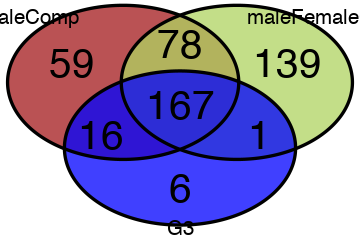

In [68]:
AG_candidates <- list(maleComp = AG.list.4fold, 
                        maleFemaleComp = AG_2.list.4fold,
                            G3 = c(as.character(AG_biased), as.character(SFPs)))

AG_Vdiag<-venn.diagram(AG_candidates, NULL, fill=c("#a3181b", "#afd360", "blue"), alpha=c(0.75,0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

AG_combs <- unlist(lapply(1:length(AG_candidates), function(j) combn(names(AG_candidates), j, simplify = FALSE)), recursive = FALSE)
names(AG_combs) <- sapply(AG_combs, function(i) paste0(i, collapse = ","))
AG_elements <- lapply(AG_combs, function(i) Setdiff(AG_candidates[i], AG_candidates[setdiff(names(AG_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
# summary(AG_elements)
grid.arrange(gTree(children=AG_Vdiag))
# rm(AG_candidates, AG_Vdiag, AG_combs)



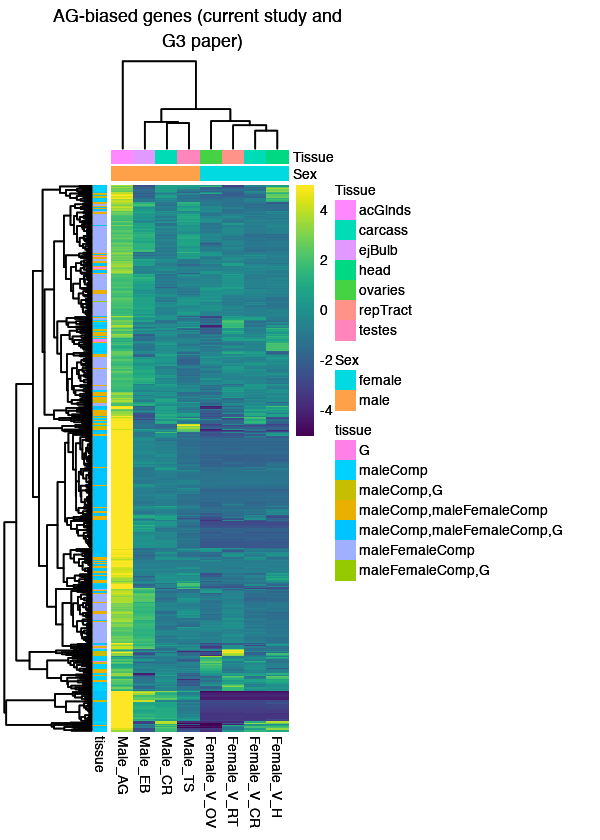

In [69]:
df <- as.data.frame(unlist(AG_elements))
colnames(df) = "FBgn_ID"
df$tissue = rownames(df)
df$tissue = gsub('[[:digit:]]','', df$tissue)
rownames(df) = df$FBgn_ID
df = dplyr::select(df, "tissue")

options(repr.plot.width = 5, repr.plot.height =7)
heatmap_mean_ra(tpmMatrix = dplyr::select(tpmMatrix_bt2.fbgn, matches("Female_V|^Male")), gene_list = unlist(AG_elements), title = "AG-biased genes (current study and \n G3 paper)", x = 5, show_names = F, row_annots = df)

###### Ejaculatory bulb:

In [70]:
lrt.v.EB <- glmQLFTest(dgeList.v_fit, contrast = cont.v.EB)
lrt.v.EB.tTags <- topTags(lrt.v.EB, n = NULL)
lrt.v.EB.tTags.table <- lrt.v.EB.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
EB.list<-subset(lrt.v.EB.tTags.table, logFC.EB.vs.CR > 1 & logFC.EB.vs.TS > 1 & logFC.EB.vs.AG > 1 & FDR<0.01)$GeneID
EB.list.4fold<-subset(lrt.v.EB.tTags.table, logFC.EB.vs.CR > 2 & logFC.EB.vs.TS > 2 & logFC.EB.vs.AG > 2 & FDR<0.01)$GeneID
EB.list.10fold<-subset(lrt.v.EB.tTags.table, logFC.EB.vs.CR > 3.32 & logFC.EB.vs.TS > 3.32 & logFC.EB.vs.AG > 3.32 & FDR<0.01)$GeneID

paste(length(EB.list), " genes show EB-biased expression at a >2-fold cutoff, ", length(EB.list.4fold), " at a >4-fold cutoff, and ", length(EB.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "494 genes show EB-biased expression at a >2-fold cutoff, 209 at a >4-fold cutoff, and 99 at a >10-fold cutoff."

In [71]:
lrt.EB_2 <- glmQLFTest(dgeList.EB_fit, contrast = EB_contrast)
lrt.EB_2.tTags <- topTags(lrt.EB_2, n = NULL)
lrt.EB_2.tTags.table <- lrt.EB_2.tTags$table

EB_2.list<-subset(lrt.EB_2.tTags.table, logFC > 1 & FDR<0.01)$GeneID
EB_2.list.4fold<-subset(lrt.EB_2.tTags.table, logFC > 2 & FDR<0.01)$GeneID
EB_2.list.10fold<-subset(lrt.EB_2.tTags.table, logFC > 3.32 & FDR<0.01)$GeneID

paste(length(EB_2.list), " genes show EB_2-biased expression at a >2-fold cutoff, ", length(EB_2.list.4fold), " at a >4-fold cutoff, and ", length(EB_2.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "130 genes show EB_2-biased expression at a >2-fold cutoff, 118 at a >4-fold cutoff, and 79 at a >10-fold cutoff."

###### Testes:

In [72]:
lrt.v.TS <- glmQLFTest(dgeList.v_fit, contrast = cont.v.TS)
lrt.v.TS.tTags <- topTags(lrt.v.TS, n = NULL)
lrt.v.TS.tTags.table <- lrt.v.TS.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
TS.list<-subset(lrt.v.TS.tTags.table, logFC.TS.vs.CR > 1 & logFC.TS.vs.EB > 1 & logFC.TS.vs.AG > 1 & FDR<0.01)$GeneID
TS.list.4fold<-subset(lrt.v.TS.tTags.table, logFC.TS.vs.CR > 2 & logFC.TS.vs.EB > 2 & logFC.TS.vs.AG > 2 & FDR<0.01)$GeneID
TS.list.10fold<-subset(lrt.v.TS.tTags.table, logFC.TS.vs.CR > 3.32 & logFC.TS.vs.EB > 3.32 & logFC.TS.vs.AG > 3.32 & FDR<0.01)$GeneID

paste(length(TS.list), " genes show TS-biased expression at a >2-fold cutoff, ", length(TS.list.4fold), " at a >4-fold cutoff, and ", length(TS.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "3323 genes show TS-biased expression at a >2-fold cutoff, 2599 at a >4-fold cutoff, and 2070 at a >10-fold cutoff."

In [73]:
lrt.TS_2 <- glmQLFTest(dgeList.TS_fit, contrast = TS_contrast)
lrt.TS_2.tTags <- topTags(lrt.TS_2, n = NULL)
lrt.TS_2.tTags.table <- lrt.TS_2.tTags$table

TS_2.list<-subset(lrt.TS_2.tTags.table, logFC > 1 & FDR<0.01)$GeneID
TS_2.list.4fold<-subset(lrt.TS_2.tTags.table, logFC > 2 & FDR<0.01)$GeneID
TS_2.list.10fold<-subset(lrt.TS_2.tTags.table, logFC > 3.32 & FDR<0.01)$GeneID

paste(length(TS_2.list), " genes show TS_2-biased expression at a >2-fold cutoff, ", length(TS_2.list.4fold), " at a >4-fold cutoff, and ", length(TS_2.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "2812 genes show TS_2-biased expression at a >2-fold cutoff, 2464 at a >4-fold cutoff, and 2039 at a >10-fold cutoff."

Let's look at the expression pattern of the female reproductive tract genes across all the virgin female and male samples:

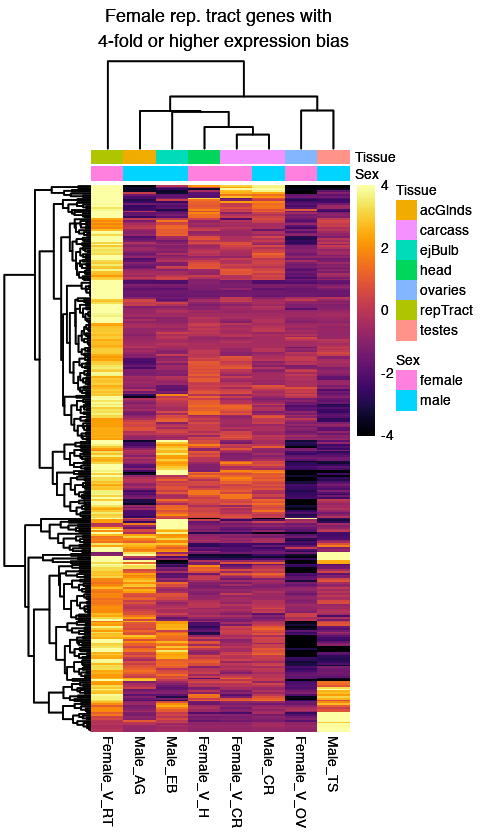

In [74]:
options(repr.plot.width = 4, repr.plot.height =7)
heatmap_mean(tpmMatrix = dplyr::select(tpmMatrix_bt2.fbgn, matches("Female_V|^Male")), gene_list = repTract.list.4fold, title = "Female rep. tract genes with \n 4-fold or higher expression bias", x = 4, melNames = F, show_names = F)

There're quite a few genes that, although are strongly biased in expression in the female reprductive tract, are also highly expressed in male reproductive tissues. Let's examine that overlap:

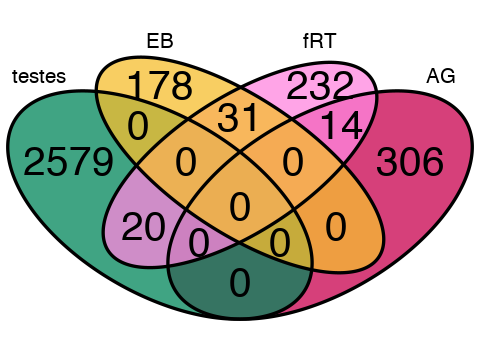

In [75]:
tissue_candidates <- list(testes = TS.list.4fold, 
                        AG = AG.list.4fold,
                          EB = EB.list.4fold,
                          fRT = repTract.list.4fold)

tissue_Vdiag<-venn.diagram(tissue_candidates, NULL, fill=c("#01855a","#c8004e","#f6be2e","#ff86df"), alpha=c(0.75,0.75,0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

tissue_combs <- unlist(lapply(1:length(tissue_candidates), function(j) combn(names(tissue_candidates), j, simplify = FALSE)), recursive = FALSE)
names(tissue_combs) <- sapply(tissue_combs, function(i) paste0(i, collapse = ","))
tissue_elements <- lapply(tissue_combs, function(i) Setdiff(tissue_candidates[i], tissue_candidates[setdiff(names(tissue_candidates), i)]))

options(repr.plot.width = 4, repr.plot.height =3)
# summary(tissue_elements)
grid.arrange(gTree(children=tissue_Vdiag))
# rm(tissue_candidates, tissue_Vdiag, tissue_combs)

Make a factor object for the above elements:

In [76]:
MF_tissue_biased.factors = as.data.frame(unlist(tissue_elements))
MF_tissue_biased.factors$cat = rownames(MF_tissue_biased.factors)
MF_tissue_biased.factors$cat = gsub("[[:digit:]]", "", MF_tissue_biased.factors$cat)
colnames(MF_tissue_biased.factors) = c("FBgn_ID", "category")
rownames(MF_tissue_biased.factors) = MF_tissue_biased.factors$FBgn_ID
MF_tissue_biased.factors = subset(MF_tissue_biased.factors, select = "category")
MF_tissue_biased.factors$category = gsub(",", "_", MF_tissue_biased.factors$category)
MF_tissue_biased.factors = subset(MF_tissue_biased.factors, grepl("_fRT", category))
MF_tissue_biased.factor_list = unique(MF_tissue_biased.factors[,1])

Output individual gene plots for these shared female/male reproductive genes:

In [77]:
for (feature_cat in MF_tissue_biased.factor_list) {
    tmp.Plots = suppressMessages(lapply(rownames(MF_tissue_biased.factors)[MF_tissue_biased.factors$category == feature_cat], geneBoxPlot, object = tpmTable_bt2.fbgn))
    ggsave(paste("Results/Plots/tissue-bias/F_and_M_sharedTissue_biased.", feature_cat, ".pdf", sep = ""), marrangeGrob(grobs = tmp.Plots, nrow = 3, ncol =1))
}

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


Output gene summaries for those genes:

In [78]:
MF_tissue_biased_gene_snapshots_list = list()
for (feature_cat in MF_tissue_biased.factor_list) {
    tmpInfo = filter(annot.sum, FBgn_ID %in% rownames(MF_tissue_biased.factors)[MF_tissue_biased.factors$category == feature_cat])
#     tmpInfo = select(tmpInfo, -datestamp)
    category = feature_cat
    tmpInfo$category = category
    MF_tissue_biased_gene_snapshots_list[[feature_cat]] = tmpInfo
}
MF_tissue_biased_gene_snapshots = rbindlist(MF_tissue_biased_gene_snapshots_list)
MF_tissue_biased_gene_snapshots = merge(MF_tissue_biased_gene_snapshots, melOrthsAll, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
tmpFile = dplyr::select(melOrths, FBgn_ID, mel_FBgn_ID)
MF_tissue_biased_gene_snapshots = merge(MF_tissue_biased_gene_snapshots, tmpFile, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
write.table(MF_tissue_biased_gene_snapshots, "Results/GeneSummaries/MF_tissue_biased_sigGenes_snapshots.txt", quote = F, sep = "\t", row.names = F)
rm(MF_tissue_biased_gene_snapshots_list, tmpFile)

Let's make another heatmap that highlights the genes that also show expression bias in male reproductive tissues:

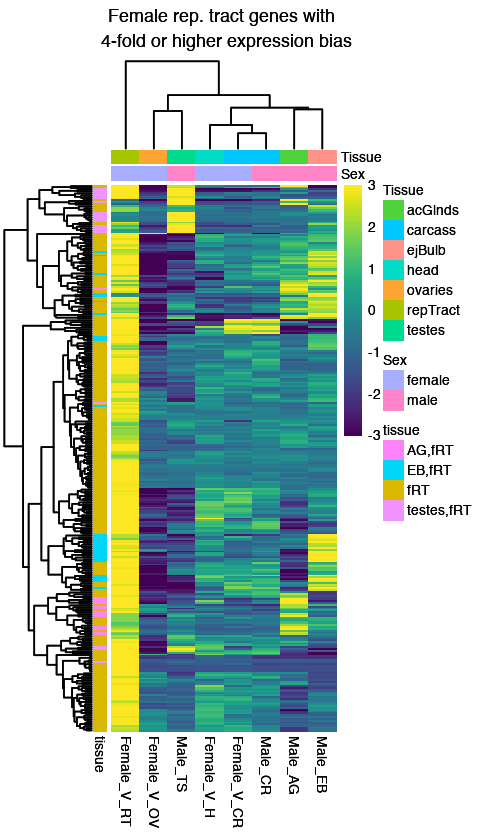

In [79]:
df <- as.data.frame(unlist(tissue_elements))
colnames(df) = "FBgn_ID"
df$tissue = rownames(df)
df$tissue = gsub('[[:digit:]]','', df$tissue)
rownames(df) = df$FBgn_ID
df = select(df, tissue)

options(repr.plot.width = 4, repr.plot.height =7)
heatmap_mean_ra(tpmMatrix = select(tpmMatrix_bt2.fbgn, matches("Female_V|^Male")), gene_list = repTract.list.4fold, title = "Female rep. tract genes with \n 4-fold or higher expression bias", x = 3, show_names = F, row_annots = df)

We can generate tissue-biased factor tables to annotate heatmaps of the tissue-biased genes, and can also be used for GO analysis later:

In [80]:
RT_factors = as.data.frame(fRT.list)
RT_factors$V1 = "RT-biased"
rownames(RT_factors) = fRT.list
RT_factors = subset(RT_factors, select = "V1")

OV_factors = as.data.frame(ovaries.list)
OV_factors$V1 = "OV-biased"
rownames(OV_factors) = ovaries.list
OV_factors = subset(OV_factors, select = "V1")

H_factors = as.data.frame(fHead.list)
H_factors$V1 = "H-biased"
rownames(H_factors) = fHead.list
H_factors = subset(H_factors, select = "V1")

## Adding male-bised genes here:
AG_factors = as.data.frame(as.character(AG_biased))
AG_factors$V1 = "AG-biased"
rownames(AG_factors) = as.character(AG_biased)
AG_factors = subset(AG_factors, select = "V1")

SFP_factors = as.data.frame(as.character(SFPs))
SFP_factors$V1 = "SFP"
rownames(SFP_factors) = as.character(SFPs)
SFP_factors = subset(SFP_factors, select = "V1")

virgin.factor.labeling = rbind(RT_factors, 
                               OV_factors,
#                                AG_factors,
#                                SFP_factors,
                               H_factors 
                               )
colnames(virgin.factor.labeling) = c('tissue_bias')
virgin.factor_list = unique(virgin.factor.labeling[,1])

For a heatmap, we'll subset from the mean TPM matrix produced in the introduction:

In [81]:
meanTPM_v_bt2.fbgn = subset(tpmMatrix_bt2.fbgn, rownames(tpm_bt2.fbgn) %in% rownames(virgin.factor.labeling))
meanTPM_v_bt2.fbgn = subset(meanTPM_v_bt2.fbgn, select=grepl("Female_V", colnames(meanTPM_v_bt2.fbgn)))
colnames(meanTPM_v_bt2.fbgn) = gsub("Female_V_", "", colnames(meanTPM_v_bt2.fbgn))

Some more bells and whistles to generate the heatmap (for now with heatmap.3, fix this later and use the pheatmap package):

In [82]:
data = meanTPM_v_bt2.fbgn
gene_factors = unique(virgin.factor.labeling[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2

For a heatmap using "pheatmap", here's how to rotate column labels:

In [83]:
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

Set the colours for the side bar like so:

In [84]:
mat_colors <- list(tissue_bias = c("#c75f65", "#949b48", "#9475c5"))
names(mat_colors$tissue_bias) <- unique(virgin.factor.labeling$tissue_bias)

Can set the scale breaks like this:

In [85]:
# mat_breaks <- seq(min(heatmap_data), max(heatmap_data), length.out = 10)

Or this is better:

In [86]:
# quantile_breaks <- function(xs, n = 10) {
#   breaks <- quantile(xs, probs = seq(0, 1, length.out = n))
#   breaks[!duplicated(breaks)]
# }

# mat_breaks <- quantile_breaks(mat, n = 101)

Now plot it:

In [87]:
# To only include a subset of the samples for the heatmap
# heatmap_data = subset(heatmap_data, select = c("CR", "OV", "RT"))

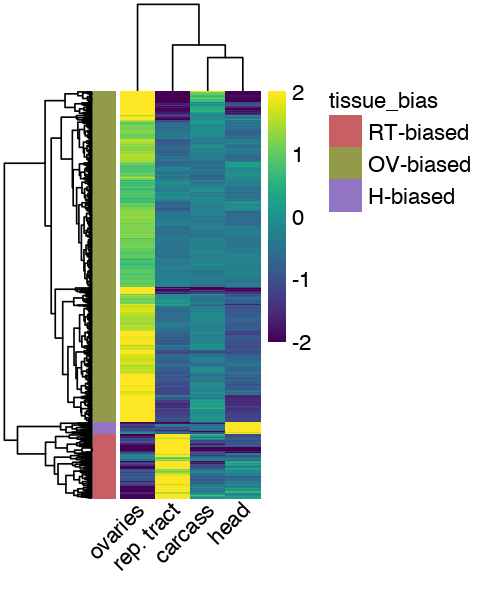

In [88]:
options(repr.plot.width = 4, repr.plot.height =5)

fig2A = pheatmap(
  mat               = heatmap_data,
  color             = viridis(100),
#   breaks            = mat_breaks,
  border_color      = NA,
  labels_col        = c("carcass", "head","ovaries", "rep. tract", "head"),
  show_colnames     = TRUE,
  show_rownames     = FALSE,
  annotation_row    = virgin.factor.labeling,
  annotation_colors = mat_colors,
  drop_levels       = TRUE,
  annotation_names_row = F,
#   main              = "Default Heatmap",
#   filename          = "Results/Figures/female_tissue-biased_heatmap.pdf",
#   width             = 4, 
#   height            = 5,
  fontsize          = 13    
)

#### Gene Ontology

Process the gene length information and GO annotation files for GOseq:

In [89]:
GO_info_listed = apply(GOinfo_annotated, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GOinfo_annotated)
features_with_GO = rownames(GOinfo_annotated)
lengths_features_with_GO = a.gene_lengths[features_with_GO,]
get_GO_term_descr =  function(x) {
    d = 'none';
    go_info = GOTERM[[x]];
    if (length(go_info) >0) { d = paste(Ontology(go_info), Term(go_info), sep=' ');}
    return(d);
}

We'll process some of this and come up with the null expectation for GO terms, then plot the proportion of tissue-biased genes as a function of those biased in bins of 200:

Warning message in pcls(G):
"initial point very close to some inequality constraints"

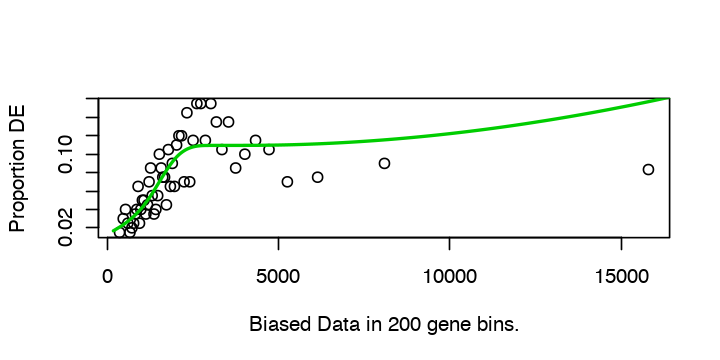

In [90]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% rownames(virgin.factor.labeling))
pwf=nullp(DEgenes = cat_genes_vec, bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

That looks fine. Now we'll process each tissue biased category of genes in a for-loop to identify enriched GO terms and their FDR values:

In [91]:
GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in virgin.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(virgin.factor.labeling)[virgin.factor.labeling$tissue_bias == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))

GO_enrichment_data = rbindlist(GO_enriched_list)

Output the significant GO terms to the Results folder:

In [92]:
write.table(subset(GO_enrichment_data, over_represented_FDR < 0.05), "Results/GO_analyses/GO_results-female_tissue-biased_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Take a look at the results for fRT by plotting categories that contain more than 10 genes (manually removing reducndant ones where possible):

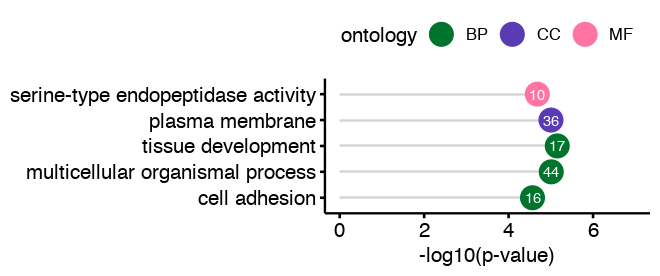

In [93]:
thisData = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "RT-biased" & !is.na(term) & term != "extracellular space")
thisData$neg_log10_FDR = -log10(thisData$over_represented_pvalue)

options(repr.plot.width = 5.5, repr.plot.height = 2.3)
ggdotchart(filter(thisData, numDEInCat >= 10 & term != "serine-type peptidase activity" & term != "animal organ development" & term != "anatomical structure development" & term != "anatomical structure morphogenesis" & term != "biological adhesion"), x = "term", y = "neg_log10_FDR",
           color = "ontology",                                # Color by groups
           palette = c("#00732c", "#593bb4", "#ff74a2"), # Custom color palette
           sorting = "descending",                       # Sort value in descending order
           add = "segments",                             # Add segments from y = 0 to dots
           rotate = TRUE,                                # Rotate vertically
           group = "ontology",                                # Order by groups
           dot.size = 6,                                 # Large dot size
           label = "numDEInCat",                        # Add mpg values as dot labels
           font.label = list(color = "white", size = 9, 
                             vjust = 0.5),               # Adjust label parameters
#            ggtheme = theme_monokai_full()                        # ggplot2 theme
           ) + labs(y = "-log10(p-value)", x = NULL) + scale_y_continuous(limits = c(0,7))
ggsave("Results/Figures/sigGO_RT-biased.pdf", width = 5.5, height = 2.3)
rm(thisData)

We can also run a KEGG pathway enrichment:

In [94]:
RT_genes_altIDs = subset(dv1.06_features, FBgn_ID %in% fRT.list)$gene_name
RT_genes_altIDs = gsub("^", "Dvir_", RT_genes_altIDs)
RT_kegg <- enrichKEGG(gene = RT_genes_altIDs, organism = 'dvi')
subset(RT_kegg@result, qvalue < 0.05)
write.table(RT_kegg@result, "Results/KEGG/RT-biased_kegg_table.txt", quote = F, sep = "\t", row.names = F)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
dvi04512,dvi04512,ECM-receptor interaction,3/34,14/3376,0.0003150776,0.01386342,0.01359809,Dvir_GJ12003/Dvir_GJ11135/Dvir_GJ17000,3
dvi04080,dvi04080,Neuroactive ligand-receptor interaction,5/34,75/3376,0.0007960094,0.01751221,0.01717704,Dvir_GJ12183/Dvir_GJ22325/Dvir_GJ21573/Dvir_GJ21575/Dvir_GJ14885,5


Let's output a plot of these genes:

In [95]:
RT_biased_KEGG_neuroactive_ligand_recetor_genes_boxPlots = suppressMessages(lapply(gsub("Dvir_", "", unlist(strsplit(subset(RT_kegg@result, qvalue < 0.05)$geneID, split="/"))), geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/tissue-bias/RT-biased_KEGG_neuroactive_ligand_recetor_genes.pdf", marrangeGrob(grobs = RT_biased_KEGG_neuroactive_ligand_recetor_genes_boxPlots, nrow = 3, ncol =1))

Saving 7 x 7 in image


Let's look at some of the enriched terms in the reproductive tract. First, Molecular function:

In [96]:
subset(GO_enrichment_data, ontology == "MF" & over_represented_FDR < 0.05 & factor == "RT-biased")[,c("category","term","numDEInCat")]

category,term,numDEInCat
<chr>,<chr>,<int>
GO:0004252,serine-type endopeptidase activity,10
GO:0047939,L-glucuronate reductase activity,2
GO:0008236,serine-type peptidase activity,10


Some interesting terms here include peptidases and reductases. We'll output individual gene expression plots for ther eductases here, since there're only 2:

[[1]]

[[2]]


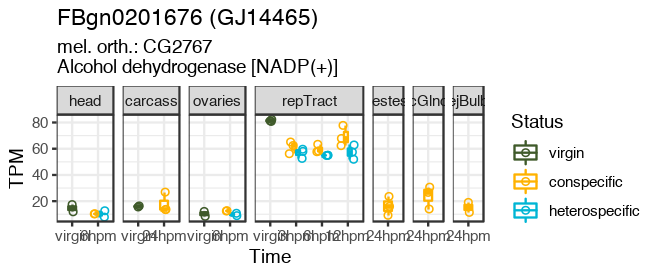

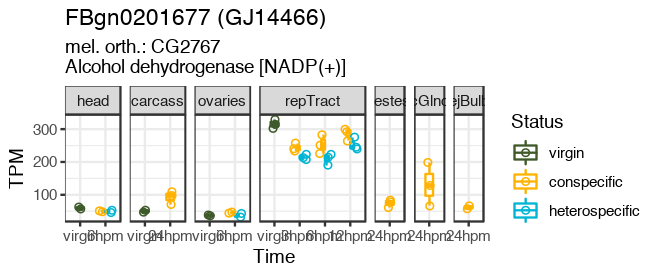

In [97]:
options(repr.plot.width = 5.5, repr.plot.height = 2.3)
lapply(extract_GO_genes(go_term = "GO:0047939", gene_set = fRT.list), geneBoxPlot, object = tpmTable_bt2.fbgn)

They appear to be Adh-like genes that are adjacent to each other.

In [98]:
RT_biased_endopeptidase_genes = extract_GO_genes(go_term = "GO:0004252", gene_set = fRT.list)
RT_biased_endopeptidase_genes_boxPlots = suppressMessages(lapply(RT_biased_endopeptidase_genes, geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/tissue-bias/RT-biased_endopeptidase_proteins.pdf", marrangeGrob(grobs = RT_biased_endopeptidase_genes_boxPlots, nrow = 3, ncol =1))

Saving 7 x 7 in image


Now let's look at the genes in the Biological Process categories:

In [99]:
subset(GO_enrichment_data, ontology == "BP" & over_represented_FDR < 0.05 & factor == "RT-biased")[,c("category","term","numDEInCat")]

category,term,numDEInCat
<chr>,<chr>,<int>
GO:0048513,animal organ development,27
GO:0009888,tissue development,17
GO:0007498,mesoderm development,7
GO:0032501,multicellular organismal process,44
GO:0007155,cell adhesion,16
GO:0048856,anatomical structure development,39
GO:0007617,mating behavior,5
GO:0022610,biological adhesion,16
GO:0042839,D-glucuronate metabolic process,2


Potentially lots of overlap between genes in this ontology class and the MF ontology class, but the "mating behaviour" category is interesting. We'll make a plot object for those:.

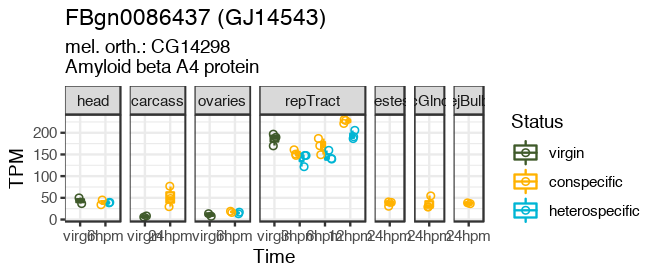

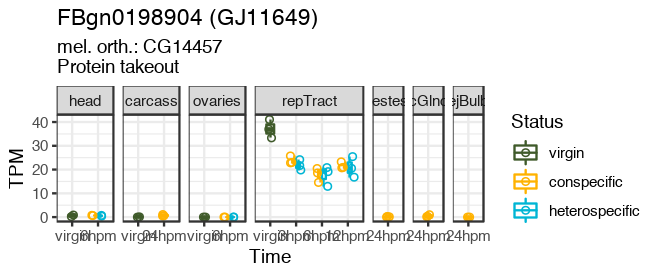

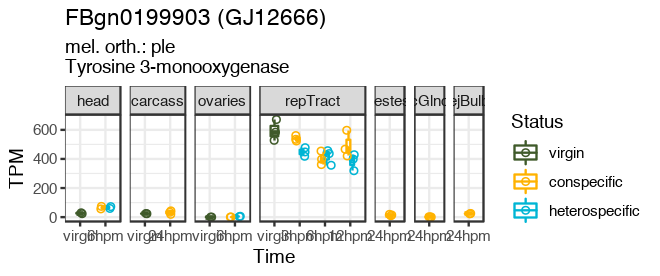

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


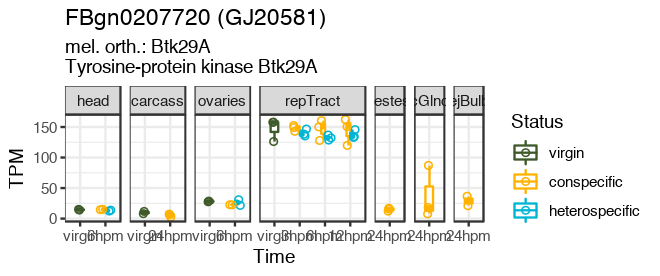

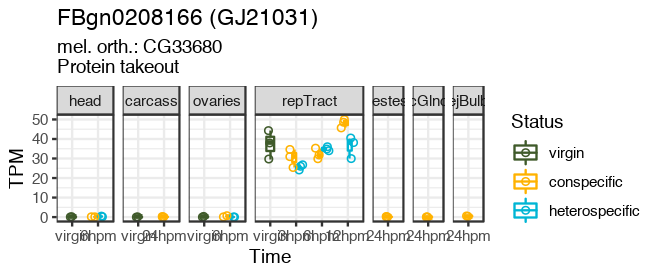

In [100]:
options(repr.plot.width = 5.5, repr.plot.height = 2.3)
lapply(extract_GO_genes(go_term = "GO:0007617", gene_set = fRT.list), geneBoxPlot, object = tpmTable_bt2.fbgn)

Many genes involved in developmental processes. Make gene plots for those:

In [101]:
RT_biased_development_genes = extract_GO_genes(go_term = "GO:0032501", gene_set = fRT.list)
RT_biased_development_genes_boxPlots = suppressMessages(lapply(RT_biased_development_genes, geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/tissue-bias/RT-biased_development_proteins.pdf", marrangeGrob(grobs = RT_biased_development_genes_boxPlots, nrow = 3, ncol =1))

Saving 7 x 7 in image


... and the Cellular Component category

In [102]:
subset(GO_enrichment_data, ontology == "CC" & over_represented_FDR < 0.05 & factor == "RT-biased")[,c("category","term","numDEInCat")]

category,term,numDEInCat
<chr>,<chr>,<int>
GO:0005615,extracellular space,17
GO:0005886,plasma membrane,36
GO:0044449,contractile fiber part,8


Plot the plasma membrane genes:

In [103]:
RT_biased_transport_genes = extract_GO_genes(go_term = "GO:0005886", gene_set = fRT.list)
RT_biased_transport_genes_boxPlots = suppressMessages(lapply(RT_biased_transport_genes, geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/tissue-bias/RT-biased_membrane_transporters.pdf", marrangeGrob(grobs = RT_biased_transport_genes_boxPlots, nrow = 3, ncol =1))

Saving 7 x 7 in image


We should also output all the gene summaries for the 148 fRT genes :

In [104]:
tmpInfo = filter(annot.sum, FBgn_ID %in% fRT.list)
tmpMatrix = subset(tpmMatrix_bt2.fbgn, select=grepl("Female_V|Male", colnames(tpmMatrix_bt2.fbgn)))
colnames(tmpMatrix) = gsub("Female_V_", "Female_", colnames(tmpMatrix))
tmpMatrix$Gene_ID = rownames(tmpMatrix)
tmpMatrix = filter(tmpMatrix, Gene_ID %in% fRT.list)
tmpFile = dplyr::select(melOrths, FBgn_ID, mel_FBgn_ID, mel_GeneSymbol)
tmpInfo = merge(tmpInfo, tmpFile, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
fRT_gene_snapshots = merge(tmpInfo, tmpMatrix, by.x = "FBgn_ID", by.y = "Gene_ID", all.x = T)
write.table(fRT_gene_snapshots, "Results/GeneSummaries/fRT_biased_genes_snapshots.txt", quote = F, sep = "\t", row.names = F)
rm(tmpInfo, tmpMatrix, tmpFile)

Make an individual plot folder to link the gene summaries:

In [105]:
# for(gene in fRT.list){
#   my.plot <- geneBoxPlot(object = tpmTable_bt2.fbgn, gene = gene)
#   ggsave(my.plot, file = paste0("Results/Plots/Single_Genes/fRT.list/", gene, ".pdf"), width = 8, height = 2.5)
# }

#### Population genetics:

Let's plot the _Ka/Ks_ values of RT-biased genes along chromosomes. First we'll make a table containing all the relevant data:

In [106]:
AN_KaKs_data = (filter(KaKs.data, COMPARISON == "D.amr_vs_D.nov" & Ks > 0.0003))
AN_KaKs_data = merge(AN_KaKs_data, FBgn_to_FBtr, by.x = "FBtr_ID", by.y = "FBtr_ID", all.x = TRUE)
AN_KaKs_data = merge(AN_KaKs_data, dv1.06_features, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
AN_KaKs_data = merge(AN_KaKs_data, annot.sum, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
AN_KaKs_data$status = ifelse(AN_KaKs_data$FBgn_ID %in% fRT.list, "RT-biased", ifelse(AN_KaKs_data$FBgn_ID %in% AG_biased, "AG-biased", ifelse(AN_KaKs_data$FBgn_ID %in% SFPs, "SFPs", "all")))
AN_KaKs_data$KaKs = AN_KaKs_data$`Ka/Ks`

Run a statistical test:

In [107]:
KaKs.test <- as.data.frame(compare_means(
 KaKs ~ status, data = AN_KaKs_data,
 method = "wilcox.test"
))
KaKs.test

.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
KaKs,all,RT-biased,1.729707e-01,1.7e-01,0.1730,ns,Wilcoxon
KaKs,all,SFPs,2.820722e-14,1.4e-13,2.8e-14,****,Wilcoxon
KaKs,all,AG-biased,3.011265e-07,9.0e-07,3.0e-07,****,Wilcoxon
KaKs,RT-biased,SFPs,2.518167e-15,1.5e-14,2.5e-15,****,Wilcoxon
KaKs,RT-biased,AG-biased,1.796127e-07,7.2e-07,1.8e-07,****,Wilcoxon
KaKs,SFPs,AG-biased,9.904077e-03,2.0e-02,0.0099,**,Wilcoxon


Now make a plot:

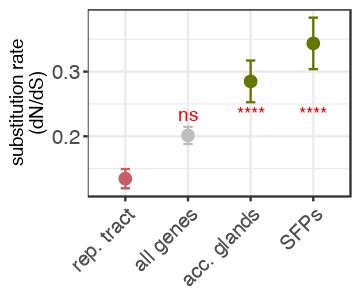

In [108]:
AN_KaKs_data$status = gsub("all", "all genes", AN_KaKs_data$status)
AN_KaKs_data$status = gsub("RT-biased", "rep. tract", AN_KaKs_data$status)
AN_KaKs_data$status = gsub("AG-biased", "acc. glands", AN_KaKs_data$status)
AN_KaKs_data$status = factor(AN_KaKs_data$status, levels = c("rep. tract", "all genes", "acc. glands", "SFPs"))

KaKs_comparisons <- list( c("rep. tract", "all genes"), c("rep. tract", "SFPs"), c("rep. tract", "acc. glands") )

KaKs_y_title <- expression(paste(italic("Ka/Ks")))

options(repr.plot.width = 3, repr.plot.height = 2.5)
(fig2D = ggerrorplot(subset(AN_KaKs_data, ), 
            x = "status", 
            y = "Ka/Ks", 
            color = "status",
            add = "mean", 
#             desc_stat = "mean_se",
            error.plot = "errorbar",
            ggtheme = theme_bw(),
            palette = c("#C75E64", "gray", "#647700", "#647700")
           ) +
         theme_bw() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 12), 
              legend.position = "none", 
              axis.title.x = element_blank(), 
              axis.text.y = element_text(size = 12)) +
#               stat_pvalue_manual(KaKs.test, label = "p.adj") +
        stat_compare_means(ref.group = "rep. tract", 
                           method = "wilcox.test", 
                           label.y = 0.235, 
                           aes(label = ..p.signif..), color = "red"
                          )  +
#         scale_y_continuous(values = c(0.15,0.42)) +
        labs(y = "substitution rate\n(dN/dS)"))
        
ggsave("Results/Figures/dNdS_pointPlot.pdf", width = 3, height = 2.5)

Let's plot omega across the genome:

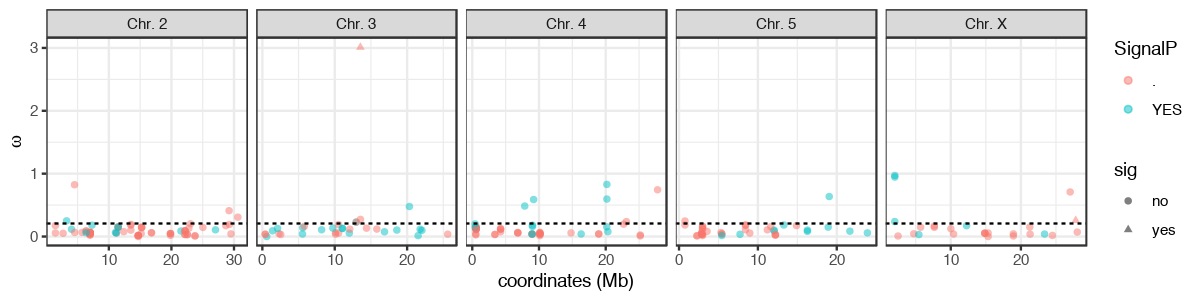

In [109]:
omegaLRT = merge(paml2.data, FBgn_to_FBtr, by.x = "FBtr_ID", by.y = "FBtr_ID", all.x = TRUE)
omegaLRT = merge(omegaLRT, dv1.06_features, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
omegaLRT = merge(omegaLRT, annot.sum, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
omegaLRT = merge(omegaLRT, AN_KaKs_data, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
sigPtmp = unique(select(trinotate_annotated, FBgn_ID, SignalP))
omegaLRT = merge(omegaLRT, sigPtmp, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)

options(repr.plot.width = 10, repr.plot.height = 2.5)
omega_y_title <- expression(paste(italic(omega)))
omegaLRT$chromosome.x = gsub("Chr_", "Chr. ", omegaLRT$chromosome.x)

omegaLRT$sig = ifelse(omegaLRT$Dvir_FDR < 0.01, "yes", "no")
omegaLRT = unique(subset(omegaLRT, select = c("chromosome.x", "FBgn_ID", "sig", "min.x", "omega", "Dnov_FDR", "gene_name.x.x", "SignalP")))

(fig2E = ggplot(filter(omegaLRT, grepl("Chr", chromosome.x) & chromosome.x != "Chr. 6" & FBgn_ID %in% fRT.list), aes(min.x, omega, shape = sig, colour = SignalP)) + 
    geom_point(alpha = 0.5) + 
    facet_grid(.~chromosome.x, scales = "free_x") + 
    geom_hline(yintercept = 0.2, linetype = "dashed") +
    scale_x_continuous(breaks=seq(from=0, to=30e6, by = 10e6), labels=as.character(seq(0,30,10))) +
#     geom_text_repel(data = filter(omegaLRT, grepl("Chr", chromosome.x) & chromosome.x != "Chr. 6" & FBgn_ID %in% fRT.list & omega > 0.23), aes(label = gene_name.x.x), size = 2.5, fontface = "bold.italic", force = 30, colour = "black", ylim  = c(1, NA)) +
    labs(x = "coordinates (Mb)", y = omega_y_title) +
    guides(size=guide_legend(title="-log10(FDR)\n(branch-site LRT)"))+
    theme(strip.background =  element_rect(colour = "white", fill = "white")) +
    theme_bw()+
    theme(axis.text.x = element_text(angle = 0, vjust = 1)))
# dev.off()

Now let's plot the percent identity for cDNA and protein of these gene categories. First add some conditional columns:

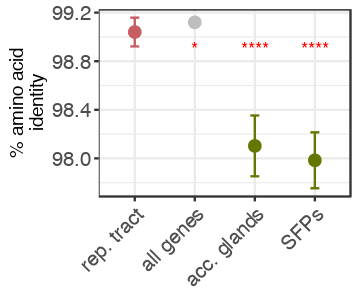

In [110]:
KaKs.data$status = ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% fRT.list)$FBtr_ID, "RT-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% AG_biased)$FBtr_ID, "AG-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% TS_biased)$FBtr_ID, "testes-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% EB_biased)$FBtr_ID, "EB-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% ovaries.list.4fold)$FBtr_ID, "OV-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% SFPs)$FBtr_ID, "SFPs", "all"))))))

KaKs.data$status = gsub("all", "all genes", KaKs.data$status)
KaKs.data$status = gsub("RT-biased", "rep. tract", KaKs.data$status)
KaKs.data$status = gsub("AG-biased", "acc. glands", KaKs.data$status)
KaKs.data$status = factor(KaKs.data$status, levels = c("rep. tract", "all genes", "acc. glands", "SFPs"))

options(repr.plot.width = 3, repr.plot.height = 2.5)

(fig2C = ggerrorplot(filter(KaKs.data, COMPARISON == "D.amr_vs_D.nov" & (status == "all genes" | status == "acc. glands" | status == "rep. tract" | status == "SFPs")), 
            x = "status", 
            y = "PROT_PERCENTID", 
            color = "status",
            add = "mean", 
            error.plot = "errorbar",
            desc_stat = "mean_se",
            ggtheme = theme_bw(),
            palette = c("#C75E64", "gray", "#647700", "#647700")
           ) +
  theme_bw() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 12), 
              legend.position = "none", 
              axis.title.x = element_blank(), 
              axis.text.y = element_text(size = 12)) +
        
#               stat_pvalue_manual(KaKs.test, label = "p.adj") +
        stat_compare_means(ref.group = "rep. tract", 
                           method = "wilcox.test", 
                           label.y = 98.9, 
                           aes(label = ..p.signif..), color = "red"
                          )  +
#         scale_y_continuous(values = c(0.15,0.42)) +
        labs(y = "% amino acid\nidentity"))
        
ggsave("Results/Figures/AA_identity_pointPlot.pdf", width = 3, height = 2.5)

Finally, let's look at the chromosomal distribution of these gene categories:

In [111]:
TotalGeneNumber = as.data.frame(table(factor(subset(dv1.06_features, grepl("Chr", chromosome))$chromosome)))
colnames(TotalGeneNumber) = c("chromosome", "All genes")
total_genes = nrow(dv1.06_features)
TotalGeneNumber$proportion = (TotalGeneNumber$`All genes`/total_genes)

Output tissue-biased data: (note to self: THIS IS UGLY!!! Figure out a way to make this more concise).

In [112]:
## AG_biased and SFPs
genomeNumber.AG_biased = length(AG_biased) + length(SFPs)
chromNumber.AG_biased=as.data.frame(table(factor(subset(dv1.06_features, (FBgn_ID %in% AG_biased | FBgn_ID %in% SFPs) & grepl("Chr", chromosome))$chromosome)))
colnames(chromNumber.AG_biased) = c("chromosome", "Observed_biased_genes")
chromNumber.AG_biased$sex = "male"
chromNumber.AG_biased = merge(TotalGeneNumber, chromNumber.AG_biased)
chromNumber.AG_biased$`Expected genes` = genomeNumber.AG_biased*chromNumber.AG_biased$proportion
chromNumber.AG_biased$`obs.exp` = chromNumber.AG_biased$Observed_biased_genes/chromNumber.AG_biased$`Expected genes`
chromNumber.AG_biased$`Gene category` = "AG_biased"

## repTract.list.4fold
genomeNumber.repTract = length(fRT.list)
chromNumber.repTract=as.data.frame(table(factor(subset(dv1.06_features, FBgn_ID %in% fRT.list & grepl("Chr", chromosome))$chromosome)))
colnames(chromNumber.repTract) = c("chromosome", "Observed_biased_genes")
chromNumber.repTract$sex = "female"
chromNumber.repTract = merge(TotalGeneNumber, chromNumber.repTract)
chromNumber.repTract$`Expected genes` = genomeNumber.repTract*chromNumber.repTract$proportion
chromNumber.repTract$`obs.exp` = chromNumber.repTract$Observed_biased_genes/chromNumber.repTract$`Expected genes`
chromNumber.repTract$`Gene category` = "RT_biased"

## ovaries.list
genomeNumber.ovaries = length(ovaries.list)
chromNumber.ovaries=as.data.frame(table(factor(subset(dv1.06_features, FBgn_ID %in% ovaries.list & grepl("Chr", chromosome))$chromosome)))
colnames(chromNumber.ovaries) = c("chromosome", "Observed_biased_genes")
chromNumber.ovaries$sex = "female"
chromNumber.ovaries = merge(TotalGeneNumber, chromNumber.ovaries)
chromNumber.ovaries$`Expected genes` = genomeNumber.ovaries*chromNumber.ovaries$proportion
chromNumber.ovaries$`obs.exp` = chromNumber.ovaries$Observed_biased_genes/chromNumber.ovaries$`Expected genes`
chromNumber.ovaries$`Gene category` = "OV_biased"

Combine the elements above and perform a Chi-square test:

In [113]:
tissue_biased.numbers = rbind(chromNumber.AG_biased, chromNumber.repTract, chromNumber.ovaries)
tissue_biased.numbers$`Gene category` = factor(tissue_biased.numbers$`Gene category`, levels = c("AG_biased", "OV_biased","RT_biased"))

tissue_biased.numbers$Chr = gsub("Chr_", "", tissue_biased.numbers$chromosome)
tissue_biased.numbers$Chr = factor(tissue_biased.numbers$Chr, levels = c("X", "2","3", "4", "5"))

tissue_biased.numbers$ChiSq = ((tissue_biased.numbers$Observed_biased_genes-tissue_biased.numbers$`Expected genes`)^2)/tissue_biased.numbers$`Expected genes`

tissue_biased.numbers$pval = 1-(pchisq(tissue_biased.numbers$ChiSq, df = 1))
tissue_biased.numbers$FDR = tissue_biased.numbers$pval*nrow(tissue_biased.numbers)

tissue_biased.numbers$sigLabel = NULL
tissue_biased.numbers$sigLabel = ifelse(tissue_biased.numbers$pval < 0.05 & tissue_biased.numbers$pval > 0.01, "*", ifelse(tissue_biased.numbers$pval < 0.01 & tissue_biased.numbers$pval > 0.001, "**", ifelse(tissue_biased.numbers$pval < 0.001, "***", "")))

Now plot it:

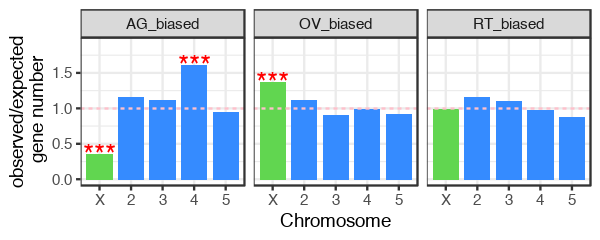

In [114]:
options(repr.plot.width =5, repr.plot.height = 2)
(fig2B = ggplot(filter(tissue_biased.numbers, chromosome != "Chr_6"), aes(Chr, obs.exp, fill = Chr)) +
    facet_wrap(~`Gene category`) +
    geom_bar(position=position_dodge(), stat="identity", width = 0.8) +
    geom_hline(yintercept = 1, linetype = "dashed", colour = "pink") +
    scale_fill_manual(values = c("#61d650", "#358bff","#358bff", "#358bff", "#358bff")) +
    labs(x = "Chromosome", y = "observed/expected\n gene number") +
    geom_text(aes(label = sigLabel), size = 6, colour = "red", position=position_dodge(width = 0.8)) +
    theme_bw() +
    theme(legend.position = "none", axis.text.x = element_text(angle = 0, vjust = 1)) +
#     theme(legend.position = "none", strip.background = element_rect(fill = "white")) +
    scale_y_continuous(limits=c(0,1.9)))

ggsave("Results/Figures/chromsome_distribution.pdf", width = 5, height = 2)

## Reproductive tract post-mating contrasts:

Create RT-specific count matrix 

In [115]:
counts_bt2.fbgn.RT = subset(counts_bt2.fbgn, select=grepl("RT", colnames(counts_bt2.fbgn)))

#######
## use this subset command if we want to remove the ovary-biased genes
counts_bt2.fbgn.RT = subset(subset(counts_bt2.fbgn, rownames(counts_bt2.fbgn) %!in% OV.list.4fold), select=grepl("RT", colnames(counts_bt2.fbgn)))
#######

colnames(counts_bt2.fbgn.RT) = gsub("Female_", "", colnames(counts_bt2.fbgn.RT))
# counts_bt2.fbgn.RT = subset(counts_bt2.fbgn.RT, select=RT_GoodReps)

Now let's filter low expression genes within a minimum cpm of 5:

In [116]:
cpm_bt2.fbgn.RT <- cpm(counts_bt2.fbgn.RT)
thresh_RT.bt2.fbgn <- cpm_bt2.fbgn.RT > 5

countsKeep_RT.bt2.fbgn <- rowSums(thresh_RT.bt2.fbgn) >= 3
countsFiltered.fbgn.RT <- round(counts_bt2.fbgn.RT[countsKeep_RT.bt2.fbgn,])
countsFiltered_bt2.fbgn.RT <- as.data.frame(lapply(countsFiltered.fbgn.RT[1:21], as.integer))
rownames(countsFiltered_bt2.fbgn.RT) <- rownames(countsFiltered.fbgn.RT)
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.RT)

## Clean-up
rm(cpm_bt2.fbgn.RT, countsKeep_RT.bt2.fbgn, thresh_RT.bt2.fbgn)

[1] 7215   21

We'll also subset the samplesInfo object to only include the RT samples:

In [117]:
sampleInfo.pm = subset(sampleInfo, Tissue == "repTract")
# remove rogue replicates:
# sampleInfo.pm = subset(sampleInfo.pm, Replicate != "Female_H3_RT_1" & Replicate != "Female_H6_RT_1")
sampleInfo.pm$SampleName = gsub("Female_", "", sampleInfo.pm$SampleName)
sampleInfo.pm$Replicate = gsub("Female_", "", sampleInfo.pm$Replicate)

### Comparing con- and heterospecific postmating time points to each other and to the virgin RT sample:

Here we can set up new grouping and comparison matrix with all the postmating time-point samples by combining the "Status" and "time" factors. This design matrix will test differences between each postmating time-point and the virgin sample:

In [118]:
## Will need to relevel the Status grouping to make virgin control
Status.time <- factor(paste(sampleInfo.pm$Status, sampleInfo.pm$Time, sep="."))
sampleInfo.pmv <- cbind(sampleInfo.pm, Group=Status.time)
sampleInfo.pmv$Group <- relevel(sampleInfo.pmv$Group, ref = "virgin.virgin")

groups.pmv <- factor(sampleInfo.pmv$Group)
design.pmv <- model.matrix(~groups.pmv)
colnames(design.pmv) <- levels(groups.pmv)
rownames(design.pmv) <- sampleInfo.pmv$Replicate

Next we need to set a different matrix where we test for differences between conspecific and heterospecific treatments of each time point:

In [119]:
groups.pmb <- factor(sampleInfo.pm$SampleName)
design.pmb <- model.matrix(~ 0 + groups.pmb)
colnames(design.pmb) <- levels(groups.pmb)
rownames(design.pmb) <- sampleInfo.pm$Replicate

From an earlier examination of the data there's some undesirable variation to dispose of. We'll use RUVseq to deal with that:

In [120]:
set.pmb <- newSeqExpressionSet(as.matrix(countsFiltered_bt2.fbgn.RT), phenoData = data.frame(groups.pmb, row.names = colnames(countsFiltered_bt2.fbgn.RT)))
set.pmb <- betweenLaneNormalization(set.pmb, which="upper")

In [121]:
set.pmv <- newSeqExpressionSet(as.matrix(countsFiltered_bt2.fbgn.RT), phenoData = data.frame(groups.pmv, row.names = colnames(countsFiltered_bt2.fbgn.RT)))
set.pmv <- betweenLaneNormalization(set.pmv, which="upper")

Run an initial model fit for both sets

In [122]:
y.pmb <- DGEList(counts=counts(set.pmb), group=groups.pmb)
y.pmb <- calcNormFactors(y.pmb, method="upperquartile")
y.pmb <- estimateDisp(y.pmb, design.pmb, robust = T)
fit.pmb <- glmQLFit(y.pmb, design.pmb, dispersion = y.pmb$tagwise.dispersion, robust = T)
res.pmb <- residuals(fit.pmb, type="deviance")

y.pmv <- DGEList(counts=counts(set.pmv), group=groups.pmv)
y.pmv <- calcNormFactors(y.pmv, method="upperquartile")
y.pmv <- estimateDisp(y.pmv, design.pmv, robust = T)
fit.pmv <- glmQLFit(y.pmv, design.pmv, dispersion = y.pmv$tagwise.dispersion, robust = T)
res.pmv <- residuals(fit.pmv, type="deviance")

Now run RUVr:

In [123]:
batch_ruv_res.pmb = RUVr(set.pmb,rownames(countsFiltered_bt2.fbgn.RT),k=2,res.pmb)
batch_ruv_res.pmv = RUVr(set.pmv,rownames(countsFiltered_bt2.fbgn.RT),k=2,res.pmv)

Let's output the batch-corrected counts:

In [124]:
RUVrNormalizedCounts = normCounts(object = batch_ruv_res.pmb)
rownames(RUVrNormalizedCounts) = rownames(countsFiltered_bt2.fbgn.RT)

Now create new design matrices with the new batch factors:

In [125]:
design_2.pmb <- model.matrix(~ 0 + groups.pmb + W_1 + W_2, data=pData(batch_ruv_res.pmb))
colnames(design_2.pmb) <- gsub("groups.pmb", "", colnames(design_2.pmb))

design_2.pmv <- model.matrix(~groups.pmv + W_1 + W_2, data=pData(batch_ruv_res.pmv))
colnames(design_2.pmv) <- gsub("groups.pmv", "", colnames(design_2.pmv))

Quick look at the samples causing batch effects (should be H3_RT_1 and H6_RT_1):

Using sample, replicate as id variables


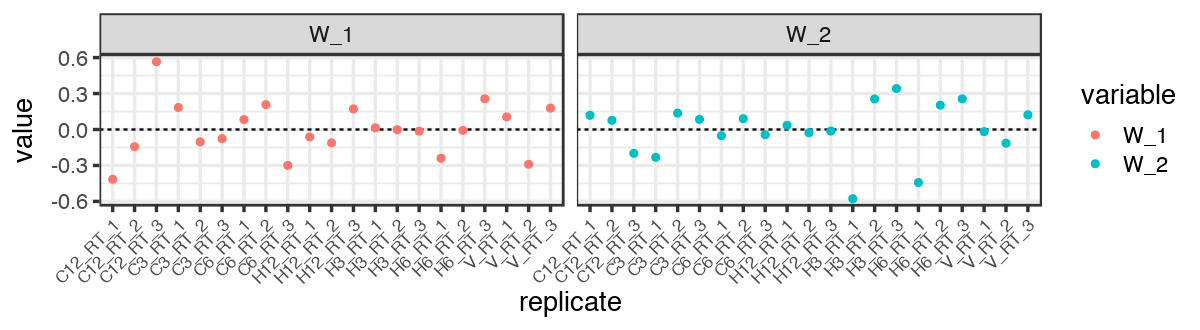

In [126]:
options(repr.plot.width = 10, repr.plot.height = 2.75)
batch_drivers = melt(data.frame(sample = batch_ruv_res.pmb$groups.pmb, replicate = sampleInfo.pm$Replicate, W_1 = batch_ruv_res.pmb$W_1, W_2 = batch_ruv_res.pmb$W_2))
ggplot(batch_drivers, aes(replicate, value, colour = variable)) + geom_hline(yintercept = 0, linetype = "dashed") + geom_point() + facet_wrap(~variable) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 10))

With the RUVseq adjusted counts, we're going to need a new TPM table:

In [127]:
tmpLengths = subset(a.gene_lengths, rownames(a.gene_lengths) %in% rownames(RUVrNormalizedCounts))
RUVrNormalizedTPM = tpm(counts = RUVrNormalizedCounts, lengths = tmpLengths$length)

Make a new TPM table and mean matrix as well:

In [128]:
## For annotated bt2 data
TPMmatrix <- RUVrNormalizedTPM
TPMmatrix.m <- as.data.frame(melt(as.matrix(TPMmatrix)))
TPMmatrix.m = merge(TPMmatrix.m, sampleInfo.pm, by.x = "X2", "Replicate")
TPMmatrix.m = select(TPMmatrix.m, X2, X1, value, SampleName, Status, Time)
colnames(TPMmatrix.m) <- c("replicate_id", "FBgn_ID", "TPM", "sample", "Status", "Time")
tpmTable_RUVrNormalized.fbgn = merge(TPMmatrix.m, fbgn_to_geneName, by.x = "FBgn_ID", by.y = "FBgn_ID")
rm(TPMmatrix.m, TPMmatrix)

tmpMat<-cast(tpmTable_RUVrNormalized.fbgn, FBgn_ID~sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_RUVrNormalized.fbgn <- tmpMat[,-1]
rownames(tpmMatrix_RUVrNormalized.fbgn) <- tmpMat[,1]
rm(tmpMat)

Create edgeR DE object and run glmFit

In [129]:
dgeList.pmb <- DGEList(counts = counts(set.pmb), group = groups.pmb)
dgeList.pmb <- calcNormFactors(dgeList.pmb)
dgeList.pmb <- estimateGLMCommonDisp(dgeList.pmb, design_2.pmb)
dgeList.pmb <- estimateGLMTagwiseDisp(dgeList.pmb, design_2.pmb)
dgeList.pmb <- estimateGLMTrendedDisp(dgeList.pmb, design_2.pmb)
dgeList.pmb_fit <- glmQLFit(dgeList.pmb, design_2.pmb, dispersion = dgeList.pmb$tagwise.dispersion, robust = T)

dgeList.pmv <- DGEList(counts = counts(set.pmv), group = groups.pmv)
dgeList.pmv <- calcNormFactors(dgeList.pmv)
dgeList.pmv <- estimateGLMCommonDisp(dgeList.pmv, design_2.pmv)
dgeList.pmv <- estimateGLMTagwiseDisp(dgeList.pmv, design_2.pmv)
dgeList.pmv <- estimateGLMTrendedDisp(dgeList.pmv, design_2.pmv)
dgeList.pmv_fit <- glmQLFit(dgeList.pmv, design_2.pmv, dispersion = dgeList.pmv$tagwise.dispersion, robust = T)
summary(dgeList.pmv$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.002999 0.005515 0.006975 0.014270 0.009952 0.760379 

Again, quick look at the BCV, mean-variance trend, qq-plot and normalized count distributions.

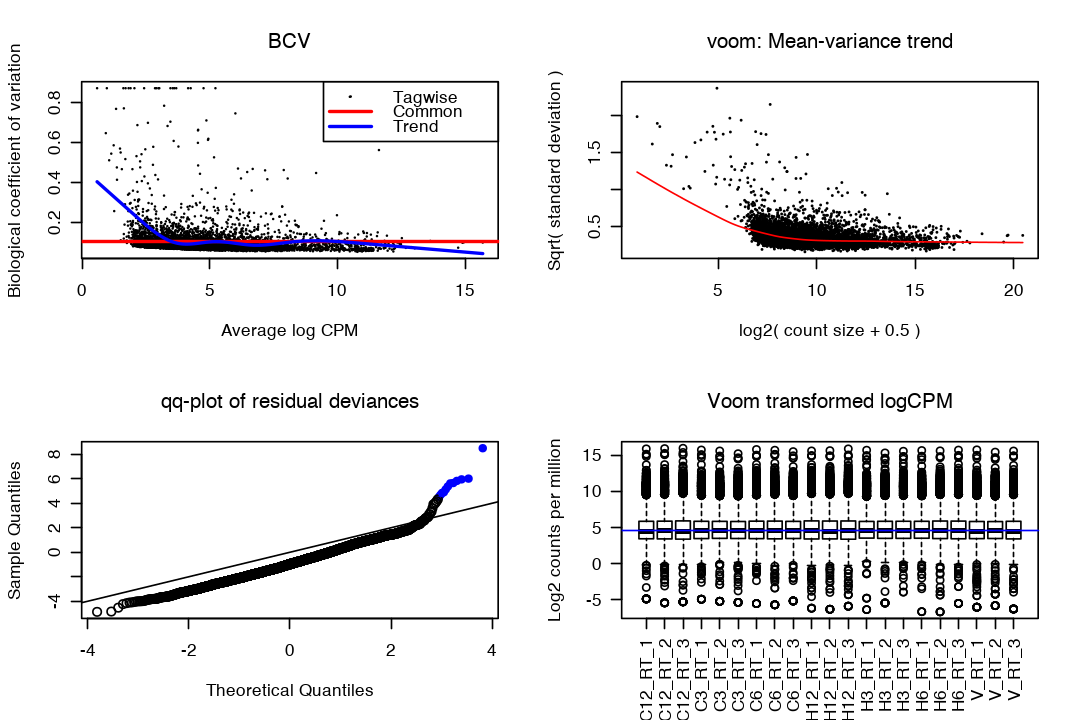

In [130]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))

# Biological coefficient of variation
plotBCV(dgeList.pmb, main = "BCV", )

# mean-variance trend
voom = voom(dgeList.pmb, design_2.pmb, plot=TRUE)

# QQ-plot
gof(dgeList.pmb_fit, pcutoff = 0.05, adjust = "holm", plot = T)
# g.v <- gof(dgeList_fit, pcutoff = 0.05, adjust = "holm")
# z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
# qqnorm(z.v); qqline(z.v, col = 2,lwd=2,lty=2)

# log2 transformed and normalize boxplot of counts across samples
boxplot(voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voom$E),col="blue")

# rm(voom, g.v, z.v)



Sample correlations:

In [131]:
sampleColLabeling = subset(sampleInfo.pm, select = c("SampleName", "Replicate"))
sampleColLabeling = filter(sampleColLabeling, grepl("RT", SampleName))
rownames(sampleColLabeling) = sampleColLabeling$Replicate
sampleColLabeling = subset(sampleColLabeling, select = SampleName)
colnames(sampleColLabeling) = "Sample"
sampleColLabeling$Sample = factor(sampleColLabeling$Sample, levels = c("V_RT", "C3_RT", "C6_RT", "C12_RT", "H3_RT", "H6_RT", "H12_RT"))

Now plot it:

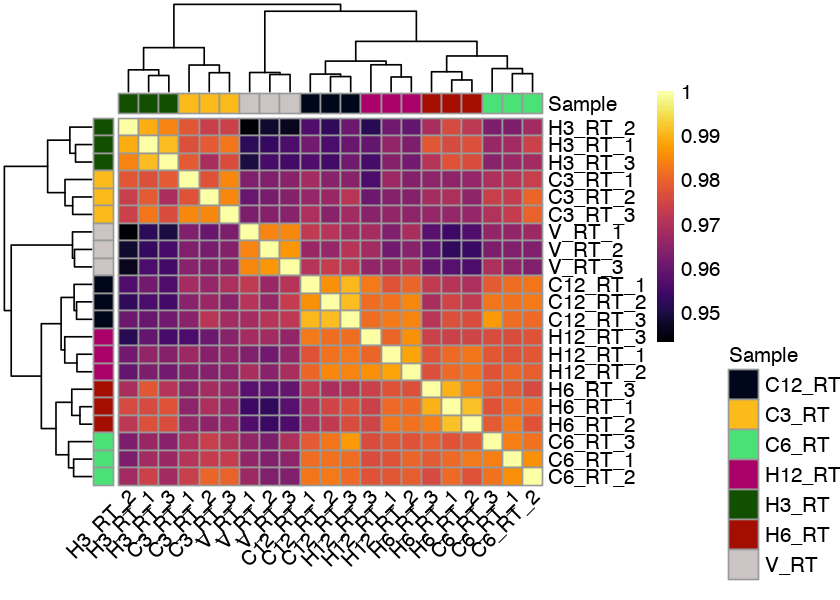

In [132]:
## Plot sample correlation
data = log2(RUVrNormalizedCounts+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

cor_colors <- list(Sample = c("#00071b","#fbbc1b","#4be177","#aa0067","#134f00","#a40e00","#ccc4c4"))
names(cor_colors$Sample) <- unique(sampleColLabeling$Sample)

options(repr.plot.width = 7, repr.plot.height = 5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(100),
#   border_color      = NA,
  annotation_col    = sampleColLabeling,
  annotation_row    = sampleColLabeling,
  drop_levels       = TRUE,
  annotation_colors = cor_colors,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
  annotation_names_row = F,
#   filename          = "Results/Figures/repTract_postmating_sample_correlations.pdf",
#   width             = 7, 
#   height            = 5,
  fontsize          = 12    
)

MDS plot:

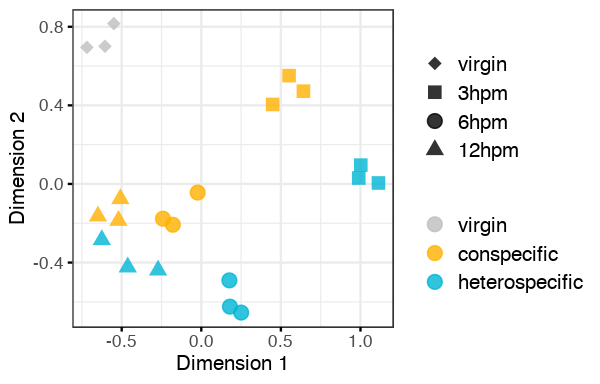

In [133]:
x <- DGEList(counts = RUVrNormalizedCounts, group = groups.pmb)
suppressWarnings(x <- calcNormFactors(x))
x <- estimateGLMCommonDisp(x, design.pmb)
x <- estimateGLMTagwiseDisp(x, design.pmb)
x <- estimateGLMTrendedDisp(x, design.pmb)

mdsObj <- plotMDS(x, plot = F)$cmdscale.out
mdsObj <- as.data.frame(as.matrix(mdsObj))
mdsObj$replicate <- rownames(mdsObj)
colnames(mdsObj) = c("dim1", "dim2", "replicate")
mdsObj = merge(mdsObj, sampleInfo.pmv, by.x = "replicate", by.y = "Replicate")
mdsObj$Time = factor(mdsObj$Time, levels = c ("virgin", "3hpm", "6hpm", "12hpm"))
mdsObj$Status = factor(mdsObj$Status, levels = c ("virgin", "conspecific", "heterospecific"))


options(repr.plot.width = 5, repr.plot.height = 3.2)
ggscatter(mdsObj,
              x = "dim1", 
              y = "dim2",
              color = "Status",
              shape = "Time",
              size = 3.5,
              alpha = 0.8, 
#               ellipse = T, 
#               mean.point = T,
#               star.plot = TRUE,
              ggtheme = theme_bw(),
              repel = "Time",) + 
#                 stat_conf_ellipse(aes(color = Time, fill = Time), alpha = 0.1, geom = "polygon") + 
                theme(axis.text = element_text(size = 10), legend.title = element_blank(), axis.title = element_text(size = 12), legend.text = element_text(size = 12)) +
#                 theme_black_full() +
                scale_colour_manual(values = c("gray", "#ffb200","#00b5d4" )) +
                scale_fill_manual(values = c("#00c28f","#e93c00","#1c8200","#bda2ff")) +
                scale_shape_manual(values = c(18, 15, 19, 17)) +
#                 scale_x_continuous(limits = c(-1, 1.25)) +
#                 scale_y_continuous(limits = c(-0.75, 0.75)) +
                labs ( x = "Dimension 1", y = "Dimension 2")

ggsave("Results/Figures/repTract_postmating_MDS.pdf", width = 5, height = 3)

Let's add the annotation information to this fit object:

In [134]:
# Extract annotation for genes in the fit object
ann.pmv = subset(Annots, FBgn_ID %in% rownames(dgeList.pmv_fit))
ann.pmv = subset(ann.pmv, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.pmv = data.frame(lapply(ann.pmv, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.pmv = ann.pmv[match(rownames(dgeList.pmv_fit), ann.pmv$FBgn_ID),]
# convert factors to characters, again
ann.pmv <- data.frame(lapply(ann.pmv, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.pmv) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.pmv$GeneID==rownames(dgeList.pmv_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.pmv_fit$genes = ann.pmv


TRUE 
7215 

In [135]:
# Extract annotation for genes in the fit object
ann.pmb = subset(Annots, FBgn_ID %in% rownames(dgeList.pmb_fit))
ann.pmb = subset(ann.pmb, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.pmb = data.frame(lapply(ann.pmb, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.pmb = ann.pmb[match(rownames(dgeList.pmb_fit), ann.pmb$FBgn_ID),]
# convert factors to characters, again
ann.pmb <- data.frame(lapply(ann.pmb, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.pmb) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.pmb$GeneID==rownames(dgeList.pmb_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.pmb_fit$genes = ann.pmb


TRUE 
7215 

##### DE between con- and heterospecific samples at each time-point:

To perform pairwise differential expression tests between postmating samples, we need to set up a series of contrasts for the DE test:

In [136]:
time.3hpm <- makeContrasts(C3.vs.H3=H3_RT-C3_RT, levels=design_2.pmb)
time.6hpm <- makeContrasts(C6.vs.H6=H6_RT-C6_RT, levels=design_2.pmb)
time.12hpm <- makeContrasts(C12.vs.H12=H12_RT-C12_RT, levels=design_2.pmb)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the genes with the relevant DE stats.

In [156]:
lrt.pmb.3h <- glmQLFTest(dgeList.pmb_fit, contrast = time.3hpm)
lrt.pmb.3h.tTags <- topTags(lrt.pmb.3h, n = NULL)
lrt.pmb.3h.tTags.table <- lrt.pmb.3h.tTags$table
sig.het_up.3hpm_list<-subset(lrt.pmb.3h.tTags.table, 
                             logFC > 1 & 
                             FDR<0.05)$GeneID
sig.het_down.3hpm_list<-subset(lrt.pmb.3h.tTags.table, 
                               logFC < -1 & 
                               FDR<0.05)$GeneID

lrt.pmb.6h <- glmQLFTest(dgeList.pmb_fit, contrast = time.6hpm)
lrt.pmb.6h.tTags <- topTags(lrt.pmb.6h, n = NULL)
lrt.pmb.6h.tTags.table <- lrt.pmb.6h.tTags$table
sig.het_up.6hpm_list<-subset(lrt.pmb.6h.tTags.table, 
                             logFC > 1 & 
                             FDR<0.05)$GeneID
sig.het_down.6hpm_list<-subset(lrt.pmb.6h.tTags.table, 
                               logFC < -1 & 
                               FDR<0.05)$GeneID

lrt.pmb.12h <- glmQLFTest(dgeList.pmb_fit, contrast = time.12hpm)
lrt.pmb.12h.tTags <- topTags(lrt.pmb.12h, n = NULL)
lrt.pmb.12h.tTags.table <- lrt.pmb.12h.tTags$table
sig.het_up.12hpm_list<-subset(lrt.pmb.12h.tTags.table, 
                              logFC > 1 & 
                              FDR<0.05)$GeneID
sig.het_down.12hpm_list<-subset(lrt.pmb.12h.tTags.table, 
                                logFC < -1 & 
                                FDR<0.05)$GeneID

Let's look at the overlap between genes that are DE between con- and heterospecific samples at each time-point:

pdf 
  2

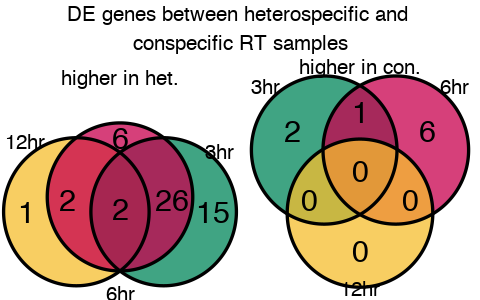

In [155]:
hetUp_candidates <- list(`3hr` = sig.het_up.3hpm_list, 
                        `6hr` = sig.het_up.6hpm_list,
                          `12hr` = sig.het_up.12hpm_list)

hetUp_Vdiag<-venn.diagram(hetUp_candidates, NULL, fill=c("#01855a","#c8004e","#f6be2e"), alpha=c(0.75,0.75,0.75), cex = 1.5, cat.fontface= 6, cat.cex = 1, resolution = 100, main = "higher in het.")

hetUp_combs <- unlist(lapply(1:length(hetUp_candidates), function(j) combn(names(hetUp_candidates), j, simplify = FALSE)), recursive = FALSE)
names(hetUp_combs) <- sapply(hetUp_combs, function(i) paste0(i, collapse = ","))
hetUp_elements <- lapply(hetUp_combs, function(i) Setdiff(hetUp_candidates[i], hetUp_candidates[setdiff(names(hetUp_candidates), i)]))

    
hetDown_candidates <- list(`3hr` = sig.het_down.3hpm_list, 
                        `6hr` = sig.het_down.6hpm_list,
                          `12hr` = sig.het_down.12hpm_list)

hetDown_Vdiag<-venn.diagram(hetDown_candidates, NULL, fill=c("#01855a","#c8004e","#f6be2e"), alpha=c(0.75,0.75,0.75), cex = 1.5, cat.fontface= 6, cat.cex = 1, resolution = 100, main = "higher in con.")

hetDown_combs <- unlist(lapply(1:length(hetDown_candidates), function(j) combn(names(hetDown_candidates), j, simplify = FALSE)), recursive = FALSE)
names(hetDown_combs) <- sapply(hetDown_combs, function(i) paste0(i, collapse = ","))
hetDown_elements <- lapply(hetDown_combs, function(i) Setdiff(hetDown_candidates[i], hetDown_candidates[setdiff(names(hetDown_candidates), i)]))

options(repr.plot.width = 4, repr.plot.height =2.5)
# summary(hetUp_elements)
grid.arrange(gTree(children=hetUp_Vdiag), gTree(children=hetDown_Vdiag), ncol = 2, top = "DE genes between heterospecific and \nconspecific RT samples")

pdf("Results/Figures/DE_het_vs_con_VennDiagram.pdf", width = 4, height = 2.5)
grid.arrange(gTree(children=hetUp_Vdiag), gTree(children=hetDown_Vdiag), ncol = 2, top = "DE genes between heterospecific and \nconspecific RT samples")
dev.off()
                           
rm(hetUp_candidates, hetUp_Vdiag, hetUp_combs)
rm(hetDown_candidates, hetDown_Vdiag, hetDown_combs)

Let's look at the QQ-plots for these contrasts:

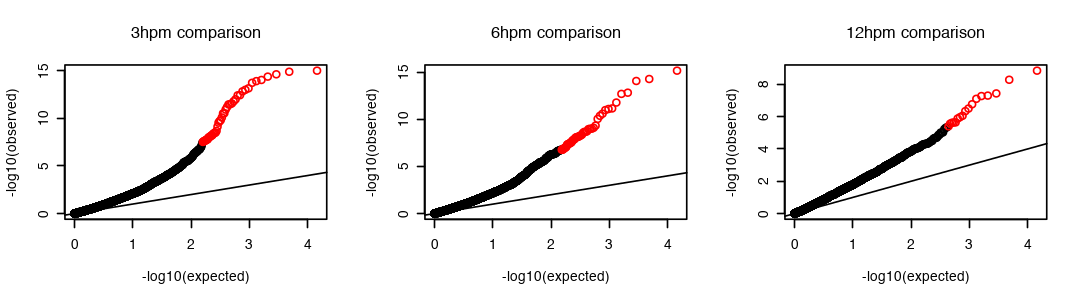

In [153]:
options(repr.plot.width = 9, repr.plot.height = 2.5)
par(mfrow=c(1,3))
plot.qq(vec = lrt.pmb.3h.tTags.table$PValue, title.str = "3hpm comparison", hit.idx = which(lrt.pmb.3h.tTags.table$FDR < 0.05 & (lrt.pmb.3h.tTags.table$logFC > 1 | lrt.pmb.3h.tTags.table$logFC < -1)))
plot.qq(vec = lrt.pmb.6h.tTags.table$PValue, title.str = "6hpm comparison", hit.idx = which(lrt.pmb.6h.tTags.table$FDR < 0.05 & (lrt.pmb.6h.tTags.table$logFC > 1 | lrt.pmb.6h.tTags.table$logFC < -1)))
plot.qq(vec = lrt.pmb.12h.tTags.table$PValue, title.str = "12hpm comparison", hit.idx = which(lrt.pmb.12h.tTags.table$FDR < 0.05 & (lrt.pmb.12h.tTags.table$logFC > 1 | lrt.pmb.12h.tTags.table$logFC < -1)))

##### DE between each con- or heterospecific sample at a given time-point and the virgin sample:

Now we'll run the contrasts between each postmating sample and the virgin sample:

In [168]:
glmT_C3.v.vir <- glmQLFTest(dgeList.pmv_fit, coef =3)
glmT_C6.v.vir <- glmQLFTest(dgeList.pmv_fit, coef =4)
glmT_C12.v.vir <- glmQLFTest(dgeList.pmv_fit, coef =2)
glmT_H3.v.vir <- glmQLFTest(dgeList.pmv_fit, coef =6)
glmT_H6.v.vir <- glmQLFTest(dgeList.pmv_fit, coef =7)
glmT_H12.v.vir <- glmQLFTest(dgeList.pmv_fit, coef =5)

Output the DE tables for the PMV contrasts:

In [169]:
DE.genes_C3.v.vir <- topTags(glmT_C3.v.vir, n = NULL)$table
DE.genes_C6.v.vir <- topTags(glmT_C6.v.vir, n = NULL)$table
DE.genes_C12.v.vir <- topTags(glmT_C12.v.vir, n = NULL)$table
DE.genes_H3.v.vir <- topTags(glmT_H3.v.vir, n = NULL)$table
DE.genes_H6.v.vir <- topTags(glmT_H6.v.vir, n = NULL)$table
DE.genes_H12.v.vir <- topTags(glmT_H12.v.vir, n = NULL)$tabl

Let's look at the QQ-plots for this contrasts:

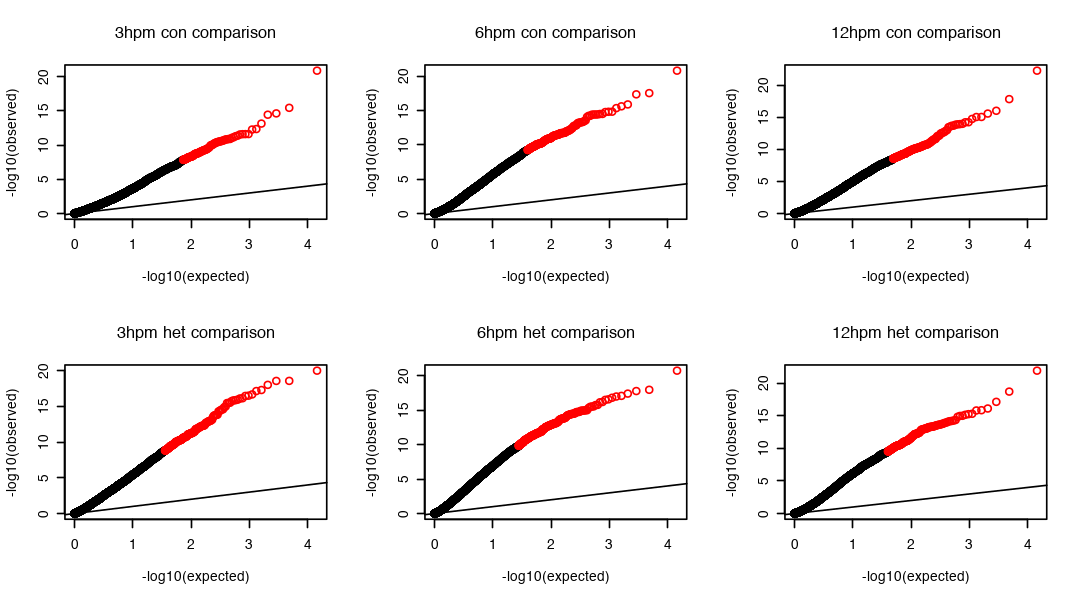

In [170]:
options(repr.plot.width = 9, repr.plot.height = 5)
par(mfrow=c(2,3))
plot.qq(vec = DE.genes_C3.v.vir$PValue, title.str = "3hpm con comparison", hit.idx = which(DE.genes_C3.v.vir$FDR < 0.05 & (DE.genes_C3.v.vir$logFC > 1 | DE.genes_C3.v.vir$logFC < -1)))
plot.qq(vec = DE.genes_C6.v.vir$PValue, title.str = "6hpm con comparison", hit.idx = which(DE.genes_C6.v.vir$FDR < 0.05 & (DE.genes_C6.v.vir$logFC > 1 | DE.genes_C6.v.vir$logFC < -1)))
plot.qq(vec = DE.genes_C12.v.vir$PValue, title.str = "12hpm con comparison", hit.idx = which(DE.genes_C12.v.vir$FDR < 0.05 & (DE.genes_C12.v.vir$logFC > 1 | DE.genes_C12.v.vir$logFC < -1)))
plot.qq(vec = DE.genes_H3.v.vir$PValue, title.str = "3hpm het comparison", hit.idx = which(DE.genes_H3.v.vir$FDR < 0.05 & (DE.genes_H3.v.vir$logFC > 1 | DE.genes_H3.v.vir$logFC < -1)))
plot.qq(vec = DE.genes_H6.v.vir$PValue, title.str = "6hpm het comparison", hit.idx = which(DE.genes_H6.v.vir$FDR < 0.05 & (DE.genes_H6.v.vir$logFC > 1 | DE.genes_H6.v.vir$logFC < -1)))
plot.qq(vec = DE.genes_H12.v.vir$PValue, title.str = "12hpm het comparison", hit.idx = which(DE.genes_H12.v.vir$FDR < 0.05 & (DE.genes_H12.v.vir$logFC > 1 | DE.genes_H12.v.vir$logFC < -1)))

Extract gene list of DE genes, first upregulated ones....

In [171]:
DE.genes_C3.v.vir_up <- subset(DE.genes_C3.v.vir, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_C6.v.vir_up <- subset(DE.genes_C6.v.vir, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_C12.v.vir_up <- subset(DE.genes_C12.v.vir, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H3.v.vir_up <- subset(DE.genes_H3.v.vir, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H6.v.vir_up <- subset(DE.genes_H6.v.vir, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H12.v.vir_up <- subset(DE.genes_H12.v.vir, FDR < 0.05 & logFC > 1)$GeneID

... and downregulated ones...

In [172]:
DE.genes_C3.v.vir_down <- subset(DE.genes_C3.v.vir, FDR < 0.05 & logFC < -1)$GeneID
DE.genes_C6.v.vir_down <- subset(DE.genes_C6.v.vir, FDR < 0.05 & logFC < -1)$GeneID
DE.genes_C12.v.vir_down <- subset(DE.genes_C12.v.vir, FDR < 0.05 & logFC < -1)$GeneID
DE.genes_H3.v.vir_down <- subset(DE.genes_H3.v.vir, FDR < 0.05 & logFC < -1)$GeneID
DE.genes_H6.v.vir_down <- subset(DE.genes_H6.v.vir, FDR < 0.05 & logFC < -1)$GeneID
DE.genes_H12.v.vir_down <- subset(DE.genes_H12.v.vir, FDR < 0.05 & logFC < -1)$GeneID

Make genes lists for the combined postmating response genes (regardless of time-point):

In [173]:
all.up.het = union(DE.genes_H3.v.vir_up, union(DE.genes_H6.v.vir_up, DE.genes_H12.v.vir_up))
all.down.het = union(DE.genes_H3.v.vir_down, union(DE.genes_H6.v.vir_down, DE.genes_H12.v.vir_down))
length(all.up.het)
length(all.down.het)

[1] 251

[1] 141

In [174]:
all.up.con = union(DE.genes_C3.v.vir_up, union(DE.genes_C6.v.vir_up, DE.genes_C12.v.vir_up))
all.down.con = union(DE.genes_C3.v.vir_down, union(DE.genes_C6.v.vir_down, DE.genes_C12.v.vir_down))
length(all.up.con)
length(all.down.con)

[1] 162

[1] 93

Let's make ven diagrams of he genes that respond to mating:

pdf 
  2

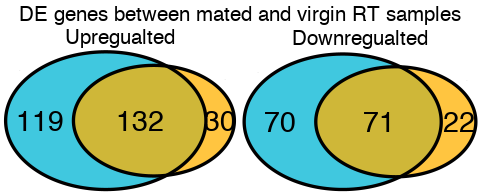

In [175]:
upReg_candidates <- list(het = all.up.het, 
                        con = all.up.con)

upReg_Vdiag<-venn.diagram(upReg_candidates, NULL, fill=c("#00b5d4", "#ffb200"), alpha=c(0.75,0.75), cex = 1.4, cat.fontface= 6, cat.cex = 0, resolution = 100, main = "Upregualted")

upReg_combs <- unlist(lapply(1:length(upReg_candidates), function(j) combn(names(upReg_candidates), j, simplify = FALSE)), recursive = FALSE)
names(upReg_combs) <- sapply(upReg_combs, function(i) paste0(i, collapse = ","))
upReg_elements <- lapply(upReg_combs, function(i) Setdiff(upReg_candidates[i], upReg_candidates[setdiff(names(upReg_candidates), i)]))


downReg_candidates <- list(het = all.down.het, 
                        con = all.down.con)

downReg_Vdiag<-venn.diagram(downReg_candidates, NULL, fill=c("#00b5d4", "#ffb200"), alpha=c(0.75,0.75), cex = 1.4, cat.fontface= 6, cat.cex = 0, resolution = 100, main = "Downregualted")

downReg_combs <- unlist(lapply(1:length(downReg_candidates), function(j) combn(names(downReg_candidates), j, simplify = FALSE)), recursive = FALSE)
names(downReg_combs) <- sapply(downReg_combs, function(i) paste0(i, collapse = ","))
downReg_elements <- lapply(downReg_combs, function(i) Setdiff(downReg_candidates[i], downReg_candidates[setdiff(names(downReg_candidates), i)]))

options(repr.plot.width = 4, repr.plot.height =1.6)
# summary(downReg_elements)
grid.arrange(gTree(children=upReg_Vdiag), gTree(children=downReg_Vdiag), ncol = 2, top = "DE genes between mated and virgin RT samples")


pdf("Results/Figures/DE_mated_vs_virgin_VennDiagram.pdf", width = 4, height = 1.6)
grid.arrange(gTree(children=upReg_Vdiag), gTree(children=downReg_Vdiag), ncol = 2, top = "DE genes between mated and virgin RT samples")
dev.off()
                           
rm(downReg_candidates, downReg_Vdiag, downReg_combs)
rm(upReg_candidates, upReg_Vdiag, upReg_combs)

##### Analysis of upregulated genes in the female RT:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [176]:
RT_upregulated_genes = unique(union(all.up.het, all.up.con))
message(paste("There are ", length(RT_upregulated_genes), " upregulated genes", sep =""))
RT_upregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% RT_upregulated_genes)

RT_upregulated_genes_matrix = RT_upregulated_genes_matrix[ , grepl("RT", names(RT_upregulated_genes_matrix))]
RT_upregulated_genes_matrix_con = subset(RT_upregulated_genes_matrix, select = c("Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
RT_upregulated_genes_matrix_het = subset(RT_upregulated_genes_matrix, select = c("Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

There are 281 upregulated genes


We can perform clustering of these genes by expression profile across all samples. We'll first need to estimate an appropriate number of clusters.

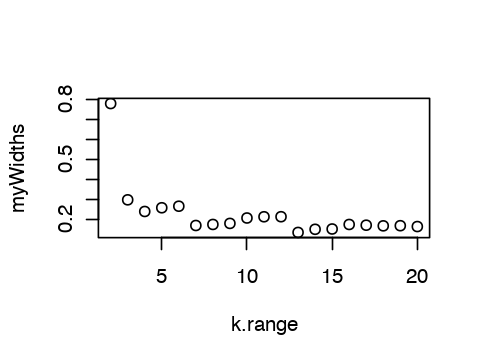

In [177]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(RT_upregulated_genes_matrix)

Cruedly, it looks like 6 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [178]:
cluster_PM_rt_up_data = setClusters(matrix = RT_upregulated_genes_matrix, k = 6)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [179]:
conSub = subset(cluster_PM_rt_up_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
hetSub = subset(cluster_PM_rt_up_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("3", df.conSub$variable), "3hpm", ifelse(grepl("6", df.conSub$variable), "6hpm", ifelse(grepl("12", df.conSub$variable), "12hpm","virgin")))
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("3", df.hetSub$variable), "3hpm", ifelse(grepl("6", df.hetSub$variable), "6hpm", ifelse(grepl("12", df.hetSub$variable), "12hpm","virgin")))
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.hetSub$crossType = "heterospecific"

rt_up_Clusters = rbind(df.conSub, df.hetSub)

We can plot it like so:

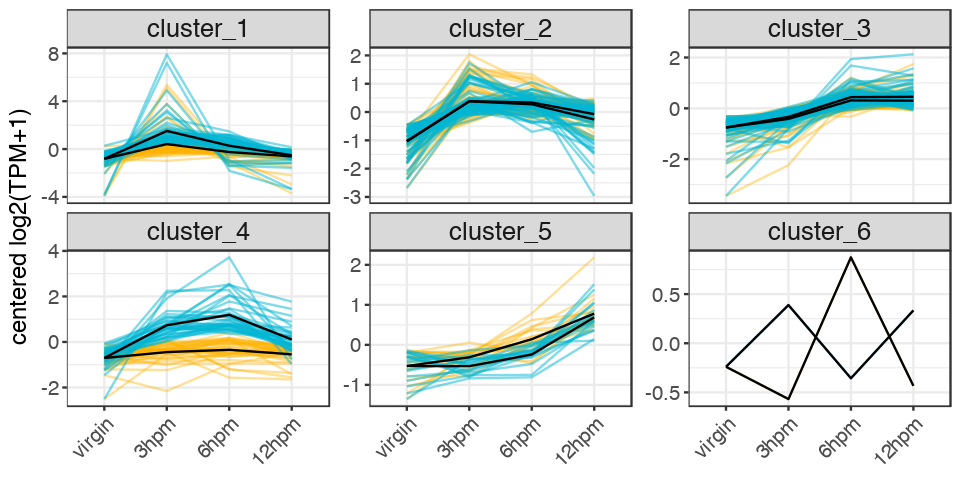

In [180]:
rt_up_Clusters$cluster = factor(rt_up_Clusters$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3", 
                                                   "cluster_4", 
                                                   "cluster_5", 
                                                   "cluster_6"))
options(repr.plot.width = 8, repr.plot.height = 4)
ggplot() + 
    geom_line(data = subset(rt_up_Clusters, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(rt_up_Clusters, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme_bw() +
    theme(axis.text.x=element_text(angle=45,hjust=1, size = 12),
         axis.text.y = element_text(size = 12),
         axis.title.x = element_blank(),
         axis.title.y = element_text(size = 14),
         strip.text = element_text(size = 15)) +
    stat_summary(data = rt_up_Clusters, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="gray",
                 alpha=0.7,
                 size=0.5,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")

ggsave("Results/Figures/repTract_postmating_K-clusters.pdf", width = 8, height = 4)

Let's output individual gene plots of all these genes, partitioned by cluster:

In [155]:
DE.genes_up_C1_pointPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_1"]), RT.genePointPlot, object = tpmTable_bt2.fbgn, show_reps = T, nonRuv = T))
ggsave("Results/Plots/k_means_clusters/DE.RT_genes_up_C1_pointPlots.pdf", marrangeGrob(grobs = DE.genes_up_C1_pointPlots, nrow = 3, ncol =2))

DE.genes_up_C2_pointPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_2"]), RT.genePointPlot, object = tpmTable_bt2.fbgn, show_reps = T, nonRuv = T))
ggsave("Results/Plots/k_means_clusters/DE.RT_genes_up_C2_pointPlots.pdf", marrangeGrob(grobs = DE.genes_up_C2_pointPlots, nrow = 3, ncol =2))

DE.genes_up_C3_pointPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_3"]), RT.genePointPlot, object = tpmTable_bt2.fbgn, show_reps = T, nonRuv = T))
ggsave("Results/Plots/k_means_clusters/DE.RT_genes_up_C3_pointPlots.pdf", marrangeGrob(grobs = DE.genes_up_C3_pointPlots, nrow = 3, ncol =2))

DE.genes_up_C4_pointPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_4"]), RT.genePointPlot, object = tpmTable_bt2.fbgn, show_reps = T, nonRuv = T))
ggsave("Results/Plots/k_means_clusters/DE.RT_genes_up_C4_pointPlots.pdf", marrangeGrob(grobs = DE.genes_up_C4_pointPlots, nrow = 3, ncol =2))

DE.genes_up_C5_pointPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_5"]), RT.genePointPlot, object = tpmTable_bt2.fbgn, show_reps = T, nonRuv = T))
ggsave("Results/Plots/k_means_clusters/DE.RT_genes_up_C5_pointPlots.pdf", marrangeGrob(grobs = DE.genes_up_C5_pointPlots, nrow = 3, ncol =2))

DE.genes_up_C6_pointPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_6"]), RT.genePointPlot, object = tpmTable_bt2.fbgn, show_reps = T, nonRuv = T))
ggsave("Results/Plots/k_means_clusters/DE.RT_genes_up_C6_pointPlots.pdf", marrangeGrob(grobs = DE.genes_up_C6_pointPlots, nrow = 3, ncol =2))

# DE.genes_up_C7_pointPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_7"]), RT.genePointPlot, object = tpmTable_bt2.fbgn, show_reps = T, nonRuv = T))
# ggsave("Results/Plots/k_means_clusters/DE.RT_genes_up_C7_pointPlots.pdf", marrangeGrob(grobs = DE.genes_up_C7_pointPlots, nrow = 3, ncol =2))

# DE.genes_up_C8_pointPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_8"]), RT.genePointPlot, object = tpmTable_bt2.fbgn, show_reps = T, nonRuv = T))
# ggsave("Results/Plots/k_means_clusters/DE.RT_genes_up_C8_pointPlots.pdf", marrangeGrob(grobs = DE.genes_up_C8_pointPlots, nrow = 3, ncol =2))

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


Output a table of the upregulated genes and their gene summaries for manual curation:

In [216]:
tmpInfo = filter(annot.sum, FBgn_ID %in% cluster_PM_rt_up_data$Gene_ID)
tmpClus = dplyr::select(cluster_PM_rt_up_data, Gene_ID, cluster)
tmpMatrix = RT_upregulated_genes_matrix
tmpMatrix$Gene_ID = rownames(tmpMatrix)
tmpInfo = merge(tmpInfo, tmpMatrix, by.x = "FBgn_ID", by.y = "Gene_ID")
tmpInfo = merge(tmpInfo, melOrthsAll, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
tmpFile = dplyr::select(melOrths, FBgn_ID, mel_FBgn_ID)
fRT_PM_upregulated_gene_snapshots = merge(tmpInfo, tmpFile, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
colnames(fRT_PM_upregulated_gene_snapshots) = gsub("Female_", "", colnames(fRT_PM_upregulated_gene_snapshots))
colnames(fRT_PM_upregulated_gene_snapshots) = gsub("_RT", "", colnames(fRT_PM_upregulated_gene_snapshots))
fRT_PM_upregulated_gene_snapshots = dplyr::select(fRT_PM_upregulated_gene_snapshots, FBgn_ID, gene_name, mel_GeneSymbol, mel_FBgn_ID, SwissProt_BlastX_Description, V, C3, C6, C12, H3, H6, H12)
fRT_PM_upregulated_gene_snapshots = unique(merge(fRT_PM_upregulated_gene_snapshots, tmpClus, by.x = "FBgn_ID", by.y = "Gene_ID"))
write.table(fRT_PM_upregulated_gene_snapshots, "Results/GeneSummaries/fRT_PM_upregulated_biased_genes_snapshots.txt", quote = F, sep = "\t", row.names = F)
rm(tmpInfo, tmpFile, tmpClus, tmpMatrix)
# nrow(fRT_PM_upregulated_gene_snapshots)

Let's look at GO enrichment across all upregulated genes:

In [183]:
cat_genes_vec = as.integer(features_with_GO %in% rt_up_Clusters$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
rt_up_enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(rt_up_enrich_result_table$category, get_GO_term_descr))
rt_up_enrich_result_table$go_term = descr

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


There's lots of term redundancy here in the Biological process category. We'll output the result, then prune with GOtrim:

In [184]:
GO_sub = subset(rt_up_enrich_result_table, over_represented_FDR < 0.05)
GO_sub_2 = subset(GO_sub, select = c("category", "numDEInCat", "numInCat"))
write.table(GO_sub_2, "Results/GO_analyses/RT_postmating_up_DE_for_pruning.txt", quote = F, sep = ",", row.names = F)

After visibly pruning, we re-load the pruned table (use thresholds of 1.0 for soft pruning):

In [185]:
GO_sub_pruned = read.csv("Results/GO_analyses/RT_postmating_up_DE_GO_trimmed_ST_threshold_1.txt", header = T, sep = ",")
pruned_GO = subset(GO_sub_pruned, Hard.Trimmed. == "YES" | Soft.Trimmed. == "YES")

And can plot them as before:

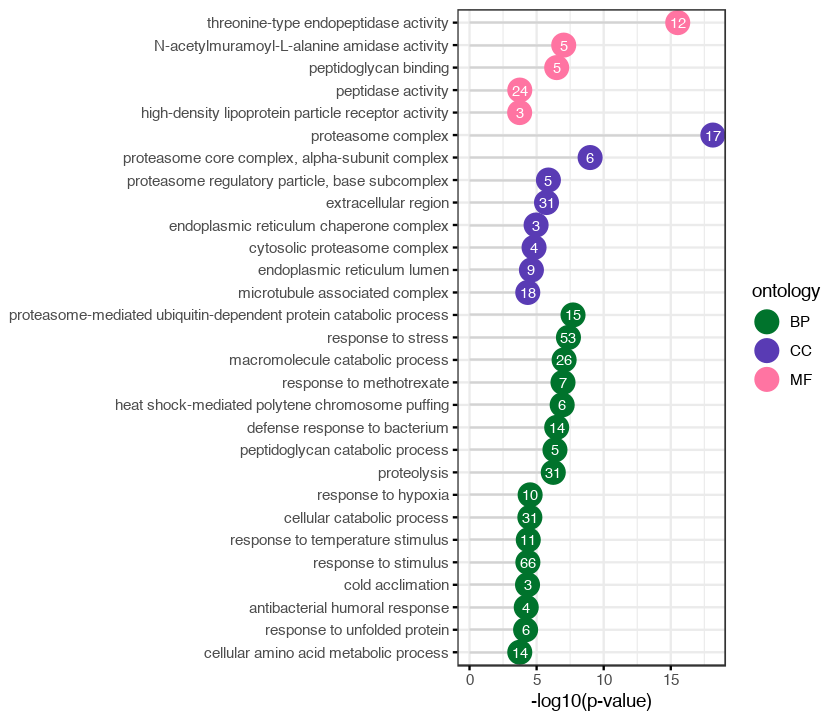

In [186]:
GOpruned = subset(GO_sub, over_represented_FDR < 0.05 & category %!in% pruned_GO$GO.Accession.No.)
GOpruned$neg_log10_FDR = -log10(GOpruned$over_represented_pvalue)

options(repr.plot.width = 7, repr.plot.height = 6)
ggdotchart(GOpruned, x = "term", y = "neg_log10_FDR",
           color = "ontology",                                # Color by groups
           palette = c("#00732c", "#593bb4", "#ff74a2"), # Custom color palette
           sorting = "descending",                       # Sort value in descending order
           add = "segments",                             # Add segments from y = 0 to dots
           rotate = TRUE,                                # Rotate vertically
           group = "ontology",                                # Order by groups
           dot.size = 6,                                 # Large dot size
           label = "numDEInCat",                        # Add mpg values as dot labels
           font.label = list(color = "white", size = 9, 
                             vjust = 0.5),               # Adjust label parameters
           ggtheme = theme_bw()                        # ggplot2 theme
           ) + labs(y = "-log10(p-value)", x = NULL)
ggsave("Results/Figures/repTract_postmating_GO_lollipop.pdf", width = 7, height = 6)


And the KEGG enrichment:

In [187]:
RTup_genes_altIDs = subset(dv1.06_features, FBgn_ID %in% rt_up_Clusters$Gene_ID)$gene_name
RTup_genes_altIDs = gsub("^", "Dvir_", RTup_genes_altIDs)
RTup_kegg <- enrichKEGG(gene = RTup_genes_altIDs, organism = 'dvi')
subset(RTup_kegg@result, qvalue < 0.05)
write.table(RTup_kegg@result, "Results/KEGG/RTup-biased_kegg_table.txt", quote = F, sep = "\t", row.names = F)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
dvi03050,dvi03050,Proteasome,19/90,60/3376,1.486667e-16,8.474000e-15,7.668070e-15,Dvir_GJ14389/Dvir_GJ14509/Dvir_GJ24473/Dvir_GJ22583/Dvir_GJ10880/Dvir_GJ10047/Dvir_GJ11606/Dvir_GJ11331/Dvir_GJ10111/Dvir_GJ17300/Dvir_GJ17695/Dvir_GJ18434/Dvir_GJ21597/Dvir_GJ20480/Dvir_GJ21921/Dvir_GJ20367/Dvir_GJ21990/Dvir_GJ20086/Dvir_GJ19383,19
dvi04141,dvi04141,Protein processing in endoplasmic reticulum,15/90,136/3376,1.904747e-06,5.428529e-05,4.912242e-05,Dvir_GJ23229/Dvir_GJ10398/Dvir_GJ10911/Dvir_GJ17455/Dvir_GJ17778/Dvir_GJ21209/Dvir_GJ21096/Dvir_GJ20512/Dvir_GJ19774/Dvir_GJ16781/Dvir_GJ16467/Dvir_GJ22515/Dvir_GJ18387/Dvir_GJ16355/Dvir_GJ14116,15
dvi00565,dvi00565,Ether lipid metabolism,4/90,23/3376,2.837194e-03,5.390670e-02,4.877984e-02,Dvir_GJ11635/Dvir_GJ11639/Dvir_GJ21785/Dvir_GJ19410,4


Now let's run the GO enrichment analysis for each cluster. First we create a factor labeling object:

In [188]:
rt_up_cluster.factor.labeling = as.data.frame(unique(subset(rt_up_Clusters, select = c("Gene_ID", "cluster"))))
row.names(rt_up_cluster.factor.labeling) <- rt_up_cluster.factor.labeling$Gene_ID
rt_up_cluster.factor.labeling = subset(rt_up_cluster.factor.labeling, select = "cluster")
rt_up_cluster.factor_list = unique(rt_up_cluster.factor.labeling[,1])
# remove cluster 8 cause it has one gene
rt_up_cluster.factor_list = subset(rt_up_cluster.factor_list, rt_up_cluster.factor_list != "cluster_6")

rt_up_GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in rt_up_cluster.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(rt_up_cluster.factor.labeling)[rt_up_cluster.factor.labeling$cluster == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    rt_up_GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))
rt_up_GO_enrichment_data = rbindlist(rt_up_GO_enriched_list)
write.table(filter(rt_up_GO_enrichment_data, over_represented_FDR < 0.05), "Results/GO_analyses/GO_results-RT_clusters_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)
unique(filter(rt_up_GO_enrichment_data, over_represented_FDR < 0.05)$factor)

[1] "cluster_2" "cluster_3" "cluster_4"

###### Proteasome complex gene expression after mating:

Proteasome complex proteins are highly over-reresented among upregulated genes. Let's plot their expression pattern in the two cross types:

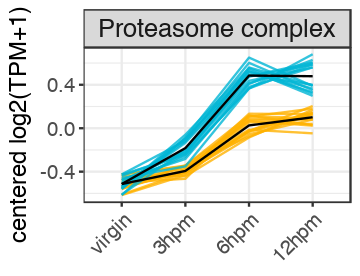

In [190]:
options(repr.plot.width = 3, repr.plot.height = 2.3)

proteasome.genes = extract_GO_genes(go_term = subset(rt_up_GO_enrichment_data, term == "proteasome complex")$category, 
                                                     gene_set = subset(rt_up_Clusters, cluster == "cluster_3")$Gene_ID)
proteasome.df = subset(rt_up_Clusters, Gene_ID %in% proteasome.genes)
proteasome.df$enrichment = "Proteasome complex"

ggplot() + 
    geom_line(data = subset(proteasome.df, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.8,
              size = 0.5) +
    geom_line(data = subset(proteasome.df, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.8,
              size = 0.5) +
    facet_wrap('enrichment',scales='free_y', nrow = 1) +
#     scale_color_hue(l=50,h.start=200) + 
    theme_bw() +
    theme(axis.text.x=element_text(angle=45,hjust=1, size = 12),
         axis.text.y = element_text(size = 12),
         axis.title.x = element_blank(),
         axis.title.y = element_text(size = 14),
         strip.text = element_text(size = 15)) +
    stat_summary(data = proteasome.df, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="gray",
                 alpha=1,
                 size=0.5,
                 geom="smooth") +
    labs(y = "centered log2(TPM+1)")

ggsave("Results/Figures/proteasome_complex_proteins.pdf", width = 3, height = 2.3)

###### Immune and JNK pathway genes that are uniquely upregulated in the heterospecific condition:

Immune genes feature prominantly among upregulated genes that are specific to the heterospecific condition. Let's make an individual gene plot for those. First, some edits for some data frame:

In [191]:
melOrthsAll$mel_GeneSymbol = gsub("CG12780, ", "", melOrthsAll$mel_GeneSymbol)
annot.sum$SwissProt_BlastX_Description = gsub("Phospholipase A2 isozymes PA3A/PA3B/PA5", "Phospholipase", annot.sum$SwissProt_BlastX_Description)

Now generate a grid plot:

In [192]:
options(repr.plot.width = 9, repr.plot.height = 5)
attacin = RT.geneBarPlot(tpmTable_bt2.fbgn, "FBgn0207711", show_reps = F) + theme(axis.text.x = element_text(angle = 0, hjust = 0.5))
defensin = RT.geneBarPlot(tpmTable_bt2.fbgn, "FBgn0209590", show_reps = F) + labs(title = "Cec2B", subtitle = "Cecropin-2") + theme(axis.text.x = element_text(angle = 0, hjust = 0.5))
cecropin = RT.geneBarPlot(tpmTable_bt2.fbgn, "FBgn0017816", show_reps = F) + labs(title = "Cec2B", subtitle = "Cecropin-2") + theme(axis.text.x = element_text(angle = 0, hjust = 0.5))
gnbp = RT.geneBarPlot(tpmTable_bt2.fbgn, "FBgn0207804", show_reps = F) + labs(title = "GNBP-like3", subtitle = "Gram-negative bacteria-binding\nprotein 3") + theme(axis.text.x = element_text(angle = 0, hjust = 0.5))
relish = RT.geneBarPlot(tpmTable_bt2.fbgn, "FBgn0210579", show_reps = F) + theme(axis.text.x = element_text(angle = 0, hjust = 0.5))

immune_genes_plots = plot_grid(attacin, defensin, cecropin, gnbp, relish, ncol = 3, align = "h")

Now combine them:

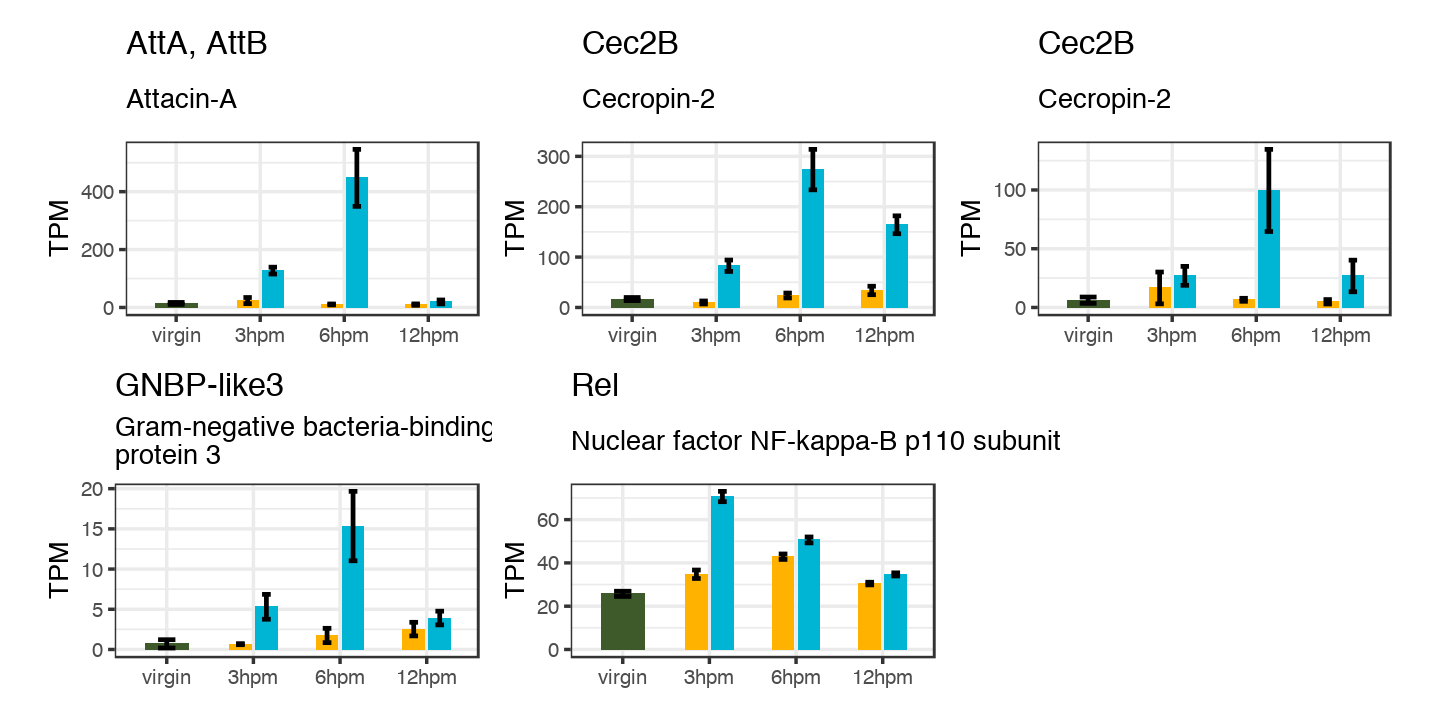

In [193]:
options(repr.plot.width = 12, repr.plot.height = 6)
plot_grid(immune_genes_plots, ncol = 1, rel_widths = c(1.33, 1), label_size = 20, scale = c(0.95, 0.95))
ggsave("Results/Figures/postmatingHet_immune_genes.pdf", width = 12, height = 6)

Also for JNK pathway genes:

In [194]:
options(repr.plot.width = 6, repr.plot.height = 5)
gadd45 = RT.geneBarPlot(tpmTable_bt2.fbgn, "FBgn0208196") + labs(title = "Gadd45", subtitle = "Growth arrest and DNA-dammage\ninducible protein") + theme(axis.text.x = element_text(angle = 0, hjust = 0.5))
ets21c = RT.geneBarPlot(tpmTable_bt2.fbgn, "FBgn0206847")+ theme(axis.text.x = element_text(angle = 0, hjust = 0.5))
GIIIspla2 = RT.geneBarPlot(tpmTable_bt2.fbgn, "FBgn0206553") + theme(axis.text.x = element_text(angle = 0, hjust = 0.5))
socs = RT.geneBarPlot(tpmTable_bt2.fbgn, "FBgn0197572")+ theme(axis.text.x = element_text(angle = 0, hjust = 0.5))
jnkStat_genes_plots = plot_grid(gadd45, ets21c, GIIIspla2, socs, ncol = 2, align = "h")

Now combine them:

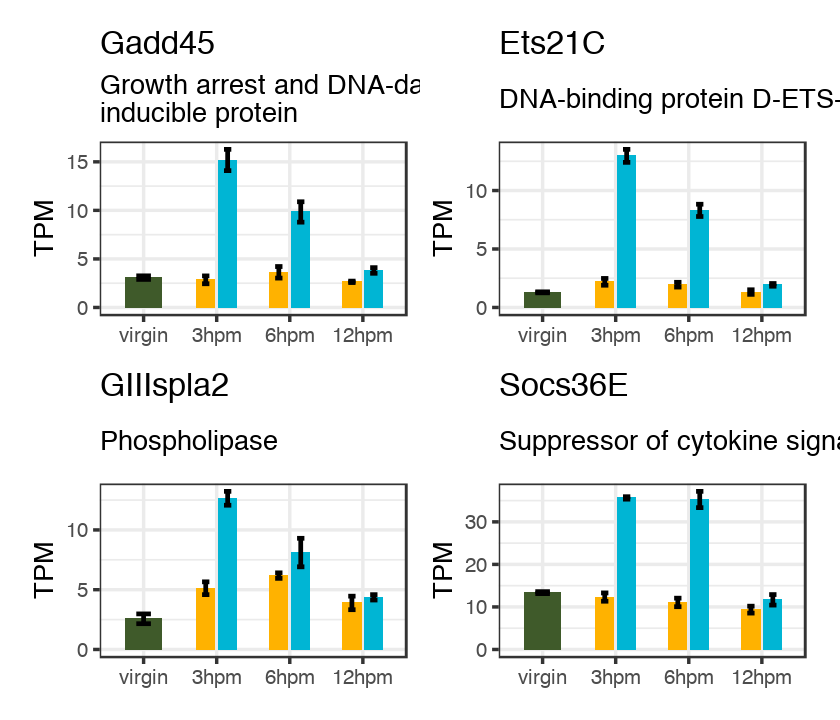

In [195]:
options(repr.plot.width = 7, repr.plot.height = 6)
plot_grid(jnkStat_genes_plots, ncol = 1, rel_widths = c(1.33, 1), label_size = 20, scale = c(0.95, 0.95)) 
ggsave("Results/Figures/postmatingHet_JAKsTAT_genes.pdf", width = 8, height = 6)

##### Analysis of downregulated genes in the female RT:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [196]:
RT_downregulated_genes = unique(unlist(c(all.down.het, all.down.con)))
message(paste("There are ", length(RT_downregulated_genes), " downregulated genes", sep =""))
RT_downregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% RT_downregulated_genes)

RT_downregulated_genes_matrix = RT_downregulated_genes_matrix[ , grepl("RT", names(RT_downregulated_genes_matrix))]
RT_downregulated_genes_matrix_con = subset(RT_downregulated_genes_matrix, select = c("Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
RT_downregulated_genes_matrix_het = subset(RT_downregulated_genes_matrix, select = c("Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

There are 163 downregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

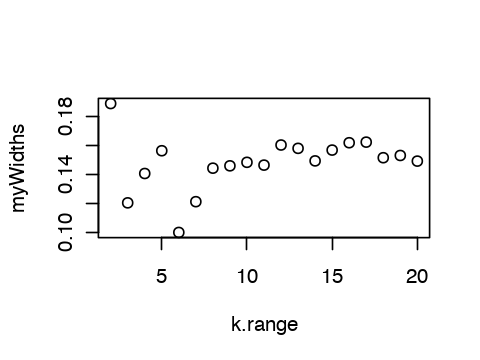

In [197]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(RT_downregulated_genes_matrix)

Not much variation in the expression profile, so probably doesn't warrant clustering.

Let's look at GO enrichment across all downregulated genes:

In [203]:
cat_genes_vec = as.integer(features_with_GO %in% RT_downregulated_genes)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
rt_down_enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(rt_down_enrich_result_table$category, get_GO_term_descr))
rt_down_enrich_result_table$go_term = descr
subset(rt_down_enrich_result_table, over_represented_FDR < 0.05)
write.table(filter(rt_down_enrich_result_table, over_represented_FDR < 0.05), "Results/GO_analyses/GO_results-RT_postmating_down_DE.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_FDR,go_term
,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>
4887,GO:0016491,5.514334e-07,0.9999999,23,700,oxidoreductase activity,MF,0.008050927,MF oxidoreductase activity
3419,GO:0008453,2.473504e-06,1.0000000,3,3,alanine-glyoxylate transaminase activity,MF,0.018056582,MF alanine-glyoxylate transaminase activity


Only two significant terms (oxidoreductase and transaminase activity). We'll flag those in the gene summaries table. For now let's output individual gene plots for all DE downregulated genes:

In [199]:
RTdown_genes_pointPlots = suppressMessages(lapply(RT_downregulated_genes, RT.genePointPlot, object = tpmTable_bt2.fbgn, show_reps = T, nonRuv = T))
ggsave("Results/Plots/k_means_clusters/DE.RT_genes_down_pointPlots.pdf", marrangeGrob(grobs = RTdown_genes_pointPlots , nrow = 3, ncol =2))

Saving 7 x 7 in image


Output a table of the downregulated genes and their gene summaries for manual curation:

In [215]:
tmpInfo = filter(annot.sum, FBgn_ID %in% RT_downregulated_genes)
tmpMatrix = RT_downregulated_genes_matrix
tmpMatrix$Gene_ID = rownames(tmpMatrix)
tmpInfo = merge(tmpInfo, tmpMatrix, by.x = "FBgn_ID", by.y = "Gene_ID")
tmpInfo = merge(tmpInfo, melOrthsAll, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
tmpFile = dplyr::select(melOrths, FBgn_ID, mel_FBgn_ID)
fRT_PM_downregulated_gene_snapshots = merge(tmpInfo, tmpFile, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
colnames(fRT_PM_downregulated_gene_snapshots) = gsub("Female_", "", colnames(fRT_PM_downregulated_gene_snapshots))
colnames(fRT_PM_downregulated_gene_snapshots) = gsub("_RT", "", colnames(fRT_PM_downregulated_gene_snapshots))
fRT_PM_downregulated_gene_snapshots = unique(dplyr::select(fRT_PM_downregulated_gene_snapshots, FBgn_ID, gene_name, mel_GeneSymbol, mel_FBgn_ID, SwissProt_BlastX_Description, V, C3, C6, C12, H3, H6, H12))
write.table(fRT_PM_downregulated_gene_snapshots, "Results/GeneSummaries/fRT_PM_downregulated_biased_genes_snapshots.txt", quote = F, sep = "\t", row.names = F)
rm(tmpInfo, tmpFile, tmpMatrix)
# nrow(unique(fRT_PM_downregulated_gene_snapshots))

## Ovaries post-mating contrasts:

Create ovaries-specific count matrix 

In [217]:
counts_bt2.fbgn.OV = subset(counts_bt2.fbgn, select=grepl("OV", colnames(counts_bt2.fbgn)))
colnames(counts_bt2.fbgn.OV) = gsub("Female_", "", colnames(counts_bt2.fbgn.OV))

Now let's filter low expression genes within a minimum cpm of 5:

In [218]:
cpm_bt2.fbgn.OV <- cpm(counts_bt2.fbgn.OV)
thresh_OV.bt2.fbgn <- cpm_bt2.fbgn.OV > 5

countsKeep_OV.bt2.fbgn <- rowSums(thresh_OV.bt2.fbgn) >= 2
countsFiltered.fbgn.OV <- round(counts_bt2.fbgn.OV[countsKeep_OV.bt2.fbgn,])
countsFiltered_bt2.fbgn.OV <- as.data.frame(lapply(countsFiltered.fbgn.OV[1:6], as.integer))
rownames(countsFiltered_bt2.fbgn.OV) <- rownames(countsFiltered.fbgn.OV)
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.OV)

## Clean-up
rm(cpm_bt2.fbgn.OV, countsKeep_OV.bt2.fbgn, thresh_OV.bt2.fbgn)

[1] 7236    6

We'll also subset the samplesInfo object to only include the RT samples:

In [219]:
sampleInfo.ov = subset(sampleInfo, Tissue == "ovaries")
sampleInfo.ov$SampleName = gsub("Female_", "", sampleInfo.ov$SampleName)
sampleInfo.ov$Replicate = gsub("Female_", "", sampleInfo.ov$Replicate)

#### Comparing each postmating time point to the virgin ovary sample and to each other:

Next we need to set a different matrix where we test for differences between conspecific and heterospecific treatments of each time point:

In [220]:
groups.ovb <- factor(sampleInfo.ov$SampleName)
design.ovb <- model.matrix(~ 0 + groups.ovb)
colnames(design.ovb) <- levels(groups.ovb)
rownames(design.ovb) <- sampleInfo.ov$Replicate

We'll control for unwanted variation with RUVseq to deal with that:

In [221]:
set.ovb <- newSeqExpressionSet(as.matrix(countsFiltered_bt2.fbgn.OV), phenoData = data.frame(groups.ovb, row.names = colnames(countsFiltered_bt2.fbgn.OV)))
set.ovb <- betweenLaneNormalization(set.ovb, which="upper")

Run an initial model fit for both sets

In [222]:
y.ovb <- DGEList(counts=counts(set.ovb), group=groups.ovb)
y.ovb <- calcNormFactors(y.ovb, method="upperquartile")
y.ovb <- estimateDisp(y.ovb, design.ovb, robust = T)
fit.ovb <- glmQLFit(y.ovb, design.ovb, dispersion = y.ovb$tagwise.dispersion, robust = T)
res.ovb <- residuals(fit.ovb, type="deviance")

Now run RUVr:

In [298]:
batch_ruv_res.ovb = RUVr(set.ovb,rownames(countsFiltered_bt2.fbgn.OV),k=1,res.ovb)

Let's output the batch-corrected counts:

In [299]:
RUVrNormalizedCounts.OV = normCounts(object = batch_ruv_res.ovb)
rownames(RUVrNormalizedCounts.OV) = rownames(countsFiltered_bt2.fbgn.OV)

Now create new design matrices with the new batch factors:

In [300]:
design_2.ovb <- model.matrix(~ 0 + groups.ovb + W_1, data=pData(batch_ruv_res.ovb))
colnames(design_2.ovb) <- gsub("groups.ovb", "", colnames(design_2.ovb))

Quick look at the samples causing batch effects (should be H3_RT_1 and H6_RT_1):

Using sample, replicate as id variables


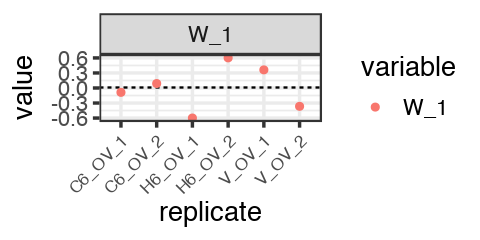

In [349]:
options(repr.plot.width = 4, repr.plot.height = 2)
batch_drivers.ov = melt(data.frame(sample = batch_ruv_res.ovb$groups.ovb, replicate = sampleInfo.ov$Replicate, W_1 = batch_ruv_res.ovb$W_1))
ggplot(batch_drivers.ov, aes(replicate, value, colour = variable)) + geom_hline(yintercept = 0, linetype = "dashed") + geom_point() + facet_wrap(~variable) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 10))

With the RUVseq adjusted counts, we're going to need a new TPM table:

In [303]:
tmpLengths = subset(a.gene_lengths, rownames(a.gene_lengths) %in% rownames(RUVrNormalizedCounts.OV))
RUVrNormalizedTPM.OV = tpm(counts = RUVrNormalizedCounts.OV, lengths = tmpLengths$length)

Make a new TPM table and mean matrix as well:

In [304]:
## For annotated bt2 data
TPMmatrix <- RUVrNormalizedTPM.OV
TPMmatrix.m <- as.data.frame(melt(as.matrix(TPMmatrix)))
TPMmatrix.m = merge(TPMmatrix.m, sampleInfo.ov, by.x = "X2", "Replicate")
TPMmatrix.m = select(TPMmatrix.m, X2, X1, value, SampleName, Status, Time)
colnames(TPMmatrix.m) <- c("replicate_id", "FBgn_ID", "TPM", "sample", "Status", "Time")
tpmTable_RUVrNormalized.fbgn.OV = merge(TPMmatrix.m, fbgn_to_geneName, by.x = "FBgn_ID", by.y = "FBgn_ID")
rm(TPMmatrix.m, TPMmatrix)

tmpMat<-cast(tpmTable_RUVrNormalized.fbgn.OV, FBgn_ID~sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_RUVrNormalized.fbgn.OV <- tmpMat[,-1]
rownames(tpmMatrix_RUVrNormalized.fbgn.OV) <- tmpMat[,1]
rm(tmpMat)

Create edgeR DE object and run glmFit

In [305]:
dgeList.ov <- DGEList(counts = counts(set.ovb), group = groups.ovb)
dgeList.ov <- calcNormFactors(dgeList.ov)
dgeList.ov <- estimateGLMCommonDisp(dgeList.ov, design_2.ovb)
dgeList.ov <- estimateGLMTagwiseDisp(dgeList.ov, design_2.ovb)
dgeList.ov <- estimateGLMTrendedDisp(dgeList.ov, design_2.ovb)
dgeList.ov_fit <- glmQLFit(dgeList.ov, design_2.ovb, dispersion = dgeList.ov$tagwise.dispersion)

Let's add the annotation information to this fit object:

In [306]:
# Extract annotation for genes in the fit object
ann.ov = subset(Annots, FBgn_ID %in% rownames(dgeList.ov_fit))
ann.ov = subset(ann.ov, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.ov = data.frame(lapply(ann.ov, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.ov = ann.ov[match(rownames(dgeList.ov_fit), ann.ov$FBgn_ID),]
# convert factors to characters, again
ann.ov <- data.frame(lapply(ann.ov, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.ov) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.ov$GeneID==rownames(dgeList.ov_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.ov_fit$genes = ann.ov


TRUE 
7236 

Also, check the tagwise dispersion summary:

In [307]:
summary(dgeList.ov$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01200 0.01246 0.01296 0.01587 0.01413 0.90681 

Again, quick look at the BCV, mean-variance trend, qq-plot and normalized count distributions.

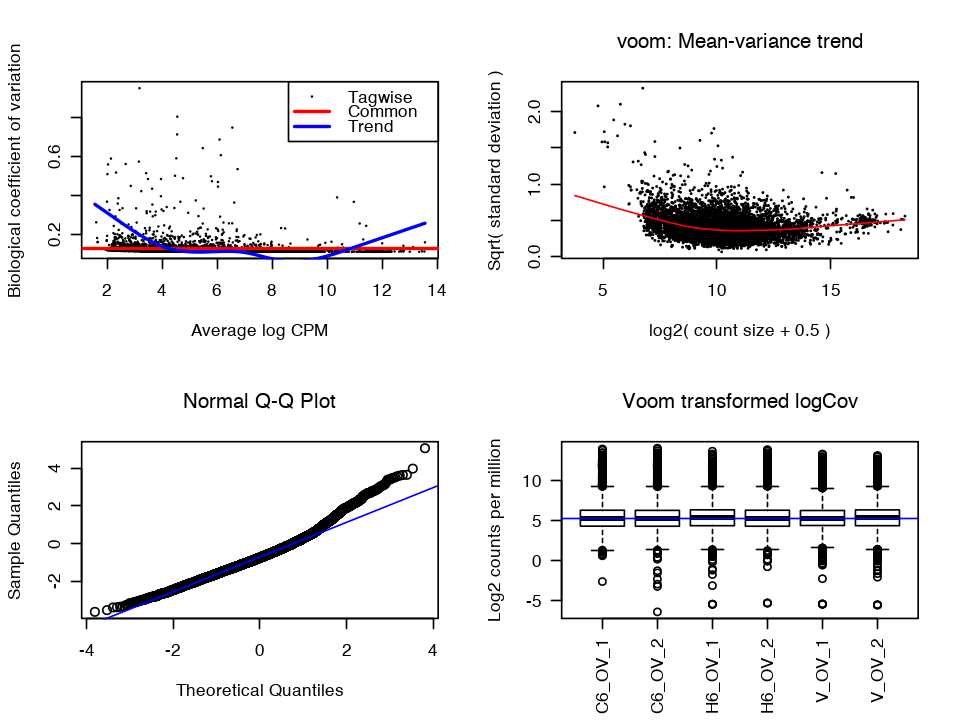

In [308]:
options(repr.plot.width = 8, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.ov)
# mean-variance trend
ov.voom = voom(dgeList.ov, design.ovb, plot=TRUE)
# QQ-plot
g.ov <- gof(dgeList.ov_fit)
z.ov <- zscoreGamma(g.ov$gof.statistics,shape=g.ov$df/2,scale=2)
qqnorm(z.ov); qqline(z.ov, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(ov.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCov")
abline(h=median(ov.voom$E),col="blue")

Sample correlations:

In [309]:
sampleColLabeling = subset(sampleInfo.ov, select = c("SampleName", "Replicate"))
rownames(sampleColLabeling) = sampleColLabeling$Replicate
sampleColLabeling = subset(sampleColLabeling, select = SampleName)
colnames(sampleColLabeling) = "Sample"
sampleColLabeling$Sample = factor(sampleColLabeling$Sample, levels = c("V_OV", "C6_OV", "H6_OV"))

Now plot it:

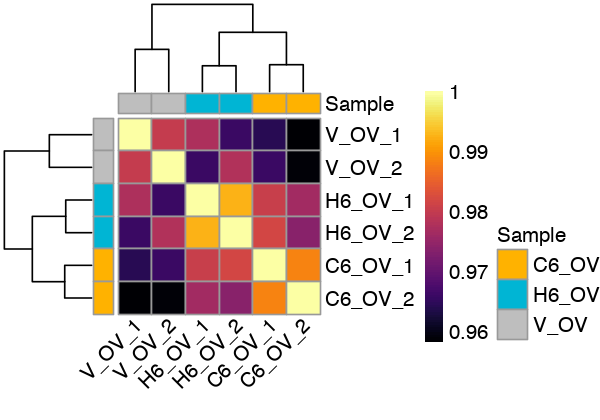

In [351]:
## Plot sample correlation
data = log2(RUVrNormalizedCounts.OV+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

cor_colors <- list(Sample = c("#ffb200","#00b5d4","gray"))
names(cor_colors$Sample) <- unique(sampleColLabeling$Sample)

options(repr.plot.width = 5, repr.plot.height = 3.5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(100),
#   border_color      = NA,
  annotation_col    = sampleColLabeling,
  annotation_row    = sampleColLabeling,
  drop_levels       = TRUE,
  annotation_colors = cor_colors,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
  annotation_names_row = F,
#   filename          = "Results/Figures/ovaries_postmating_sample_correlations.pdf",
#   width             = 5, 
#   height            = 3.5,
  fontsize          = 12    
)

MDS plot:

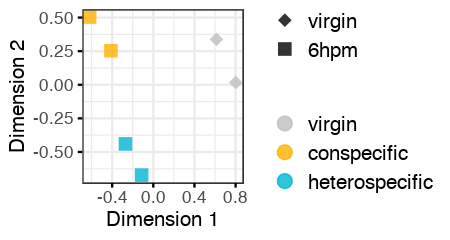

In [312]:
x <- DGEList(counts = RUVrNormalizedCounts.OV, group = groups.ovb)
suppressWarnings(x <- calcNormFactors(x))
x <- estimateGLMCommonDisp(x, design.ovb)
x <- estimateGLMTagwiseDisp(x, design.ovb)
x <- estimateGLMTrendedDisp(x, design.ovb)

mdsObj <- plotMDS(x, plot = F)$cmdscale.out
mdsObj <- as.data.frame(as.matrix(mdsObj))
mdsObj$replicate <- rownames(mdsObj)
colnames(mdsObj) = c("dim1", "dim2", "replicate")
mdsObj = merge(mdsObj, sampleInfo.ov, by.x = "replicate", by.y = "Replicate")
mdsObj$Time = factor(mdsObj$Time, levels = c ("virgin", "6hpm"))
mdsObj$Status = factor(mdsObj$Status, levels = c ("virgin", "conspecific", "heterospecific"))


options(repr.plot.width = 3.75, repr.plot.height = 2)
ggscatter(mdsObj,
              x = "dim1", 
              y = "dim2",
              color = "Status",
              shape = "Time",
              size = 3.5,
              alpha = 0.8, 
#               ellipse = T, 
#               mean.point = T,
#               star.plot = TRUE,
              ggtheme = theme_bw(),
              repel = "Time",) + 
#                 stat_conf_ellipse(aes(color = Time, fill = Time), alpha = 0.1, geom = "polygon") + 
                theme(axis.text = element_text(size = 10), legend.title = element_blank(), axis.title = element_text(size = 12), legend.text = element_text(size = 12)) +
#                 theme_black_full() +
                scale_colour_manual(values = c("gray", "#ffb200","#00b5d4" )) +
#                 scale_fill_manual(values = c("#00c28f","#e93c00","#1c8200","#bda2ff")) +
                scale_shape_manual(values = c(18, 15, 19, 17)) +
#                 scale_x_continuous(limits = c(-1, 1.25)) +
#                 scale_y_continuous(limits = c(-0.75, 0.75)) +
                labs ( x = "Dimension 1", y = "Dimension 2")

ggsave("Results/Figures/ovaries_postmating_MDS.pdf", width = 3.75, height = 2)

To perform pairwise differential expression tests between postmating samples and the virgin sample, we can run glmTreat by specifying the coefficient (have to look at the matrix), and only capture genes with >2-fold expression difference. First set some contrasts:

In [313]:
het.v.vir_ov <- makeContrasts(hOV.vs.vOV=H6_OV-V_OV, levels=design_2.ovb)
con.v.vir_ov <- makeContrasts(cOV.vs.vOV=C6_OV-V_OV, levels=design_2.ovb)
het.v.con_ov <- makeContrasts(hOV.vs.cOV=H6_OV-C6_OV, levels=design_2.ovb)

Now the individual comparisons between postmating samples and virgin:

In [314]:
lrt_ov_het.v.vir <- glmQLFTest(dgeList.ov_fit, contrast = het.v.vir_ov)
lrt_ov_het.v.vir.tTags <- topTags(lrt_ov_het.v.vir, n = NULL)
lrt_ov_het.v.vir.tTags.table <- lrt_ov_het.v.vir.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
OV_het.v.vir.list_up<-subset(lrt_ov_het.v.vir.tTags.table, logFC > 1 & FDR<0.05)$GeneID
OV_het.v.vir.list_down<-subset(lrt_ov_het.v.vir.tTags.table, logFC < -1 & FDR<0.05)$GeneID
OV_het.v.vir.list <- union(OV_het.v.vir.list_up, OV_het.v.vir.list_down)

paste(length(OV_het.v.vir.list_up), " genes are upregulated in the heterospecific cross, and ", length(OV_het.v.vir.list_down), " are downregualted" ,sep = "")

[1] "23 genes are upregulated in the heterospecific cross, and 4 are downregualted"

In [315]:
lrt_ov_con.v.vir <- glmQLFTest(dgeList.ov_fit, contrast = con.v.vir_ov)
lrt_ov_con.v.vir.tTags <- topTags(lrt_ov_con.v.vir, n = NULL)
lrt_ov_con.v.vir.tTags.table <- lrt_ov_con.v.vir.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
OV_con.v.vir.list_up<-subset(lrt_ov_con.v.vir.tTags.table, logFC > 1 & FDR<0.05)$GeneID
OV_con.v.vir.list_down<-subset(lrt_ov_con.v.vir.tTags.table, logFC < -1 & FDR<0.05)$GeneID
OV_con.v.vir.list <- union(OV_con.v.vir.list_up, OV_con.v.vir.list_down)

paste(length(OV_con.v.vir.list_up), " genes are upregulated in the conspecific cross, and ", length(OV_con.v.vir.list_down), " are downregualted" ,sep = "")

[1] "96 genes are upregulated in the conspecific cross, and 25 are downregualted"

In [316]:
lrt_ov_het.v.con <- glmQLFTest(dgeList.ov_fit, contrast = het.v.con_ov)
lrt_ov_het.v.con.tTags <- topTags(lrt_ov_het.v.con, n = NULL)
lrt_ov_het.v.con.tTags.table <- lrt_ov_het.v.con.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
OV_het.v.con.list_up<-subset(lrt_ov_het.v.con.tTags.table, logFC > 1 & FDR<0.05)$GeneID
OV_het.v.con.list_down<-subset(lrt_ov_het.v.con.tTags.table, logFC < -1 & FDR<0.05)$GeneID

paste(length(OV_het.v.con.list_up), " genes are upregulated in the heterospecific cross compared to conspecific, and ", length(OV_het.v.con.list_down), " are downregualted" ,sep = "")

[1] "1 genes are upregulated in the heterospecific cross compared to conspecific, and 11 are downregualted"

##### Analysis of upregulated genes in the female ovary:

First we'll look at those genes that are upregulated in ovaries across the two postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [317]:
OV_upregulated_genes = unique(c(OV_het.v.vir.list_up, OV_con.v.vir.list_up))
message(paste("There are ", length(OV_upregulated_genes), " upregulated genes", sep =""))
OV_upregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% OV_upregulated_genes)

OV_upregulated_genes_matrix = OV_upregulated_genes_matrix[ , grepl("OV", names(OV_upregulated_genes_matrix))]
OV_upregulated_genes_matrix_con = subset(OV_upregulated_genes_matrix, select = c("Female_V_OV", "Female_C6_OV"))
OV_upregulated_genes_matrix_het = subset(OV_upregulated_genes_matrix, select = c("Female_V_OV", "Female_H6_OV"))

There are 100 upregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

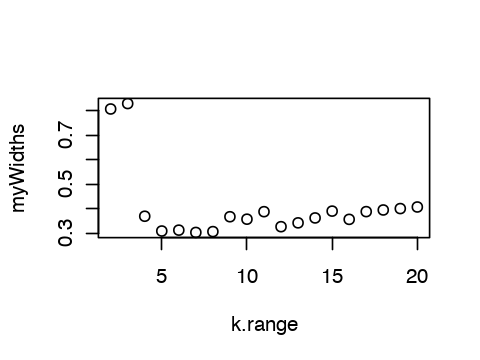

In [318]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(OV_upregulated_genes_matrix)

Cruedly, it looks like 3 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [319]:
data = OV_upregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=3)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [320]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

We'll loop over the cluster assignments and import them into the cluster list object:

In [321]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_OV_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [322]:
conSub = subset(cluster_OV_data, select = c("Gene_ID", "cluster", "Female_V_OV", "Female_C6_OV"))
hetSub = subset(cluster_OV_data, select = c("Gene_ID", "cluster", "Female_V_OV", "Female_H6_OV"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("6", df.conSub$variable), "6hpm", "virgin")
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "6hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("6", df.hetSub$variable), "6hpm", "virgin")
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "6hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

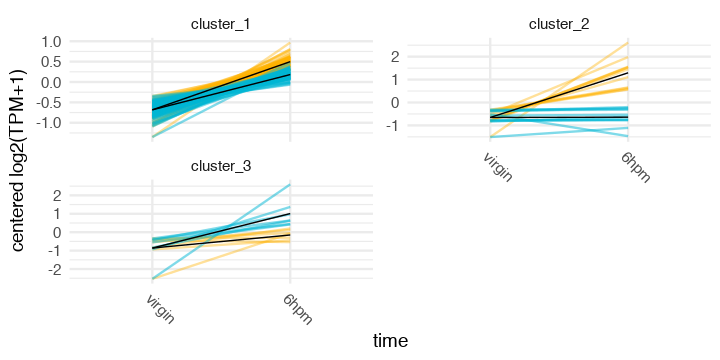

In [323]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3"))
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("cluster_groupings.pdf", width = 5, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

We can output the signficant GO results for those clusters here. First we'll make a factor level object:

In [324]:
cluster.factor.labeling = as.data.frame(unique(subset(newSub, select = c("Gene_ID", "cluster"))))
row.names(cluster.factor.labeling) <- cluster.factor.labeling$Gene_ID
cluster.factor.labeling = subset(cluster.factor.labeling, select = "cluster")
cluster.factor_list = unique(cluster.factor.labeling[,1])

In [325]:
GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in cluster.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(cluster.factor.labeling)[cluster.factor.labeling$cluster == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))
GO_enrichment_data = rbindlist(GO_enriched_list)
write.table(filter(GO_enrichment_data, over_represented_FDR < 0.05), "Results/GO_analyses/GO_results-ovary_clusters_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)
unique(filter(GO_enrichment_data, over_represented_FDR < 0.05)$factor)

[1] "cluster_1" "cluster_2" "cluster_3"

Let's look at GO enrichment across all upregulated genes:

In [326]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
write.table(filter(enrich_result_table, over_represented_FDR < 0.05), "Results/GO_analyses/GO_results-ovary_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


##### Analysis of downregulated genes in the female ovary:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [327]:
OV_downregulated_genes = unique(c(OV_het.v.vir.list_down, OV_con.v.vir.list_down))
message(paste("There are ", length(OV_downregulated_genes), " downregulated genes", sep =""))
OV_downregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% OV_downregulated_genes)

OV_downregulated_genes_matrix = OV_downregulated_genes_matrix[ , grepl("OV", names(OV_downregulated_genes_matrix))]
OV_downregulated_genes_matrix_con = subset(OV_downregulated_genes_matrix, select = c("Female_V_OV", "Female_C6_OV"))
OV_downregulated_genes_matrix_het = subset(OV_downregulated_genes_matrix, select = c("Female_V_OV", "Female_H6_OV"))

There are 29 downregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

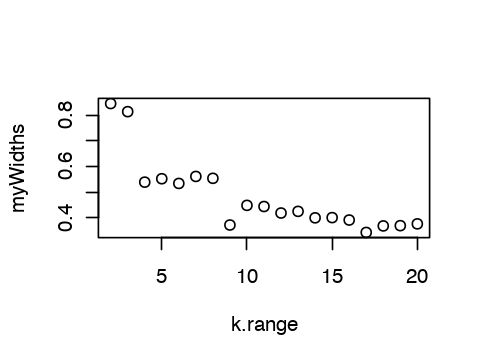

In [328]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(OV_downregulated_genes_matrix)

Cruedly, it looks like 3 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [329]:
data = OV_downregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=4)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [330]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

We'll loop over the cluster assignments and import them into the cluster list object:

In [331]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_OV_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [332]:
conSub = subset(cluster_OV_data, select = c("Gene_ID", "cluster", "Female_V_OV", "Female_C6_OV"))
hetSub = subset(cluster_OV_data, select = c("Gene_ID", "cluster", "Female_V_OV", "Female_H6_OV"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("6", df.conSub$variable), "6hpm", "virgin")
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "6hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("6", df.hetSub$variable), "6hpm", "virgin")
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "6hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

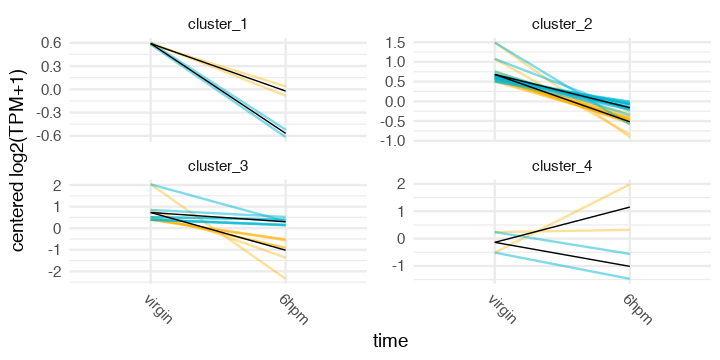

In [333]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3",
                                                    "cluster_4"))
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("cluster_groupings.pdf", width = 5, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

We can output the signficant GO results for those clusters here. First we'll make a factor level object:

In [334]:
cluster.factor.labeling = as.data.frame(unique(subset(newSub, select = c("Gene_ID", "cluster"))))
# here remove cluster 3 because it chokes the script:
cluster.factor.labeling = subset(cluster.factor.labeling, cluster != "cluster_3")

row.names(cluster.factor.labeling) <- cluster.factor.labeling$Gene_ID
cluster.factor.labeling = subset(cluster.factor.labeling, select = "cluster")
cluster.factor_list = unique(cluster.factor.labeling[,1])

In [335]:
GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in cluster.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(cluster.factor.labeling)[cluster.factor.labeling$cluster == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))
GO_enrichment_data = rbindlist(GO_enriched_list)
write.table(filter(GO_enrichment_data, over_represented_FDR < 0.05), "Results/GO_analyses/GO_results-ovary_clusters_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)
unique(filter(GO_enrichment_data, over_represented_FDR < 0.05)$factor)

[1] "cluster_2"

Let's look at GO enrichment across all downregulated genes:

In [336]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
write.table(filter(enrich_result_table, over_represented_FDR < 0.05), "Results/GO_analyses/GO_results-ovary_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


Output gene summaries for ovary DE genes:

In [339]:
tmpInfo = filter(annot.sum, FBgn_ID %in% OV_upregulated_genes)
tmpMatrix = OV_upregulated_genes_matrix
tmpMatrix$Gene_ID = rownames(tmpMatrix)
tmpInfo = merge(tmpInfo, tmpMatrix, by.x = "FBgn_ID", by.y = "Gene_ID")
tmpInfo = merge(tmpInfo, melOrthsAll, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
tmpFile = dplyr::select(melOrths, FBgn_ID, mel_FBgn_ID)
OV_PM_upregulated_gene_snapshots = merge(tmpInfo, tmpFile, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
colnames(OV_PM_upregulated_gene_snapshots) = gsub("Female_", "", colnames(OV_PM_upregulated_gene_snapshots))
colnames(OV_PM_upregulated_gene_snapshots) = gsub("_OV", "", colnames(OV_PM_upregulated_gene_snapshots))
OV_PM_upregulated_gene_snapshots = unique(dplyr::select(OV_PM_upregulated_gene_snapshots, FBgn_ID, gene_name, mel_GeneSymbol, mel_FBgn_ID, SwissProt_BlastX_Description, V, C6, H6))
write.table(OV_PM_upregulated_gene_snapshots, "Results/GeneSummaries/OV_PM_upregulated_biased_genes_snapshots.txt", quote = F, sep = "\t", row.names = F)
rm(tmpInfo, tmpFile, tmpMatrix)
# nrow(unique(OV_PM_upregulated_gene_snapshots))

In [341]:
tmpInfo = filter(annot.sum, FBgn_ID %in% OV_downregulated_genes)
tmpMatrix = OV_downregulated_genes_matrix
tmpMatrix$Gene_ID = rownames(tmpMatrix)
tmpInfo = merge(tmpInfo, tmpMatrix, by.x = "FBgn_ID", by.y = "Gene_ID")
tmpInfo = merge(tmpInfo, melOrthsAll, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
tmpFile = dplyr::select(melOrths, FBgn_ID, mel_FBgn_ID)
OV_PM_downregulated_gene_snapshots = merge(tmpInfo, tmpFile, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
colnames(OV_PM_downregulated_gene_snapshots) = gsub("Female_", "", colnames(OV_PM_downregulated_gene_snapshots))
colnames(OV_PM_downregulated_gene_snapshots) = gsub("_OV", "", colnames(OV_PM_downregulated_gene_snapshots))
OV_PM_downregulated_gene_snapshots = unique(dplyr::select(OV_PM_downregulated_gene_snapshots, FBgn_ID, gene_name, mel_GeneSymbol, mel_FBgn_ID, SwissProt_BlastX_Description, V, C6, H6))
write.table(OV_PM_downregulated_gene_snapshots, "Results/GeneSummaries/OV_PM_downregulated_biased_genes_snapshots.txt", quote = F, sep = "\t", row.names = F)
rm(tmpInfo, tmpFile, tmpMatrix)
# nrow(unique(OV_PM_downregulated_gene_snapshots))

Output individual gene plots for ovary up- and downregulated genes:

In [342]:
OVdown_genes_pointPlots = suppressMessages(lapply(OV_downregulated_genes, OV.genePointPlot, object = tpmTable_bt2.fbgn, show_reps = T, nonRuv = T))
ggsave("Results/Plots/k_means_clusters/DE.OV_genes_down_pointPlots.pdf", marrangeGrob(grobs = OVdown_genes_pointPlots , nrow = 3, ncol =2))

Saving 7 x 7 in image


In [343]:
OVup_genes_pointPlots = suppressMessages(lapply(OV_upregulated_genes, OV.genePointPlot, object = tpmTable_bt2.fbgn, show_reps = T, nonRuv = T))
ggsave("Results/Plots/k_means_clusters/DE.OV_genes_up_pointPlots.pdf", marrangeGrob(grobs = OVup_genes_pointPlots , nrow = 3, ncol =2))

Saving 7 x 7 in image


### Head post-mating contrasts:

Create H-specific count matrix 

In [376]:
counts_bt2.fbgn.H = subset(counts_bt2.fbgn, select=grepl("_H_", colnames(counts_bt2.fbgn)))
colnames(counts_bt2.fbgn.H) = gsub("Female_", "", colnames(counts_bt2.fbgn.H))

Now let's filter low expression genes within a minimum cpm of 5:

In [377]:
cpm_bt2.fbgn.H <- cpm(counts_bt2.fbgn.H)
thresh_H.bt2.fbgn <- cpm_bt2.fbgn.H > 5

countsKeep_H.bt2.fbgn <- rowSums(thresh_H.bt2.fbgn) >= 2
countsFiltered.fbgn.H <- round(counts_bt2.fbgn.H[countsKeep_H.bt2.fbgn,])
countsFiltered_bt2.fbgn.H <- as.data.frame(lapply(countsFiltered.fbgn.H[1:6], as.integer))
rownames(countsFiltered_bt2.fbgn.H) <- rownames(countsFiltered.fbgn.H)
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.H)

## Clean-up
rm(cpm_bt2.fbgn.H, countsKeep_H.bt2.fbgn, thresh_H.bt2.fbgn)

[1] 8477    6

We'll also subset the samplesInfo object to only include the RT samples:

In [378]:
sampleInfo.h = subset(sampleInfo, Tissue == "head")
sampleInfo.h$SampleName = gsub("Female_", "", sampleInfo.h$SampleName)
sampleInfo.h$Replicate = gsub("Female_", "", sampleInfo.h$Replicate)

#### Comparing each postmating time point to the virgin ovary sample and to each other:

Next we need to set a different matrix where we test for differences between conspecific and heterospecific treatments of each time point:

In [379]:
groups.hb <- factor(sampleInfo.h$SampleName)
design.hb <- model.matrix(~ 0 + groups.hb)
colnames(design.hb) <- levels(groups.hb)
rownames(design.hb) <- sampleInfo.h$Replicate

We'll control for unwanted variation with RUVseq to deal with that:

In [380]:
set.hb <- newSeqExpressionSet(as.matrix(countsFiltered_bt2.fbgn.H), phenoData = data.frame(groups.hb, row.names = colnames(countsFiltered_bt2.fbgn.H)))
set.hb <- betweenLaneNormalization(set.hb, which="upper")

Run an initial model fit for both sets

In [381]:
y.hb <- DGEList(counts=counts(set.hb), group=groups.hb)
y.hb <- calcNormFactors(y.hb, method="upperquartile")
y.hb <- estimateDisp(y.hb, design.hb, robust = T)
fit.hb <- glmQLFit(y.hb, design.hb, dispersion = y.hb$tagwise.dispersion, robust = T)
res.hb <- residuals(fit.hb, type="deviance")

Now run RUVr:

In [382]:
batch_ruv_res.hb = RUVr(set.hb,rownames(countsFiltered_bt2.fbgn.H),k=1,res.hb)

Let's output the batch-corrected counts:

In [383]:
RUVrNormalizedCounts.H = normCounts(object = batch_ruv_res.hb)
rownames(RUVrNormalizedCounts.H) = rownames(countsFiltered_bt2.fbgn.H)

Now create new design matrices with the new batch factors:

In [384]:
design_2.hb <- model.matrix(~ 0 + groups.hb + W_1, data=pData(batch_ruv_res.hb))
colnames(design_2.hb) <- gsub("groups.hb", "", colnames(design_2.hb))

Quick look at the samples causing batch effects (should be H3_RT_1 and H6_RT_1):

Using sample, replicate as id variables


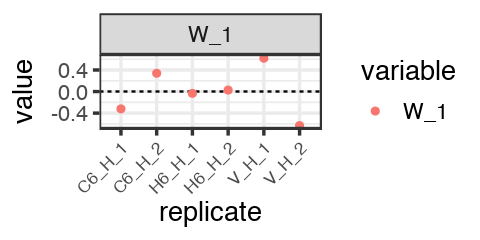

In [385]:
options(repr.plot.width = 4, repr.plot.height = 2)
batch_drivers.h = melt(data.frame(sample = batch_ruv_res.hb$groups.hb, replicate = sampleInfo.h$Replicate, W_1 = batch_ruv_res.hb$W_1))
ggplot(batch_drivers.h, aes(replicate, value, colour = variable)) + geom_hline(yintercept = 0, linetype = "dashed") + geom_point() + facet_wrap(~variable) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 10))

With the RUVseq adjusted counts, we're going to need a new TPM table:

In [386]:
tmpLengths = subset(a.gene_lengths, rownames(a.gene_lengths) %in% rownames(RUVrNormalizedCounts.H))
RUVrNormalizedTPM.H = tpm(counts = RUVrNormalizedCounts.H, lengths = tmpLengths$length)

Make a new TPM table and mean matrix as well:

In [388]:
## For annotated bt2 data
TPMmatrix <- RUVrNormalizedTPM.H
TPMmatrix.m <- as.data.frame(melt(as.matrix(TPMmatrix)))
TPMmatrix.m = merge(TPMmatrix.m, sampleInfo.h, by.x = "X2", "Replicate")
TPMmatrix.m = select(TPMmatrix.m, X2, X1, value, SampleName, Status, Time)
colnames(TPMmatrix.m) <- c("replicate_id", "FBgn_ID", "TPM", "sample", "Status", "Time")
tpmTable_RUVrNormalized.fbgn.H = merge(TPMmatrix.m, fbgn_to_geneName, by.x = "FBgn_ID", by.y = "FBgn_ID")
rm(TPMmatrix.m, TPMmatrix)

tmpMat<-cast(tpmTable_RUVrNormalized.fbgn.H, FBgn_ID~sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_RUVrNormalized.fbgn.H <- tmpMat[,-1]
rownames(tpmMatrix_RUVrNormalized.fbgn.H) <- tmpMat[,1]
rm(tmpMat)

Create edgeR DE object and run glmFit

In [389]:
dgeList.h <- DGEList(counts = counts(set.hb), group = groups.hb)
dgeList.h <- calcNormFactors(dgeList.h)
dgeList.h <- estimateGLMCommonDisp(dgeList.h, design_2.hb)
dgeList.h <- estimateGLMTagwiseDisp(dgeList.h, design_2.hb)
dgeList.h <- estimateGLMTrendedDisp(dgeList.h, design_2.hb)
dgeList.h_fit <- glmQLFit(dgeList.h, design_2.hb, dispersion = dgeList.h$tagwise.dispersion)

Let's add the annotation information to this fit object:

In [390]:
# Extract annotation for genes in the fit object
ann.h = subset(Annots, FBgn_ID %in% rownames(dgeList.h_fit))
ann.h = subset(ann.h, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.h = data.frame(lapply(ann.h, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.h = ann.h[match(rownames(dgeList.h_fit), ann.h$FBgn_ID),]
# convert factors to characters, again
ann.h <- data.frame(lapply(ann.h, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.h) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.h$GeneID==rownames(dgeList.h_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.h_fit$genes = ann.h


TRUE 
8477 

Also, check the tagwise dispersion summary:

In [391]:
summary(dgeList.h$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.007679 0.008437 0.008949 0.010858 0.009879 0.669417 

Again, quick look at the BCV, mean-variance trend, qq-plot and normalized count distributions.

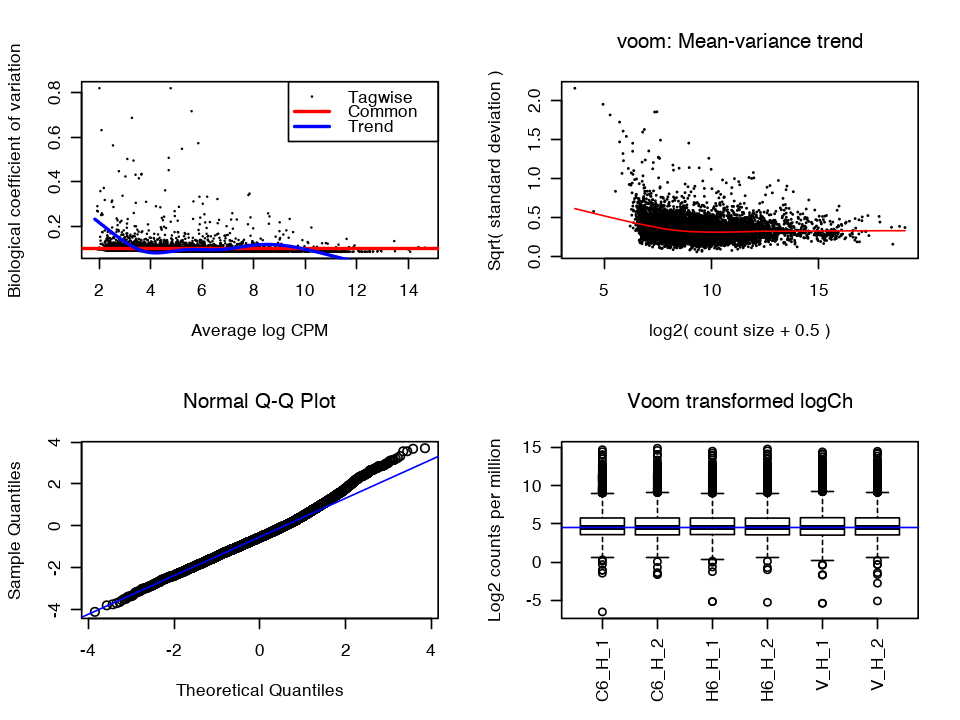

In [392]:
options(repr.plot.width = 8, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.h)
# mean-variance trend
h.voom = voom(dgeList.h, design.hb, plot=TRUE)
# QQ-plot
g.h <- gof(dgeList.h_fit)
z.h <- zscoreGamma(g.h$gof.statistics,shape=g.h$df/2,scale=2)
qqnorm(z.h); qqline(z.h, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(h.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCh")
abline(h=median(h.voom$E),col="blue")

Sample correlations:

In [393]:
sampleColLabeling = subset(sampleInfo.h, select = c("SampleName", "Replicate"))
rownames(sampleColLabeling) = sampleColLabeling$Replicate
sampleColLabeling = subset(sampleColLabeling, select = SampleName)
colnames(sampleColLabeling) = "Sample"
sampleColLabeling$Sample = factor(sampleColLabeling$Sample, levels = c("V_H", "C6_H", "H6_H"))

Now plot it:

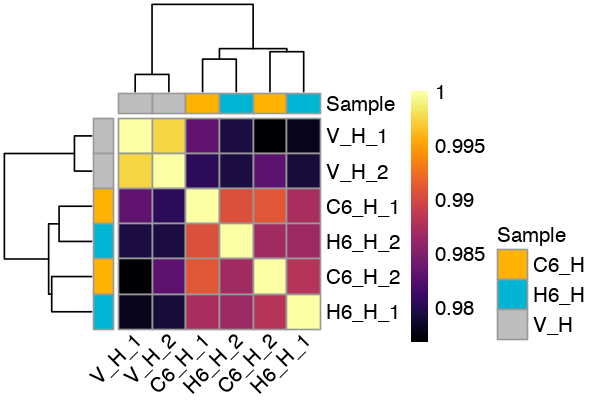

In [396]:
## Plot sample correlation
data = log2(RUVrNormalizedCounts.H+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

cor_colors <- list(Sample = c("#ffb200","#00b5d4","gray"))
names(cor_colors$Sample) <- unique(sampleColLabeling$Sample)

options(repr.plot.width = 5, repr.plot.height = 3.5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(100),
#   border_color      = NA,
  annotation_col    = sampleColLabeling,
  annotation_row    = sampleColLabeling,
  drop_levels       = TRUE,
  annotation_colors = cor_colors,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
  annotation_names_row = F,
#   filename          = "Results/Figures/haries_postmating_sample_correlations.pdf",
#   width             = 5, 
#   height            = 3.5,
  fontsize          = 12    
)

MDS plot:

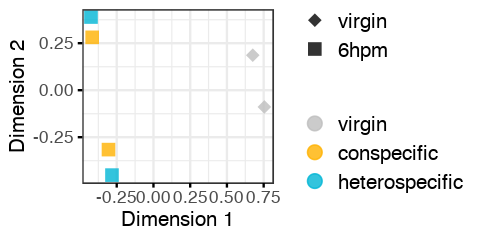

In [398]:
x <- DGEList(counts = RUVrNormalizedCounts.H, group = groups.hb)
suppressWarnings(x <- calcNormFactors(x))
x <- estimateGLMCommonDisp(x, design.hb)
x <- estimateGLMTagwiseDisp(x, design.hb)
x <- estimateGLMTrendedDisp(x, design.hb)

mdsObj <- plotMDS(x, plot = F)$cmdscale.out
mdsObj <- as.data.frame(as.matrix(mdsObj))
mdsObj$replicate <- rownames(mdsObj)
colnames(mdsObj) = c("dim1", "dim2", "replicate")
mdsObj = merge(mdsObj, sampleInfo.h, by.x = "replicate", by.y = "Replicate")
mdsObj$Time = factor(mdsObj$Time, levels = c ("virgin", "6hpm"))
mdsObj$Status = factor(mdsObj$Status, levels = c ("virgin", "conspecific", "heterospecific"))


options(repr.plot.width = 4, repr.plot.height = 2)
ggscatter(mdsObj,
              x = "dim1", 
              y = "dim2",
              color = "Status",
              shape = "Time",
              size = 3.5,
              alpha = 0.8, 
#               ellipse = T, 
#               mean.point = T,
#               star.plot = TRUE,
              ggtheme = theme_bw(),
              repel = "Time",) + 
#                 stat_conf_ellipse(aes(color = Time, fill = Time), alpha = 0.1, geom = "polygon") + 
                theme(axis.text = element_text(size = 10), legend.title = element_blank(), axis.title = element_text(size = 12), legend.text = element_text(size = 12)) +
#                 theme_black_full() +
                scale_colour_manual(values = c("gray", "#ffb200","#00b5d4" )) +
#                 scale_fill_manual(values = c("#00c28f","#e93c00","#1c8200","#bda2ff")) +
                scale_shape_manual(values = c(18, 15, 19, 17)) +
#                 scale_x_continuous(limits = c(-1, 1.25)) +
#                 scale_y_continuous(limits = c(-0.75, 0.75)) +
                labs ( x = "Dimension 1", y = "Dimension 2")

ggsave("Results/Figures/head_postmating_MDS.pdf", width = 4, height = 2)

To perform pairwise differential expression tests between postmating samples and the virgin sample, we can run glmTreat by specifying the coefficient (have to look at the matrix), and only capture genes with >2-fold expression difference. First set some contrasts:

In [400]:
het.v.vir_h <- makeContrasts(hH.vs.vH=H6_H-V_H, levels=design_2.hb)
con.v.vir_h <- makeContrasts(cH.vs.vH=C6_H-V_H, levels=design_2.hb)
het.v.con_h <- makeContrasts(hH.vs.cH=H6_H-C6_H, levels=design_2.hb)

Now the individual comparisons between postmating samples and virgin:

In [401]:
lrt_h_het.v.vir <- glmQLFTest(dgeList.h_fit, contrast = het.v.vir_h)
lrt_h_het.v.vir.tTags <- topTags(lrt_h_het.v.vir, n = NULL)
lrt_h_het.v.vir.tTags.table <- lrt_h_het.v.vir.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
H_het.v.vir.list_up<-subset(lrt_h_het.v.vir.tTags.table, logFC > 1 & FDR<0.05)$GeneID
H_het.v.vir.list_down<-subset(lrt_h_het.v.vir.tTags.table, logFC < -1 & FDR<0.05)$GeneID
H_het.v.vir.list <- union(H_het.v.vir.list_up, H_het.v.vir.list_down)

paste(length(H_het.v.vir.list_up), " genes are upregulated in the heterospecific cross, and ", length(H_het.v.vir.list_down), " are downregualted" ,sep = "")

[1] "43 genes are upregulated in the heterospecific cross, and 41 are downregualted"

In [402]:
lrt_h_con.v.vir <- glmQLFTest(dgeList.h_fit, contrast = con.v.vir_h)
lrt_h_con.v.vir.tTags <- topTags(lrt_h_con.v.vir, n = NULL)
lrt_h_con.v.vir.tTags.table <- lrt_h_con.v.vir.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
H_con.v.vir.list_up<-subset(lrt_h_con.v.vir.tTags.table, logFC > 1 & FDR<0.05)$GeneID
H_con.v.vir.list_down<-subset(lrt_h_con.v.vir.tTags.table, logFC < -1 & FDR<0.05)$GeneID
H_con.v.vir.list <- union(H_con.v.vir.list_up, H_con.v.vir.list_down)

paste(length(H_con.v.vir.list_up), " genes are upregulated in the conspecific cross, and ", length(H_con.v.vir.list_down), " are downregualted" ,sep = "")

[1] "38 genes are upregulated in the conspecific cross, and 43 are downregualted"

In [403]:
lrt_h_het.v.con <- glmQLFTest(dgeList.h_fit, contrast = het.v.con_h)
lrt_h_het.v.con.tTags <- topTags(lrt_h_het.v.con, n = NULL)
lrt_h_het.v.con.tTags.table <- lrt_h_het.v.con.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
H_het.v.con.list_up<-subset(lrt_h_het.v.con.tTags.table, logFC > 1 & FDR<0.05)$GeneID
H_het.v.con.list_down<-subset(lrt_h_het.v.con.tTags.table, logFC < -1 & FDR<0.05)$GeneID

paste(length(H_het.v.con.list_up), " genes are upregulated in the heterospecific cross compared to conspecific, and ", length(H_het.v.con.list_down), " are downregualted" ,sep = "")

[1] "1 genes are upregulated in the heterospecific cross compared to conspecific, and 0 are downregualted"

##### Analysis of upregulated genes in the female head:

First we'll look at those genes that are upregulated in ovaries across the two postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [406]:
H_upregulated_genes = unique(c(H_het.v.vir.list_up, H_con.v.vir.list_up))
message(paste("There are ", length(H_upregulated_genes), " upregulated genes", sep =""))
H_upregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% H_upregulated_genes)

H_upregulated_genes_matrix = H_upregulated_genes_matrix[ , grepl("H", names(H_upregulated_genes_matrix))]
H_upregulated_genes_matrix_con = subset(H_upregulated_genes_matrix, select = c("Female_V_H", "Female_C6_H"))
H_upregulated_genes_matrix_het = subset(H_upregulated_genes_matrix, select = c("Female_V_H", "Female_H6_H"))

There are 51 upregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

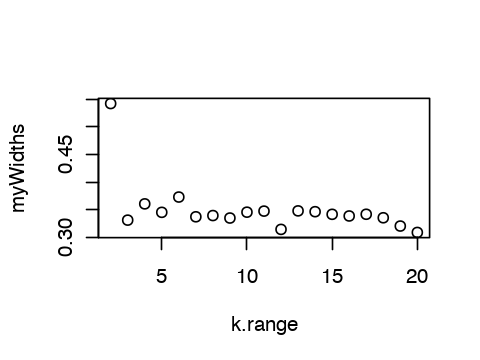

In [407]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(H_upregulated_genes_matrix)

Cruedly, it looks like 3 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [408]:
data = H_upregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=3)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [409]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

We'll loop over the cluster assignments and import them into the cluster list object:

In [410]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_H_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [411]:
conSub = subset(cluster_H_data, select = c("Gene_ID", "cluster", "Female_V_H", "Female_C6_H"))
hetSub = subset(cluster_H_data, select = c("Gene_ID", "cluster", "Female_V_H", "Female_H6_H"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("6", df.conSub$variable), "6hpm", "virgin")
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "6hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("6", df.hetSub$variable), "6hpm", "virgin")
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "6hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

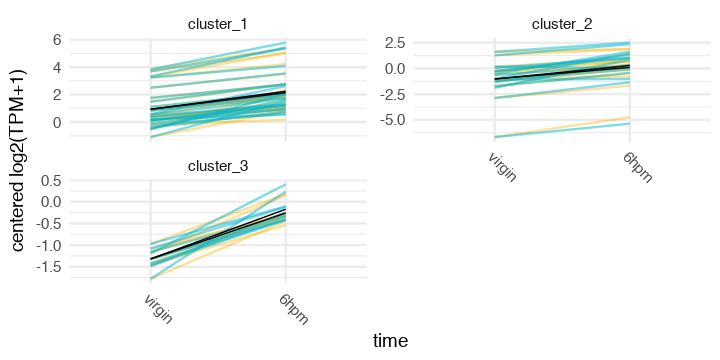

In [412]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3"))
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("cluster_groupings.pdf", width = 5, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

We can output the signficant GO results for those clusters here. First we'll make a factor level object:

In [413]:
cluster.factor.labeling = as.data.frame(unique(subset(newSub, select = c("Gene_ID", "cluster"))))
row.names(cluster.factor.labeling) <- cluster.factor.labeling$Gene_ID
cluster.factor.labeling = subset(cluster.factor.labeling, select = "cluster")
cluster.factor_list = unique(cluster.factor.labeling[,1])

In [414]:
GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in cluster.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(cluster.factor.labeling)[cluster.factor.labeling$cluster == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))
GO_enrichment_data = rbindlist(GO_enriched_list)
write.table(filter(GO_enrichment_data, over_represented_FDR < 0.05), "Results/GO_analyses/GO_results-head_clusters_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)
unique(filter(GO_enrichment_data, over_represented_FDR < 0.05)$factor)

[1] "cluster_2" "cluster_3"

Let's look at GO enrichment across all upregulated genes:

In [415]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
write.table(filter(enrich_result_table, over_represented_FDR < 0.05), "Results/GO_analyses/GO_results-head_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


##### Analysis of downregulated genes in the female head:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [416]:
H_downregulated_genes = unique(c(H_het.v.vir.list_down, H_con.v.vir.list_down))
message(paste("There are ", length(H_downregulated_genes), " downregulated genes", sep =""))
H_downregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% H_downregulated_genes)

H_downregulated_genes_matrix = H_downregulated_genes_matrix[ , grepl("H", names(H_downregulated_genes_matrix))]
H_downregulated_genes_matrix_con = subset(H_downregulated_genes_matrix, select = c("Female_V_H", "Female_C6_H"))
H_downregulated_genes_matrix_het = subset(H_downregulated_genes_matrix, select = c("Female_V_H", "Female_H6_H"))

There are 56 downregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

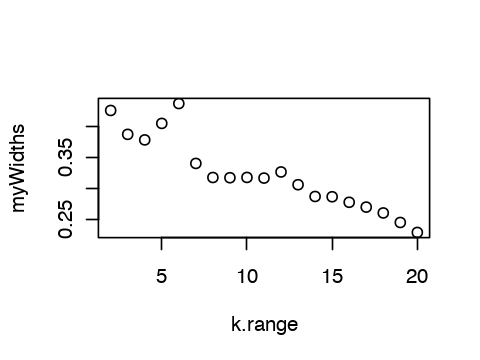

In [417]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(H_downregulated_genes_matrix)

Cruedly, it looks like 3 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [418]:
data = H_downregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=4)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [419]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

We'll loop over the cluster assignments and import them into the cluster list object:

In [420]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_H_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [421]:
conSub = subset(cluster_H_data, select = c("Gene_ID", "cluster", "Female_V_H", "Female_C6_H"))
hetSub = subset(cluster_H_data, select = c("Gene_ID", "cluster", "Female_V_H", "Female_H6_H"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("6", df.conSub$variable), "6hpm", "virgin")
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "6hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("6", df.hetSub$variable), "6hpm", "virgin")
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "6hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

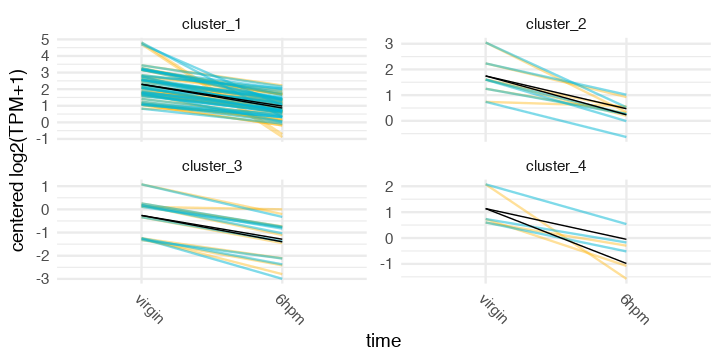

In [422]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3",
                                                    "cluster_4"))
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("cluster_groupings.pdf", width = 5, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

We can output the signficant GO results for those clusters here. First we'll make a factor level object:

In [423]:
cluster.factor.labeling = as.data.frame(unique(subset(newSub, select = c("Gene_ID", "cluster"))))

row.names(cluster.factor.labeling) <- cluster.factor.labeling$Gene_ID
cluster.factor.labeling = subset(cluster.factor.labeling, select = "cluster")
cluster.factor_list = unique(cluster.factor.labeling[,1])

In [424]:
GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in cluster.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(cluster.factor.labeling)[cluster.factor.labeling$cluster == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))
GO_enrichment_data = rbindlist(GO_enriched_list)
write.table(filter(GO_enrichment_data, over_represented_FDR < 0.05), "Results/GO_analyses/GO_results-head_clusters_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)
unique(filter(GO_enrichment_data, over_represented_FDR < 0.05)$factor)

[1] "cluster_1"

Let's look at GO enrichment across all downregulated genes:

In [425]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
write.table(filter(enrich_result_table, over_represented_FDR < 0.05), "Results/GO_analyses/GO_results-head_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


Output gene summaries for head DE genes:

In [429]:
tmpInfo = filter(annot.sum, FBgn_ID %in% H_upregulated_genes)
tmpMatrix = H_upregulated_genes_matrix
tmpMatrix$Gene_ID = rownames(tmpMatrix)
tmpInfo = merge(tmpInfo, tmpMatrix, by.x = "FBgn_ID", by.y = "Gene_ID")
tmpInfo = merge(tmpInfo, melOrthsAll, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
tmpFile = dplyr::select(melOrths, FBgn_ID, mel_FBgn_ID)
H_PM_upregulated_gene_snapshots = merge(tmpInfo, tmpFile, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
colnames(H_PM_upregulated_gene_snapshots) = gsub("Female_", "", colnames(H_PM_upregulated_gene_snapshots))
colnames(H_PM_upregulated_gene_snapshots) = gsub("_H", "", colnames(H_PM_upregulated_gene_snapshots))
H_PM_upregulated_gene_snapshots = unique(dplyr::select(H_PM_upregulated_gene_snapshots, FBgn_ID, gene_name, mel_GeneSymbol, mel_FBgn_ID, SwissProt_BlastX_Description, V, C6, H6))
write.table(H_PM_upregulated_gene_snapshots, "Results/GeneSummaries/H_PM_upregulated_biased_genes_snapshots.txt", quote = F, sep = "\t", row.names = F)
rm(tmpInfo, tmpFile, tmpMatrix)
# nrow(unique(H_PM_upregulated_gene_snapshots))

In [430]:
tmpInfo = filter(annot.sum, FBgn_ID %in% H_downregulated_genes)
tmpMatrix = H_downregulated_genes_matrix
tmpMatrix$Gene_ID = rownames(tmpMatrix)
tmpInfo = merge(tmpInfo, tmpMatrix, by.x = "FBgn_ID", by.y = "Gene_ID")
tmpInfo = merge(tmpInfo, melOrthsAll, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
tmpFile = dplyr::select(melOrths, FBgn_ID, mel_FBgn_ID)
H_PM_downregulated_gene_snapshots = merge(tmpInfo, tmpFile, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
colnames(H_PM_downregulated_gene_snapshots) = gsub("Female_", "", colnames(H_PM_downregulated_gene_snapshots))
colnames(H_PM_downregulated_gene_snapshots) = gsub("_H", "", colnames(H_PM_downregulated_gene_snapshots))
H_PM_downregulated_gene_snapshots = unique(dplyr::select(H_PM_downregulated_gene_snapshots, FBgn_ID, gene_name, mel_GeneSymbol, mel_FBgn_ID, SwissProt_BlastX_Description, V, C6, H6))
write.table(H_PM_downregulated_gene_snapshots, "Results/GeneSummaries/H_PM_downregulated_biased_genes_snapshots.txt", quote = F, sep = "\t", row.names = F)
rm(tmpInfo, tmpFile, tmpMatrix)
# nrow(unique(H_PM_downregulated_gene_snapshots))

Output individual gene plots for ovary up- and downregulated genes:

In [432]:
Hdown_genes_pointPlots = suppressMessages(lapply(H_downregulated_genes, H.genePointPlot, object = tpmTable_bt2.fbgn, show_reps = T, nonRuv = T))
ggsave("Results/Plots/k_means_clusters/DE.H_genes_down_pointPlots.pdf", marrangeGrob(grobs = Hdown_genes_pointPlots , nrow = 3, ncol =2))

Saving 7 x 7 in image


In [433]:
Hup_genes_pointPlots = suppressMessages(lapply(H_upregulated_genes, H.genePointPlot, object = tpmTable_bt2.fbgn, show_reps = T, nonRuv = T))
ggsave("Results/Plots/k_means_clusters/DE.H_genes_up_pointPlots.pdf", marrangeGrob(grobs = Hup_genes_pointPlots , nrow = 3, ncol =2))

Saving 7 x 7 in image


Now let's plot the fold-change values between the two postmating contrasts:

In [ ]:
tmp.h.Data = lrt_h_vir.v.PM.tTags.table
tmp.h.Data$sig = ifelse(tmp.h.Data$GeneID %in% H_het.v.vir.list_up & tmp.h.Data$GeneID %in% H_con.v.vir.list_up,
                     "both upregulated",
                     ifelse(tmp.h.Data$GeneID %in% H_het.v.vir.list_down & tmp.h.Data$GeneID %in% H_con.v.vir.list_down,
                            "both downregulated",
                            ifelse(tmp.h.Data$GeneID %in% H_het.v.vir.list_up & tmp.h.Data$GeneID %in% H_con.v.vir.list_down,
                                   "het. up, con. down",
                                   ifelse(tmp.h.Data$GeneID %in% H_het.v.vir.list_down & tmp.h.Data$GeneID %in% H_con.v.vir.list_up,
                                          "het. down, con. up",
                                          ifelse(tmp.h.Data$GeneID %in% H_het.v.vir.list_up & tmp.h.Data$GeneID %!in% H_con.v.vir.list,
                                                 "het. up",
                                                 ifelse(tmp.h.Data$GeneID %in% H_het.v.vir.list_down & tmp.h.Data$GeneID %!in% H_con.v.vir.list,
                                                        "het. down",
                                                        ifelse(tmp.h.Data$GeneID %!in% H_het.v.vir.list & tmp.h.Data$GeneID %in% H_con.v.vir.list_up,
                                                               "con. up",
                                                               ifelse(tmp.h.Data$GeneID %!in% H_het.v.vir.list & tmp.h.Data$GeneID %in% H_con.v.vir.list_down,"con. down", "ns"))))))))
tmp.h.Data$Status = ifelse(tmp.h.Data$sig == "both downregulated" | tmp.h.Data$sig == "both upregulated", 
                        "normal", 
                        ifelse(tmp.h.Data$sig == "con. down" | tmp.h.Data$sig == "con. up", 
                               "conspecific", 
                               ifelse(tmp.h.Data$sig == "het. down" | tmp.h.Data$sig == "het. up", 
                                      "heterospecific", 
                                      ifelse(tmp.h.Data$sig == "het. down" & tmp.h.Data$sig == "con. up",
                                            "opposite",
                                            ifelse(tmp.h.Data$sig == "con. down" & tmp.h.Data$sig == "het. up",
                                                   "opposite",
                                                   "n.s.")))))
tmp.h.Data$Status = factor(tmp.h.Data$Status, levels = c("normal", "conspecific", "heterospecific", "opposite", "n.s."))
# tmp.h.Data = melt(tmp.h.Data, id.vars = c("GeneID", "gene_name", "SwissProt_BlastX_Description", "logCPM", "LR", "PValue", "FDR"))
head(tmp.h.Data, n = 2)
# rm(tmp.h.Data)

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 4)
ggplot() + 
        theme_minimal() +
        geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
        geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
#         scale_colour_manual(values = c("#ffb200","#00b5d4","#ed1f34")) + 
#         geom_text_repel(data = filter(tmp.h.Data, Status == "heterospcific"), 
#                         aes(logFC.hH.vs.vH, logFC.cH.vs.vH, label = gene_name),
#                         force = 50) +
        geom_abline(intercept = 0, slope = 1, linetype = "dashed", alpha = 0.5)+
        geom_point(data = filter(tmp.h.Data, !grepl("rRNA", gene_name) & Status == "n.s."),
                   aes(logFC.hH.vs.vH, logFC.cH.vs.vH, colour = Status), 
                   size = 1, 
#                    colour = "gray",
                   alpha = 0.2) + 
        geom_point(data = filter(tmp.h.Data, !grepl("rRNA", gene_name) & Status != "n.s."),
                   aes(logFC.hH.vs.vH, logFC.cH.vs.vH, colour = Status, size = -log10(PValue)),
#                    size = 3,
                   alpha = 0.8) +
        geom_text_repel(data = filter(tmp.h.Data, Status == "heterospecific" & -log10(PValue) > 10), 
                        aes(logFC.hH.vs.vH, logFC.cH.vs.vH, label = gene_name, colour = Status),
                        force = 50,
                        show.legend = FALSE) +
        scale_size(range = c(-2,4)) + 
        theme(axis.text = element_text(size = 14, face = "bold"), axis.title = element_text(size = 16, face = "bold")) +
        labs(x = "log2FC (heterospecific)", y = "log2FC (conspecific)") +
        scale_colour_manual(values = c("#ffb200", "#00b5d4", "grey", "#7aa457"))

Let's combine the head and ovary point plots with faceting:

In [ ]:
tmp.ov.Data$contrast = "Ovaries"
tmp.h.Data$contrast = "Head"
colnames(tmp.ov.Data) = gsub("logFC.hOV.vs.vOV", "logFC.het.vs.vir", colnames(tmp.ov.Data))
colnames(tmp.ov.Data) = gsub("logFC.cOV.vs.vOV", "logFC.con.vs.vir", colnames(tmp.ov.Data))
colnames(tmp.h.Data) = gsub("logFC.hH.vs.vH", "logFC.het.vs.vir", colnames(tmp.h.Data))
colnames(tmp.h.Data) = gsub("logFC.cH.vs.vH", "logFC.con.vs.vir", colnames(tmp.h.Data))
tmpData = rbind(tmp.ov.Data, tmp.h.Data)
tmpData = merge(tmpData, melOrthsAll, by.x = "GeneID", by.y = "FBgn_ID", all.x = T)
tmpData$Status = factor(tmpData$Status, levels = c("normal", "conspecific", "heterospecific", "n.s."))

Now make the plot:

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 3)

x_limits <- c(7.5, NA)

pdf("~/other_tissues.pdf", width = 8, height = 3)
ggplot() + 
        theme_black_full() +
        geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5, colour = "white") + 
        geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5, colour = "white") +
        geom_abline(intercept = 0, slope = 1, linetype = "dashed", alpha = 0.5, colour = "white")+
        geom_point(data = filter(tmpData, !grepl("rRNA", gene_name) & Status == "n.s."),
                   aes(logFC.het.vs.vir, logFC.con.vs.vir, colour = Status), 
                   size = 1, 
#                    colour = "gray",
                   alpha = 0.75) + 
        geom_point(data = filter(tmpData, !grepl("rRNA", gene_name) & Status != "n.s."),
                   aes(logFC.het.vs.vir, logFC.con.vs.vir, 
#                        size = -log10(FDR),
                       colour = Status),
#                    size = 3,
                   alpha = 0.75) +
        facet_grid(.~contrast) +
        geom_text_repel(data = filter(tmpData, grepl("Cec", gene_name) & contrast == "Ovaries"), 
                        aes(logFC.het.vs.vir, logFC.con.vs.vir, label = gene_name, colour = Status),
                        force = 50,
                        show.legend = FALSE,
                        size = 4,
                        xlim  = x_limits) +
        geom_text_repel(data = filter(tmpData, (contrast == "Head" & Status == "heterospecific" & -log10(PValue) > 5 & logFC.het.vs.vir > 1.31)), 
                        aes(logFC.het.vs.vir, logFC.con.vs.vir, label = mel_GeneSymbol, colour = Status),
                        force = 10,
                        show.legend = FALSE,
                        size = 4,
                        xlim  = x_limits) +
#           geom_label_repel(
#                         arrow = arrow(length = unit(0.03, "npc"), type = "closed", ends = "first"),
#                         force = 10,
#                         xlim  = x_limits) +
        scale_size(range = c(2,4)) + 
        theme(axis.text = element_text(size = 12, face = "bold"), 
              axis.title = element_text(size = 14, face = "bold"),
              strip.text = element_text(size = 15),
              legend.title = element_blank(),
              legend.text = element_text(size = 13)) +
        labs(x = "log2FC (heterospecific)", y = "log2FC (conspecific)") +
        scale_colour_manual(values = c("#ffb200", "#00b5d4", "grey", "#7aa457"))
dev.off()

## Analysis of transferred mRNAs

We'll examine the transfer of mRNAs from heterospecific males to females by capturing genes that are upregulated at 3hpm. The majority of those are shared between the two conditions, but the heterospecific condition has more. So the union of both lists will suffice (73 in het alone, and 76 in the combined).

First we'll output the genes the are upregulated at 3hpm in both conspecific and heterospecific conditions. 

In [434]:
upAT3hpm.het.matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% union(DE.genes_H3.v.vir_up, DE.genes_C3.v.vir_up))
transfer.candidates = subset(upAT3hpm.het.matrix, Female_H3_RT > Female_V_RT & Female_H6_RT < Female_H3_RT)
colnames(transfer.candidates) = gsub("Female_", "", colnames(transfer.candidates))
transfer.candidates.male = subset(transfer.candidates, select = grepl("Male", colnames(transfer.candidates)))
transfer.candidates.RT = subset(transfer.candidates, select = grepl("RT", colnames(transfer.candidates)))
transfer.candidates = cbind(transfer.candidates.male, transfer.candidates.RT)
transfer.candidates.list = rownames(transfer.candidates)

Here we'll extract their transcript IDs, since that's what the mapping was against:

In [435]:
transfer.candidates.list.FBtr = filter(FBgn_to_FBtr, FBgn_ID %in% transfer.candidates.list)$FBtr

Write this out to a file:

In [436]:
write.table(transfer.candidates.list.FBtr, file = "Results/Misc/transferred.mRNA.candidates.IDs.FBtr.list", quote = F, row.names = F, col.names = F)

We can make a heatmap of those genes:

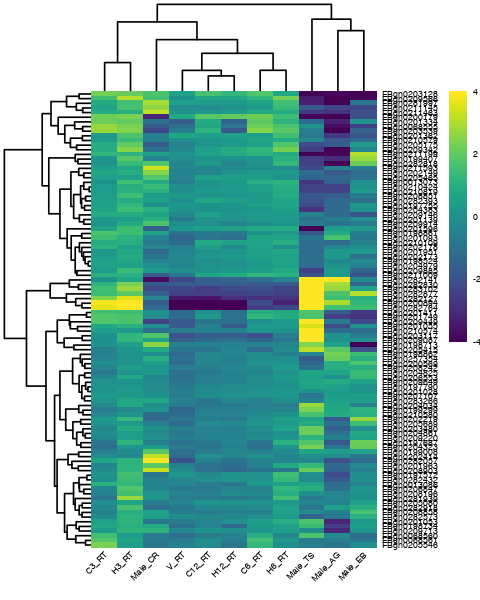

In [437]:
data = log2(transfer.candidates+1)
data = t(scale(t(data), scale=F))
data[data < -4] = -4
data[data > 4] = 4

options(repr.plot.width = 4, repr.plot.height = 5)
# pdf("Figures/tissue-biased_heatmap.pdf", width = 4, height = 5)
pheatmap(
  mat               = data,
  color             = viridis(100),
#   breaks            = mat_breaks,
  border_color      = NA,
#   labels_col        = c("carcass", "head", "ovaries", "rep. tract"),
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   annotation_row    = virgin.factor.labeling,
#   annotation_colors = mat_colors,
#   drop_levels       = TRUE,
#   annotation_names_row = F,
#   main              = "Default Heatmap",
#   filename          = "Figures/tissue-biased_heatmap.pdf",
#   width             = 4, 
#   height            = 5,
  fontsize          = 5    
)
# dev.off()

We'll use a SNP analysis comparing the conspecific and heterospecific samples to identify whether these are indeed transferred transcripts. To do this, we can use the dvir1.06 genome mapping and the _de novo_ transcriptome. For the latter, we'll output the corresponding PASA sequences from our Blast results, and also perform a DE test between 3hpm and virgin RT samples. First we'll output the homolg list:

In [438]:
transfer.candidates.gene_ids = unique(filter(geneID_to_fbgn, ref_gene_id %in% transfer.candidates.list)$gene_id)
transfer.candidates.transcript_ids = unique(filter(gene.features, gene_id %in% transfer.candidates.gene_ids)$transcript_id)
pasa.orthologs = as.character(unique(subset(pasa_v_annotated_blast, sseqid %in% transfer.candidates.transcript_ids)$qseqid))

For the DE test we need to do several things. First we'll create an RT-specific count matrix:

In [439]:
counts_bt2.pasa.RT = subset(counts_bt2.pasa, select=grepl("RT", colnames(counts_bt2.pasa)))
colnames(counts_bt2.pasa.RT) = gsub("Female_", "", colnames(counts_bt2.pasa.RT))
# counts_bt2.pasa.RT = subset(counts_bt2.pasa.RT, select=RT_GoodReps)

Now let's filter low expression genes within a minimum cpm of 5:

In [440]:
cpm_bt2.pasa.RT <- cpm(counts_bt2.pasa.RT)
thresh_RT.bt2.pasa <- cpm_bt2.pasa.RT > 5

countsKeep_RT.bt2.pasa <- rowSums(thresh_RT.bt2.pasa) >= 3
countsFiltered_bt2.pasa.RT <- counts_bt2.pasa.RT[countsKeep_RT.bt2.pasa,]

## Clean-up
rm(cpm_bt2.pasa.RT, countsKeep_RT.bt2.pasa, thresh_RT.bt2.pasa)

Create edgeR DE object and run glmFit

In [441]:
dgeList.pmv <- DGEList(counts = countsFiltered_bt2.pasa.RT, group = groups.pmv)
dgeList.pmv <- calcNormFactors(dgeList.pmv)
dgeList.pmv <- estimateCommonDisp(dgeList.pmv)
dgeList.pmv <- estimateTagwiseDisp(dgeList.pmv)
dgeList.pmv_fit <- glmFit(dgeList.pmv, design.pmv)

Now we'll run the contrasts between the 3hpm samples and the virgin sample:

In [442]:
glmT_C3.v.vir <- glmTreat(dgeList.pmv_fit, coef =3, lfc =1)
glmT_H3.v.vir <- glmTreat(dgeList.pmv_fit, coef =6, lfc =1)

Extract gene list of DE genes, first upregulated ones....

In [443]:
DE.genes_C3.v.vir_up <- rownames(subset(topTags(glmT_C3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1))
DE.genes_H3.v.vir_up <- rownames(subset(topTags(glmT_H3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1))

We'll capture the union of those two gene lists:

In [444]:
transfer.candidates.list.pasa = union(DE.genes_C3.v.vir_up, DE.genes_H3.v.vir_up)

We'll look at the overlap between the homology-based list and the DE-based list. First we'll get the PASA gene names:

In [445]:
transfer.candidates.list.pasa.transcripts = unique(filter(pasa_trans_map, V1 %in% transfer.candidates.list.pasa)$V2)

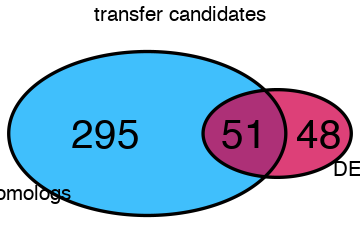

In [446]:
transCand.pasa_candidates <- list(DE = transfer.candidates.list.pasa.transcripts, homologs = pasa.orthologs)

transCand.pasa_Vdiag<-venn.diagram(transCand.pasa_candidates, NULL, fill=c("#d1004b", "#01aafb"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 1000)

transCand.pasa_combs <- unlist(lapply(1:length(transCand.pasa_candidates), function(j) combn(names(transCand.pasa_candidates), j, simplify = FALSE)), recursive = FALSE)
names(transCand.pasa_combs) <- sapply(transCand.pasa_combs, function(i) paste0(i, collapse = ","))
    
transCand.pasa_elements <- lapply(transCand.pasa_combs, function(i) Setdiff(transCand.pasa_candidates[i], transCand.pasa_candidates[setdiff(names(transCand.pasa_candidates), i)]))
    
options(repr.plot.width = 3, repr.plot.height = 2)
grid.arrange(gTree(children=transCand.pasa_Vdiag), top = "transfer candidates")

Write the list to a file:

In [447]:
write.table(unlist(transCand.pasa_elements), file = "Results/transferred.mRNA.candidates.IDs.pasa.list", quote = F, row.names = F, col.names = F)

Output individual gene plots for all transferred candidates:

In [448]:
# candidate_transferred_genome = suppressMessages(lapply(transfer.candidates.list, 
#                                                        geneBoxPlot, 
#                                                        object = filter(tpmTable_bt2.fbgn, Tissue == "repTract" | Sex == "male")))
# ggsave("Trinity/pasa/transferred_transcripts/plots/candidate_transferred_genome.pdf", marrangeGrob(grobs = candidate_transferred_genome, nrow = 3, ncol =1))

In [449]:
# candidate_transferred_pasa = suppressMessages(lapply(unique(filter(pasa_trans_map, V2 %in% unlist(transCand.pasa_elements))$V1), 
#                                                        geneBoxPlot, 
#                                                        object = filter(tpmTable_bt2.pasa, Tissue == "repTract" | Sex == "male")))
# ggsave("Trinity/pasa/transferred_transcripts/plots/candidate_transferred_pasa.pdf", marrangeGrob(grobs = candidate_transferred_pasa, nrow = 3, ncol =1))

##### Analysis of VCF output:

First load the VCF files for the genome and pasa analyses, and the SNPs inferred from the DNAseq data:

In [ ]:
genome.vcf = read.csv("Trinity/pasa/transferred_transcripts/candidate.male-transferred.mRNAs.FBtr.mrg/all_cat_merged_simplified.vcf", header = T, sep = "\t")
pasa.vcf = read.csv("Trinity/pasa/transferred_transcripts/candidate.male-transferred.mRNAs.pasa.mrg/all_cat_merged_simplified.vcf", header = T, sep = "\t")
exon.vcf = read.csv("Trinity/pasa/transferred_transcripts/candidate.male-transferred.mRNAs.FBtr.mrg/alignemnts/eXon.SNPs.vcf", header = T, sep = "\t")

add SNP ID and base character to the exon SNP object:

In [ ]:
exon.vcf$SNP_id = paste(exon.vcf$CHROM, exon.vcf$POS, sep = "_")

Now we subset the relevant columns:

In [ ]:
info.fields = subset(genome.vcf, select = c("CHROM", "POS","REF", "ALT", "QUAL", "DP"))
genotypes = subset(genome.vcf, select = c('C3_RT.bam.GT', 'H3_RT.bam.GT'))
colnames(genotypes) = gsub(".bam.GT", "", colnames(genotypes))
genome.vcf.data = cbind(info.fields, genotypes)
genome.vcf.data$SNP_id = paste(genome.vcf.data$CHROM, genome.vcf.data$POS, sep = "_")
genome.vcf.data = filter(genome.vcf.data, QUAL > 20)
# write.table(genome.vcf.data, "Trinity/pasa/transferred_transcripts/genome.transfer_candidates_subset.vcf", quote = F, sep = "\t", row.names = F)

Now merge the exon and genome results:

In [ ]:
merged.vcf = merge(genome.vcf.data, exon.vcf, by.x = "SNP_id", by.y = "SNP_id", all.x = T)

Now output the candidate transferred mRNAs for the exon analysis:

In [ ]:
exon.transfer.candidates = unique(filter(merged.vcf, as.character(C3_RT) != as.character(H3_RT) & !is.na(CHROM.y) & Dnov_4 != 1)$CHROM.x)

Also format the pasa vcf data:

In [ ]:
info.fields = subset(pasa.vcf, select = c("CHROM", "POS","REF", "ALT", "QUAL", "DP"))
genotypes = subset(pasa.vcf, select = c('C3_RT.bam.GT', 'H3_RT.bam.GT'))
colnames(genotypes) = gsub(".bam.GT", "", colnames(genotypes))
pasa.vcf.data = cbind(info.fields, genotypes)
pasa.vcf.data$SNP_id = paste(pasa.vcf.data$CHROM, pasa.vcf.data$POS, sep = "_")
pasa.vcf.data = filter(pasa.vcf.data, QUAL > 20)
nrow(pasa.vcf.data)
head(pasa.vcf.data)
# write.table(pasa.vcf.data, "Trinity/pasa/transferred_transcripts/pasa.transfer_candidates_subset.vcf", quote = F, sep = "\t", row.names = F)

Make an object of SNPs with missing information:

In [ ]:
genome.bad.SNPs = filter(genome.vcf.data, C3_RT == "./." | H3_RT == "./.")$SNP_id
pasa.bad.SNPs = filter(pasa.vcf.data, C3_RT == "./." | H3_RT == "./.")$SNP_id

Now we'll subset the VCF object to only include SNPs that are different between the con- and heterospecific samples:

In [ ]:
filter(genome.vcf.data, SNP_id %!in% genome.bad.SNPs & as.character(C3_RT) != as.character(H3_RT))
genome.transfer.candidates = unique(filter(genome.vcf.data, SNP_id %!in% genome.bad.SNPs & as.character(C3_RT) != as.character(H3_RT))$CHROM)

combine both result candidates:

In [ ]:
combined.transfer.candidates = union(exon.transfer.candidates, genome.transfer.candidates)

Extract their gene names:

In [ ]:
combined.transfer.candidates.FBgn = filter(FBgn_to_FBtr, FBtr_ID %in% combined.transfer.candidates)$FBgn

Make a heatmap of those genes:

In [ ]:
tmp = data.frame(sample = colnames(data))
tmp$factor = ifelse(grepl("Male", tmp$sample), "male tissue", ifelse(grepl("^C", tmp$sample), "RT (conspecific)", ifelse(grepl("^H", tmp$sample), "RT (heterospecific)", "RT (virgin)")))
rownames(tmp) = tmp$sample
tmp = subset(tmp, select = "factor")

mat_colors <- list(factor = c("#a8c8ff","#3f5a2a","#ffb200","#00b5d4"))
names(mat_colors$factor) <- unique(tmp$factor)

data = subset(transfer.candidates, rownames(transfer.candidates) %in% combined.transfer.candidates.FBgn)
col.order <- c("Male_CR","Male_TS","Male_AG","Male_EB","V_RT","C3_RT","H3_RT","C6_RT","H6_RT","C12_RT","H12_RT")
data = data[,col.order]
# colnames(data) <- c("carcass","Male_TS","Male_AG","Male_EB","V_RT","C3_RT","C6_RT","C12_RT","H3_RT","H6_RT","H12_RT")
data = log2(data+1)
data = t(scale(t(data), scale=F))
data[data < -2.5] = -2.5
data[data > 2.5] = 2.5

options(repr.plot.width = 7, repr.plot.height = 4)
# pdf("Figures/transferred_mRNAs_heatmap.pdf", width = 7, height = 4)
pheatmap(
  mat               = data,
  color             = inferno(100),
#   breaks            = mat_breaks,
  border_color      = NA,
  labels_col        = c("carcass","testes","acc. glands","ej. bulb","virgin","3hpm","3hpm","6hpm","6hpm","12hpm","12hpm"),
  show_colnames     = TRUE,
  show_rownames     = FALSE,
cluster_cols = F,
  annotation_col    = tmp,
  annotation_colors = mat_colors,
  drop_levels       = TRUE,
  annotation_names_col = F,
#   main              = "Default Heatmap",
#   filename          = "Figures/transferred_mRNAs_heatmap.pdf",
#   width             = 7, 
#   height            = 4,
  fontsize          = 12    
)
# dev.off()

In [ ]:
# candidate_transferred_genome = suppressMessages(lapply(as.character(combined.transfer.candidates.FBgn), 
#                                                        geneBoxPlot, 
#                                                        object = filter(tpmTable_bt2.fbgn, Tissue == "repTract" | Sex == "male")))
# ggsave("Trinity/pasa/transferred_transcripts/plots/candidate_transferred_combined.pdf", marrangeGrob(grobs = candidate_transferred_genome, nrow = 3, ncol =1))

#### Analysis of SPermathecal genes in _D. melanogaster_ and their virilis group orthologs:

We'll use the new FlyATlas2 data to make comparisons between the RT-biased genes and genes that respond to mating in the RT. First load all the releveant FlyAtlas2 files:

In [ ]:
# load feature anotations:
transcript.features = read.table("~/Dropbox/RNAseq/FlyAtlas2/StringTie/features.txt", header = T)

# load transcript lengths
transcript.lengths = read.table("~/Dropbox/RNAseq/FlyAtlas2/StringTie/stringtie_transcript_lengths.txt", header = F, sep = "\t")
colnames(transcript.lengths) = c("transcript_id", "length")

# load annotations
annotation = read.csv("~/Dropbox/RNAseq/Axenic.PM/Annotoations/fbgn_annotation_ID_fb_2018_04_mod.tsv", header = T, check.names = F, sep ="\t")
FBgn_to_symbol = subset(annotation, select = c("gene_symbol", "primary_FBgn"))
# load gene snapshots
snapshots = read.csv("~/Dropbox/RNAseq/Axenic.PM/Annotoations/gene_snapshots_fb_2018_05.tsv", header = T, sep ="\t", quote = "")

# merge features with lengths:
transcript.features.lengths = merge(transcript.features, transcript.lengths, by.x = "transcript_id", by.y = "transcript_id", all.x = TRUE)
# Select only the length and gene_id columns
tmpMrge = as.data.table(subset(transcript.features.lengths, select = c("length", "gene_id")))
# For each gene ID entry, select the entry with largest value in the "length" column:
gene.lengths = tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1]
## order by geneID
gene.lengths = gene.lengths[order(gene_id),] 
# remove un-needed intermediate objects
rm(tmpMrge)

# load sample information from SRA table:
sample.info = read.table("~/Dropbox/RNAseq/FlyAtlas2/Misc/SraRunTable_FlyAtlas2_modified.txt", header = T, sep = "\t")
sample.info = filter(sample.info, RNA == "mRNA")
sample.info = select(sample.info, Library_Name, Replicate_Name, Sex, dev_stage, organism_part, Sample_Name)
sample.info$Library_Name = gsub("Female ", "", sample.info$Library_Name)
sample.info$Library_Name = gsub("Male ", "", sample.info$Library_Name)
sample.info$Library_Name = gsub("Larval ", "", sample.info$Library_Name)
sample.info$Sex = gsub("NA", "unknown", sample.info$Sex)

# load gene and transcript counts:
gene.counts = read.csv("~/Dropbox/RNAseq/FlyAtlas2/ballgown/gene_counts.csv", header = T, sep = ",", row.names = 1)
gene.counts = subset(gene.counts, rownames(gene.counts) %in% gene.lengths$gene_id)
gene.counts <- gene.counts[ order(row.names(gene.counts)), ]
transcript.counts = read.csv("~/Dropbox/RNAseq/FlyAtlas2/ballgown/transcript_counts.csv", header = T, sep = ",", row.names = 1)

# Make TPM tables:
gene.tpm <- apply(gene.counts, 2, function(x) tpm(x, gene.lengths$length))
gene.tpm = as.data.frame(gene.tpm)
    
# subset the transcript features to only include genes:
gene.features = unique(select(transcript.features, ref_gene_id, gene_name, gene_id, contig))

Make a melted version of the TPM table:

In [ ]:
tmp.tpmMatrix<-gene.tpm
# colnames(tmp.tpmMatrix) <- sample.info$Sample_Name
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate_id", "TPM")
tmp.tpmMatrix.m <- merge(tmp.tpmMatrix.m, sample.info, by.x = "replicate_id", by.y = "Replicate_Name", all.x = T)
tpm.table <- merge(tmp.tpmMatrix.m, gene.features, by.x = "gene_id", by.y = "gene_id", )
rm(tmp.tpmMatrix.m)

tpm.table$Library_Name = factor(tpm.table$Library_Name, levels = c("Whole", "Carcass", "CNS","Head", "Eye", "Brain", "Salivary Gland", "Thoracicoabdominal Ganglion", "Trachea","Tubule", "Midgut", "Hindgut", "Crop", "FatBody","Ovary", "Virgin Spermatheca", "Mated Spermatheca", "Testis", "Accessory Glands", "Anal Pad"))

Read in the matrix file:

In [ ]:
tpm.matrix_fa2 = read.csv("~/Dropbox/RNAseq/Axenic.PM/Annotoations/FlyAtlas2_meanTPM_table.txt", header = T, sep = "\t", row.names = 1)

Here's a single gene plot:

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 3)
geneBoxPlot_fa2(tpm.table, "LanA")

##### Differential expression of Female spermathecal genes:

Subset the samples file to only include the female samples:

In [ ]:
sample.info.fem = filter(sample.info, Sex == "female" & organism_part != "Anal Pad" & organism_part != "Brain" & organism_part != "Carcass" & organism_part != "Eye" & organism_part != "Whole" & Sample_Name != "Female_Mated_Spermatheca")
sample.info.fem$Spermatheca_status = ifelse(grepl("Spermatheca", sample.info.fem$Library_Name), "YES", "NO")

sample.info.sp = subset(sample.info, grepl("Spermatheca", Library_Name))

Filter:

In [ ]:
fem.gene.counts = subset(gene.counts, select = as.character(sample.info.fem$Replicate_Name))
gene.CPM <- cpm(fem.gene.counts)
thresh <- gene.CPM > 5
keep <- rowSums(thresh) >= 3
counts.keep.fem <- fem.gene.counts[keep,]
dim(counts.keep.fem)

sp.gene.counts = subset(gene.counts, select = grepl("Spermatheca", colnames(gene.counts)))
gene.CPM <- cpm(sp.gene.counts)
thresh <- gene.CPM > 2
keep <- rowSums(thresh) >= 3
counts.keep.sp <- sp.gene.counts[keep,]
dim(counts.keep.sp)

Define groups:

In [ ]:
groups.sp = factor(sample.info.fem$Spermatheca_status)
design.sp = model.matrix( ~ 0 + groups.sp)
colnames(design.sp) <- levels(groups.sp)
rownames(design.sp) <- sample.info.fem$Replicate_Name

groups.spDE = factor(sample.info.sp$Sample_Name)
design.spDE = model.matrix( ~ 0 + groups.spDE)
colnames(design.spDE) <- levels(groups.spDE)
rownames(design.spDE) <- sample.info.sp$Replicate_Name

Fit the model:

In [ ]:
dgeList.sp <- DGEList(counts = counts.keep.fem, group = groups.sp)
dgeList.sp <- calcNormFactors(dgeList.sp)
dgeList.sp <- estimateDisp(dgeList.sp, design.sp)
dgeList.sp_fit <- glmQLFit(dgeList.sp, design.sp, robust = T)
summary(dgeList.sp$tagwise.dispersion)

dgeList.spDE <- DGEList(counts = counts.keep.sp, group = groups.spDE)
dgeList.spDE <- calcNormFactors(dgeList.spDE)
dgeList.spDE <- estimateDisp(dgeList.spDE, design.spDE)
dgeList.spDE_fit <- glmQLFit(dgeList.spDE, design.spDE, robus = T)
summary(dgeList.spDE$tagwise.dispersion)

Add annotation info:

In [ ]:
ann = subset(gene.features, gene_id %in% rownames(dgeList.sp_fit))
ann = data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
ann = ann[match(rownames(dgeList.sp_fit), ann$gene_id),]
ann <- data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
ann <- subset(ann, select = c("gene_id", "gene_name", "ref_gene_id"))
colnames(ann) = c ("GeneID", "gene_name", "ref_gene_id")
table(ann$GeneID==rownames(dgeList.sp_fit))
dgeList.sp_fit$genes = ann

ann = subset(gene.features, gene_id %in% rownames(dgeList.spDE_fit))
ann = data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
ann = ann[match(rownames(dgeList.spDE_fit), ann$gene_id),]
ann <- data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
ann <- subset(ann, select = c("gene_id", "gene_name", "ref_gene_id"))
colnames(ann) = c ("GeneID", "gene_name", "ref_gene_id")
table(ann$GeneID==rownames(dgeList.spDE_fit))
dgeList.spDE_fit$genes = ann

In [ ]:
glMDSPlot(dgeList.spDE, groups = dgeList.spDE$samples, labels = sample.info.sp$Sample_Name)

Look at QC sats:

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.spDE)
# mean-variance trend
voom = voom(dgeList.spDE, design.spDE, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList.spDE_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voom$E),col="blue")

rm(voom, g.v, z.v)

Set up contrasts:

In [ ]:
Sp_contrasts <- makeContrasts(Female_Mated_Spermatheca-Female_Virgin_Spermatheca, levels=design.spDE)

Spermatheca_contrast <- makeContrasts(YES-NO, levels=design.sp)

First run the comparison between the mated and virgin spermatheca:

In [ ]:
lrt.v.SpDE <- glmQLFTest(dgeList.spDE_fit, contrast = Sp_contrasts)
lrt.v.SpDE.tTags <- topTags(lrt.v.SpDE, n = NULL)
lrt.v.SpDE.tTags.table <- lrt.v.SpDE.tTags$table
lrt.v.SpDE.tTags.table$sig = ifelse(lrt.v.SpDE.tTags.table$FDR < 0.05 & (lrt.v.SpDE.tTags.table$logFC > 1 | lrt.v.SpDE.tTags.table$logFC < -1), "yes", "no")
head(lrt.v.SpDE.tTags.table)

Make a volcano plot of the comparison between mated and virgin spermathecae:

In [ ]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(lrt.v.SpDE.tTags.table, aes(logFC, -log10(PValue), colour = sig)) + 
    geom_point(alpha = 0.5) + 
    geom_text_repel(data = filter(lrt.v.SpDE.tTags.table, sig == "yes" & logFC > 1),aes(label=gene_name), 
                                force = 30,
                                colour = "black",
                                fontface = "bold", 
                                size = 3) +
    scale_colour_manual(values = c("gray", "#d55300"))

Now let's fine spermatheca-biased genes:

In [ ]:
lrt.v.Sp <- glmQLFTest(dgeList.sp_fit, contrast = Spermatheca_contrast)
lrt.v.Sp.tTags <- topTags(lrt.v.Sp, n = NULL)
lrt.v.Sp.tTags.table <- lrt.v.Sp.tTags$table
lrt.v.Sp.tTags.table$sig = ifelse(lrt.v.Sp.tTags.table$FDR < 0.05 & (lrt.v.Sp.tTags.table$logFC > 1 | lrt.v.Sp.tTags.table$logFC < -1), "yes", "no")
Spermatheca_genes = subset(lrt.v.Sp.tTags.table, sig == "yes" & logFC > 1)$ref_gene_id
length(Spermatheca_genes)
head(lrt.v.Sp.tTags.table)

In [ ]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(lrt.v.Sp.tTags.table, aes(logFC, -log10(PValue), colour = sig)) + 
    geom_point(alpha = 0.5) + 
    geom_text_repel(data = filter(lrt.v.Sp.tTags.table, sig == "yes" & -log10(PValue) > 15),aes(label=gene_name), 
                                force = 30,
                                colour = "green",
                                fontface = "bold", 
                                size = 3) +
    scale_colour_manual(values = c("gray", "#00918c"))

Looks like there's a lot of them. Let's make a heatmap instead:

In [ ]:
mel_rt_orths = as.character(unique(subset(melOrths, FBgn_ID %in% fRT.list)$mel_FBgn_ID))

options(repr.plot.width = 5, repr.plot.height =15)
heatmap_fa2(select(tpm.matrix_fa2, matches("Female")), mel_rt_orths, fly_atlas = T, title = "none")

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 3)
geneBoxPlot_fa2(tpm.table, "FBgn0083121")

Let's check the overlap between virilis female RT genes and _D. mel_ fRT genes:

In [ ]:
transCand.pasa_candidates <- list(Dmel = mel_rt_orths, Dvir = Spermatheca_genes)

transCand.pasa_Vdiag<-venn.diagram(transCand.pasa_candidates, NULL, fill=c("#d1004b", "#01aafb"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 1000)

transCand.pasa_combs <- unlist(lapply(1:length(transCand.pasa_candidates), function(j) combn(names(transCand.pasa_candidates), j, simplify = FALSE)), recursive = FALSE)
names(transCand.pasa_combs) <- sapply(transCand.pasa_combs, function(i) paste0(i, collapse = ","))
    
transCand.pasa_elements <- lapply(transCand.pasa_combs, function(i) Setdiff(transCand.pasa_candidates[i], transCand.pasa_candidates[setdiff(names(transCand.pasa_candidates), i)]))
    
options(repr.plot.width = 3, repr.plot.height = 2)
grid.arrange(gTree(children=transCand.pasa_Vdiag), top = "transfer candidates")

Here's a plot for genes that are orthologus to a given virilis gene list:

In [ ]:
mel_rt_orths = as.character(unique(subset(melOrths, FBgn_ID %in% fRT.list)$mel_FBgn_ID))

options(repr.plot.width = 8, repr.plot.height =12)
heatmap_fa2(select(tpm.matrix_fa2, contains("Female")), mel_rt_orths, fly_atlas = T, title = "none")

In [ ]:
SFPs = c( "FBgn0051779", "FBgn0002855", "FBgn0002856", "FBgn0015583", "FBgn0023415", "FBgn0023414", "FBgn0011559", "FBgn0034152", "FBgn0034153", "FBgn0053530", "FBgn0015584", "FBgn0020509", "FBgn0015585", "FBgn0003034", "FBgn0015586", "FBgn0002863", "FBgn0013745", "FBgn0000094", "FBgn0016123", "FBgn0083938", "FBgn0250831", "FBgn0047334", "FBgn0052203", "FBgn0004780", "FBgn0039596", "FBgn0038014", "FBgn0038395", "FBgn0034638", "FBgn0037036", "FBgn0037039", "FBgn0032853", "FBgn0032843", "FBgn0035455", "FBgn0034195", "FBgn0037038", "FBgn0033164", "FBgn0033165", "FBgn0037204", "FBgn0038067", "FBgn0038069", "FBgn0032964", "FBgn0040341", "FBgn0028944", "FBgn0037650", "FBgn0039599", "FBgn0039540", "FBgn0033572", "FBgn0035933", "FBgn0033868", "FBgn0032834", "FBgn0250847", "FBgn0039598", "FBgn0259226", "FBgn0032331", "FBgn0030623", "FBgn0034415", "FBgn0034417", "FBgn0031617", "FBgn0030643", "FBgn0031412", "FBgn0033167", "FBgn0033831", "FBgn0032275", "FBgn0250841", "FBgn0038829", "FBgn0032868", "FBgn0250842", "FBgn0038919", "FBgn0037433", "FBgn0034512", "FBgn0036837", "FBgn0036795", "FBgn0036794", "FBgn0043825", "FBgn0036091", "FBgn0042182", "FBgn0034753", "FBgn0023529", "FBgn0031468", "FBgn0050395", "FBgn0050463", "FBgn0050486", "FBgn0050488", "FBgn0051016", "FBgn0051418", "FBgn0051419", "FBgn0051515", "FBgn0038198", "FBgn0051659", "FBgn0051680", "FBgn0051704", "FBgn0259225", "FBgn0051872", "FBgn0032122", "FBgn0052201", "FBgn0052382", "FBgn0052383", "FBgn0052667", "FBgn0052833", "FBgn0036495", "FBgn0053462", "FBgn0036459", "FBgn0054002", "FBgn0054033", "FBgn0054034", "FBgn0054051", "FBgn0262005", "FBgn0083965", "FBgn0083966", "FBgn0085464", "FBgn0035042", "FBgn0260766", "FBgn0039568", "FBgn0034229", "FBgn0030828", "FBgn0034154", "FBgn0039521", "FBgn0036186", "FBgn0036154", "FBgn0036970", "FBgn0034162", "FBgn0030932", "FBgn0032367", "FBgn0036969", "FBgn0038918", "FBgn0036527", "FBgn0033999", "FBgn0037664", "FBgn0031746", "FBgn0035216", "FBgn0032080", "FBgn0030222", "FBgn0034435", "FBgn0039597", "FBgn0033942", "FBgn0036110", "FBgn0005585", "FBgn0004629", "FBgn0250832", "FBgn0086712", "FBgn0000592", "FBgn0010470", "FBgn0015000", "FBgn0039562", "FBgn0041629", "FBgn0001218", "FBgn0040107", "FBgn0040098", "FBgn0040097", "FBgn0040093", "FBgn0040092", "FBgn0004426", "FBgn0028416", "FBgn0260745", "FBgn0004414", "FBgn0011668", "FBgn0011669", "FBgn0011670", "FBgn0053126", "FBgn0052190", "FBgn0043539", "FBgn0043530", "FBgn0034471", "FBgn0043533", "FBgn0034474", "FBgn0043532", "FBgn0026058", "FBgn0041621", "FBgn0014002", "FBgn0004181", "FBgn0011694", "FBgn0022770", "FBgn0019948", "FBgn0030362", "FBgn0010406", "FBgn0037889", "FBgn0259949", "FBgn0259951", "FBgn0259952", "FBgn0261054", "FBgn0259956", "FBgn0259958", "FBgn0259959", "FBgn0261055", "FBgn0259962", "FBgn0259963", "FBgn0259964", "FBgn0261056", "FBgn0259965", "FBgn0261057", "FBgn0261058", "FBgn0259966", "FBgn0259967", "FBgn0259968", "FBgn0259969", "FBgn0259970", "FBgn0259972", "FBgn0261059", "FBgn0261059", "FBgn0259973", "FBgn0259974", "FBgn0259975", "FBgn0261060", "FBgn0261061", "FBgn0028988", "FBgn0028987", "FBgn0028986", "FBgn0083141", "FBgn0041180", "FBgn0003862", "FBgn0045823")